# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2024. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [313]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from scipy.integrate import quad
from scipy.stats import linregress
from dataclasses import dataclass
from math import sqrt,floor

In [314]:
# Constants for columns
DEATH_COLUMN = 'dead'
RUNNING_MORALITY_PERCENTAGE_COLUMN = 'cumulative deaths %'
PROBABILITY_OF_DEATH_PER_PERIOD_COLUMN = 'p(death per time period)'
AGE_IN_DAYS_COLUMN = 'age(days)'

# Human dataset columns
HUMAN_AGE_IN_YEARS_COLUMN = 'Age'
HUMAN_DEATHS_PER_YEAR_COLUMN = 'Total'

# Constants for column values
CONTROL_GROUP_KEY = 'Control'

# time periods to bin mice by
# 13 was chosen because it is the fixed
# time period that made the data closest to having
# sqrt(dataset size) bins for the control group
mouse_bin_period_in_days = 13

days_per_years = 365

# Dataset Paths
HUMAN_LIFESPAN_DATASET_PATH = "../dat/final_datasets/Lifespans_Humans.xlsx"
MOUSE_LIFESPAN_DATASET_PATH = "../dat/final_datasets/Lifespans_ITP1.csv"

In [315]:
df = pd.read_csv(
    MOUSE_LIFESPAN_DATASET_PATH,
    skiprows=0,
    sep=";",
    index_col=[0, 1],
    skipfooter=0,
    engine="python",
    decimal=",",
)
df

site sex       id     group Rx(ppm)  age_initiation(mo)  \
population cohort                                                           
UM-HET3    C2004   TJL   m  JL00005  4-OH-PBN   315.0                 4.0   
           C2004   TJL   m  JL00006  4-OH-PBN   315.0                 4.0   
           C2004   TJL   m  JL00007  4-OH-PBN   315.0                 4.0   
           C2004   TJL   f  JL00095  4-OH-PBN   315.0                 4.0   
           C2004   TJL   f  JL00096  4-OH-PBN   315.0                 4.0   
...                ...  ..      ...       ...     ...                 ...   
           C2017    UT   m  UT10744       Syr   300.0                 5.0   
           C2017    UT   m  UT10745       Syr   300.0                 5.0   
           C2017    UT   m  UT10783       Syr   300.0                 5.0   
           C2017    UT   m  UT10784       Syr   300.0                 5.0   
           C2017    UT   m  UT10785       Syr   300.0                 5.0   

                  status  dead  age(days)  
population cohort                          
UM-HET3    C2004    dead     1        896  
           C2004    dead     1       1077  
           C2004    dead     1        790  
           C2004    dead     1        823  
           C2004    dead     1        601  
...                  ...   ...        ...  
           C2017    dead     1        289  
           C2017    dead     1        662  
           C2017    dead     1        440  
           C2017    dead     1        342  
           C2017    dead     1        754  

[26993 rows x 9 columns]

In [316]:
control_group = df.loc[df['group'] == CONTROL_GROUP_KEY]
control_group = control_group.sort_values(by=[AGE_IN_DAYS_COLUMN])
control_group

site sex       id    group Rx(ppm)  age_initiation(mo)  \
population cohort                                                          
UM-HET3    C2005    UT   f  UT01531  Control     0.0                 NaN   
           C2004    UT   m  UT00803  Control     0.0                 NaN   
           C2005    UT   f  UT01532  Control     0.0                 NaN   
           C2005    UT   f  UT01529  Control     0.0                 NaN   
           C2005    UT   f  UT01530  Control     0.0                 NaN   
...                ...  ..      ...      ...     ...                 ...   
           C2007   TJL   f  JL03117  Control     0.0                 NaN   
           C2014   TJL   f  JL11157  Control     0.0                 NaN   
           C2007    UM   f  UM23597  Control     0.0                 NaN   
           C2015   TJL   f  JL12242  Control     0.0                 NaN   
           C2011    UM   f  UM38745  Control     0.0                 NaN   

                    status  dead  age(days)  
population cohort                            
UM-HET3    C2005   removed     0         27  
           C2004      dead     1         27  
           C2005   removed     0         27  
           C2005   removed     0         29  
           C2005   removed     0         29  
...                    ...   ...        ...  
           C2007      dead     1       1340  
           C2014      dead     1       1358  
           C2007      dead     1       1359  
           C2015      dead     1       1396  
           C2011      dead     1       1456  

[7815 rows x 9 columns]

In [317]:
# Split dataset into intervention datasets

experiment_names = df['group'].unique()

experiment_groups = {}
for experiment_name in experiment_names:
    experiment_group = df.loc[df['group'] == experiment_name].copy()
    experiment_group = experiment_group.sort_values(by=[AGE_IN_DAYS_COLUMN]).copy()

    # ignore experiment groups with not enough data
    if len(experiment_group) > 1:
        experiment_groups[experiment_name] = experiment_group

def map_over_experiments(experiment_groups, fn, *args):
    return {name: fn(data, *args) for name, data in experiment_groups.items()}

# Mouse Dataset Preprocessing (Bucketing)
Here we bucket (or group) deaths in the mouse dataset into a bucket of a certain fixed time range (e.g. death in 0-9 days, 10-19 days, 20-29 days, etc.). We do this as the deaths are currently recorded as they occur which can occur at any length of time, thereby making the data less easily intepretable and less compatable with most human dataset

In [318]:
def group_same_ages(data) -> pd.DataFrame:
    return data.groupby(AGE_IN_DAYS_COLUMN).sum()

def group_ages(data: pd.DataFrame, bin_period_in_days: int) -> pd.DataFrame:
    data = data[[DEATH_COLUMN, AGE_IN_DAYS_COLUMN]]

    data = group_same_ages(data)

    group_days_by_time_period = lambda x: (x // bin_period_in_days)
    groupped_data_by_time_period = data.groupby(group_days_by_time_period).sum()

    index_name = f'age(per {bin_period_in_days} days)'
    groupped_data_by_time_period.index.name = index_name
    return groupped_data_by_time_period


experiment_dead_counts = map_over_experiments(experiment_groups, group_ages, mouse_bin_period_in_days)
experiment_dead_counts[CONTROL_GROUP_KEY]

dead
age(per 13 days)      
2                    1
3                    2
4                    1
5                    0
6                    2
...                ...
102                  2
103                  2
104                  2
107                  1
112                  1

[104 rows x 1 columns]

# Mouse Dataset Preprocessing (Mortality Rate per Time Period)

We follow this with computing the chance of death with a time period range. As an example, if there were 1,000 mice alive at *day 100* and 900 left at 110 days (with 10 being the bucket size of the histogram), then (1,000 - 900) / 1,000 = 10% would be the calculated chance of death. This ignores how many mice were alive initially at the start of the experiment for that particular calculation.

In [319]:
def calculate_running_alive_counts(data: pd.DataFrame) -> pd.DataFrame:
    total = calculate_total(data)
    running_alive = total - data.cumsum()

    # Start dataset with all alive and drop the last column to maintain same
    # shape as before
    running_alive.index += 1
    running_alive = pd.concat([pd.DataFrame([total]), running_alive])[:-1]

    return running_alive

def calculate_total(data: pd.DataFrame) -> pd.DataFrame:
    return data.sum()

def compute_chance_of_death_per_time_period(dead_counts: pd.DataFrame,
                                            running_alive_counts: pd.DataFrame) -> pd.DataFrame:
    return dead_counts / (running_alive_counts + 1e-9)


running_alive_counts = map_over_experiments(experiment_dead_counts, calculate_running_alive_counts)

chance_of_death_per_experiment = {}
for experiment_name in experiment_dead_counts.keys():
    dead_counts = experiment_dead_counts[experiment_name]
    alive_counts = running_alive_counts[experiment_name]
    chance_of_death = compute_chance_of_death_per_time_period(dead_counts, alive_counts)
    chance_of_death_per_experiment[experiment_name] = chance_of_death


chance_of_death_per_experiment[CONTROL_GROUP_KEY]

dead
0         NaN
2         NaN
3    0.000272
4    0.000136
5    0.000000
..        ...
104  0.500000
105       NaN
107       NaN
108       NaN
112       NaN

[108 rows x 1 columns]

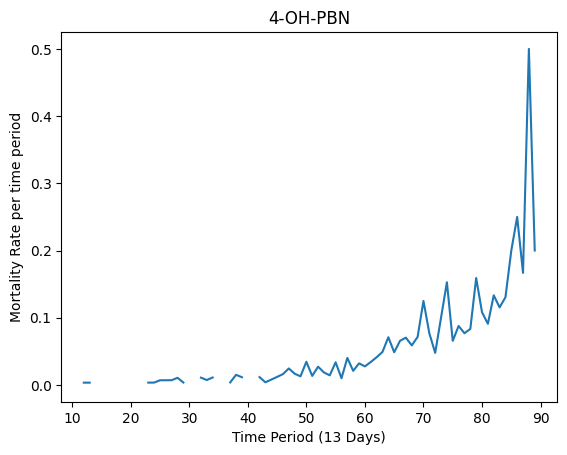

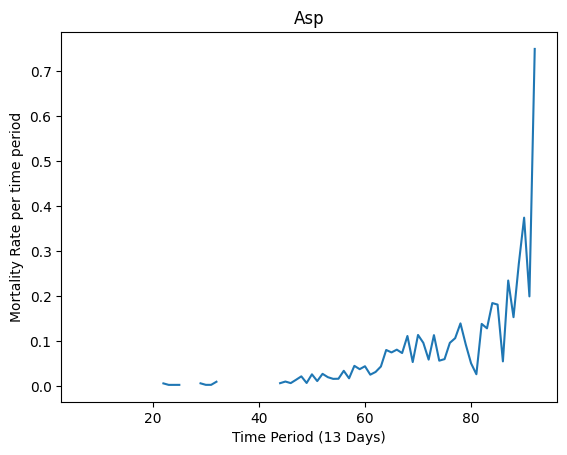

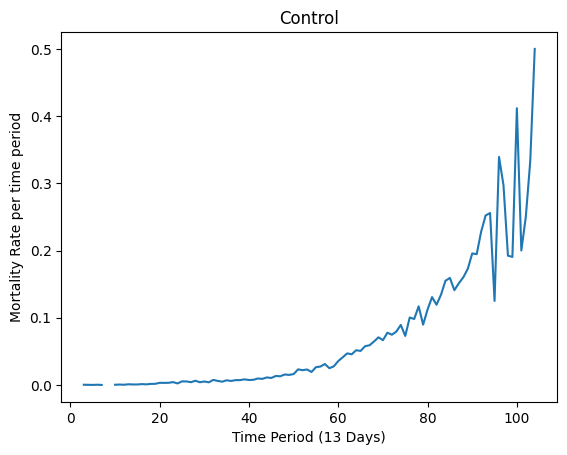

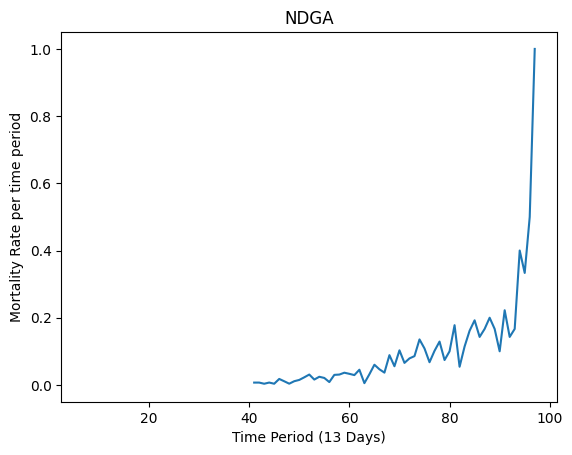

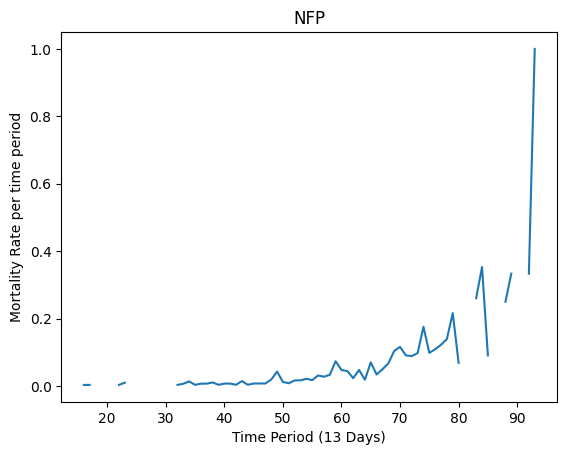

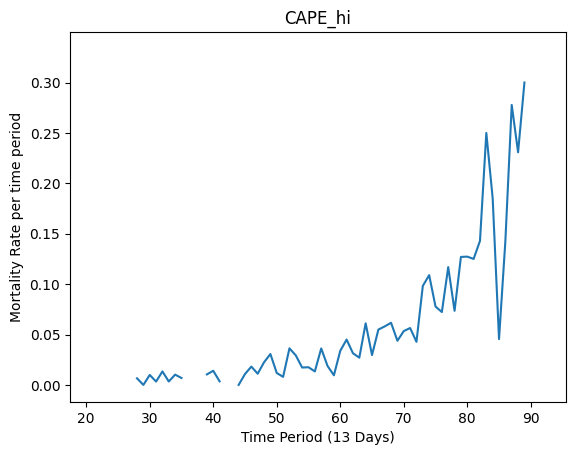

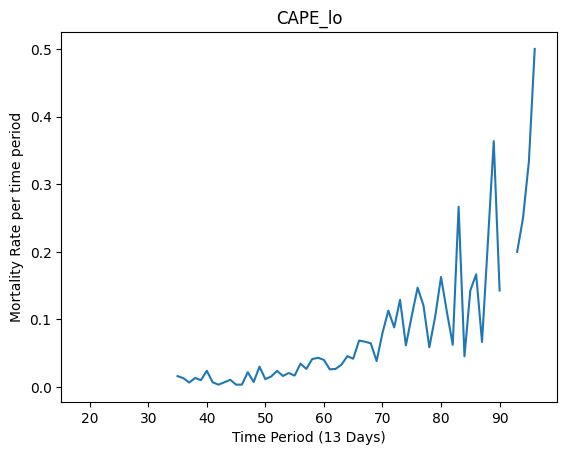

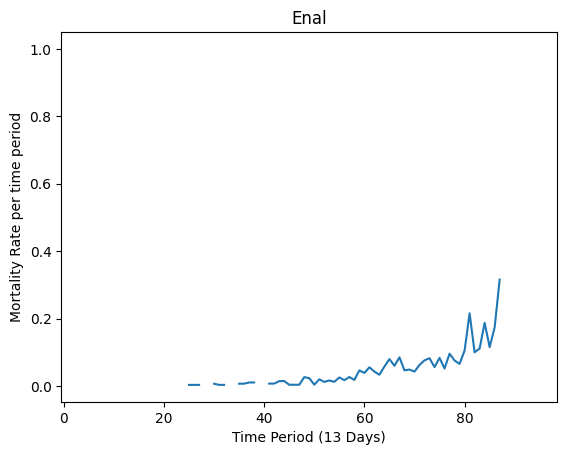

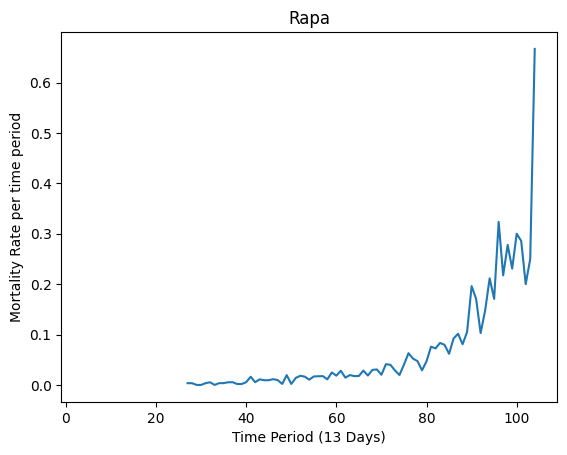

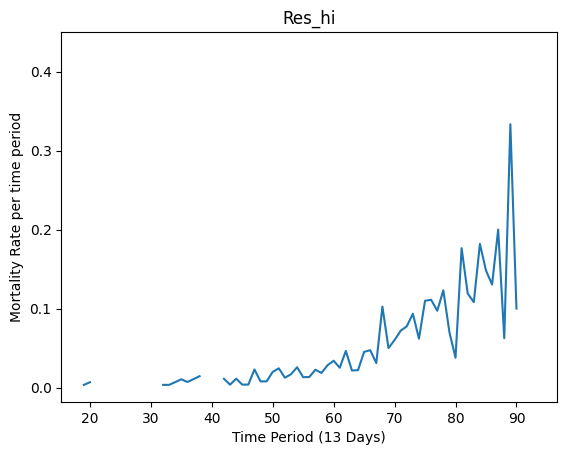

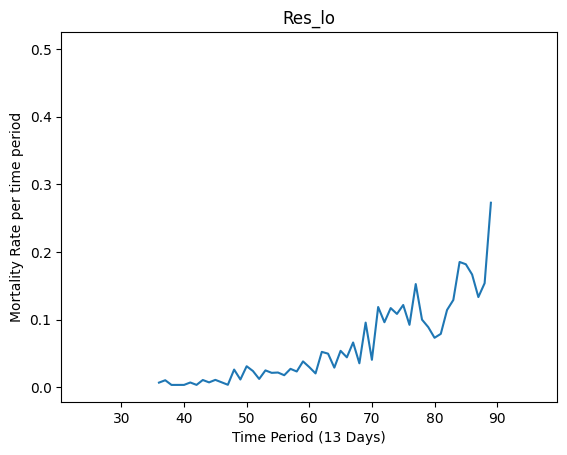

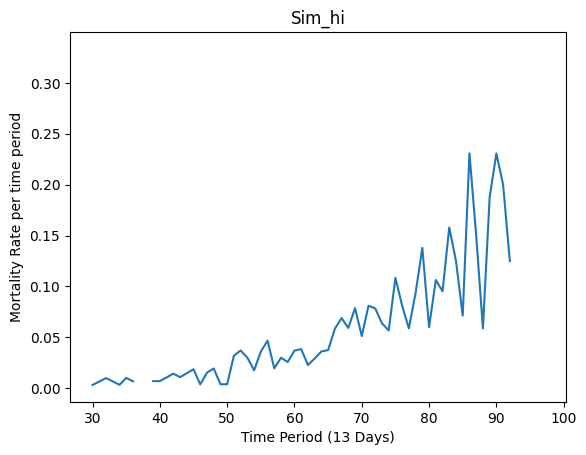

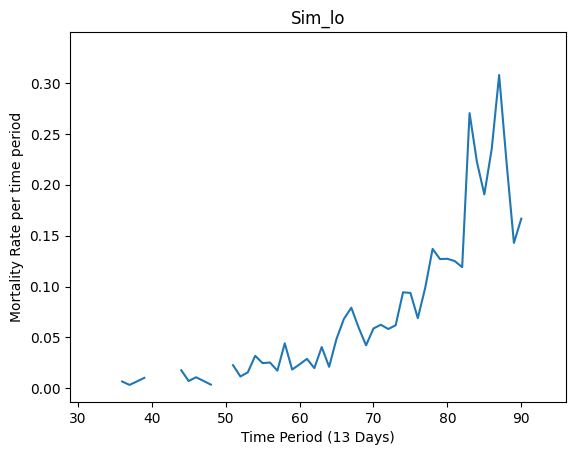

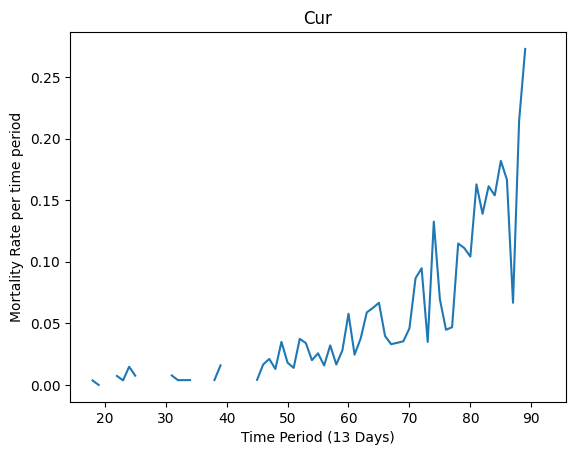

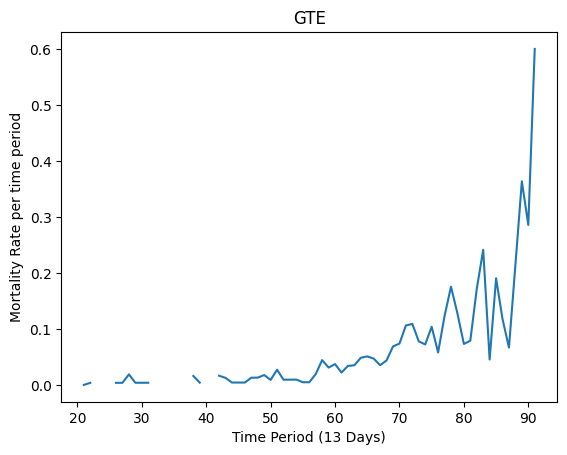

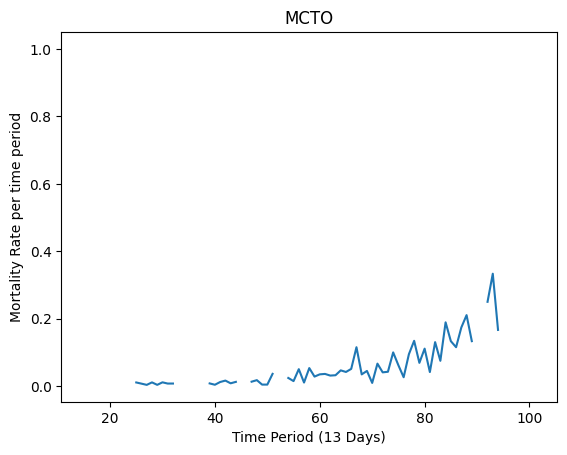

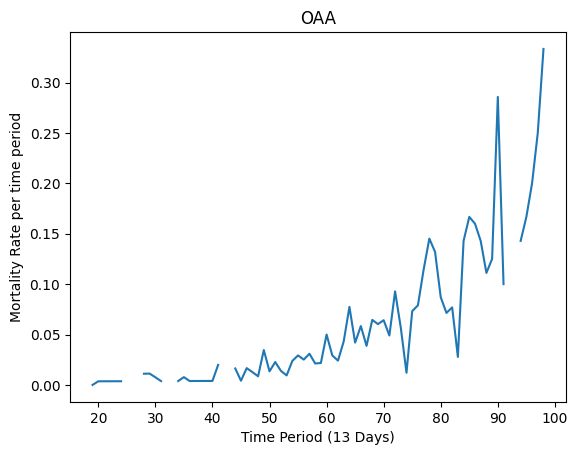

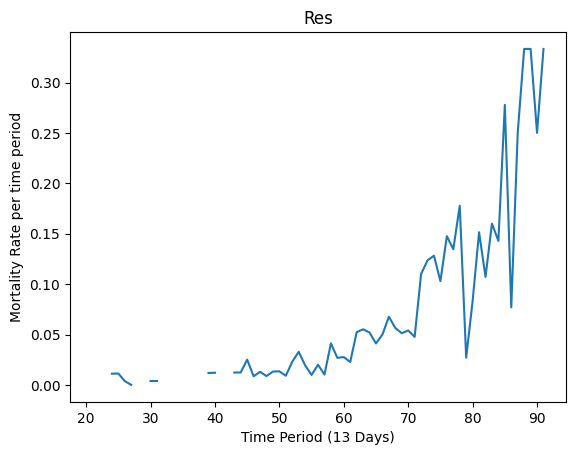

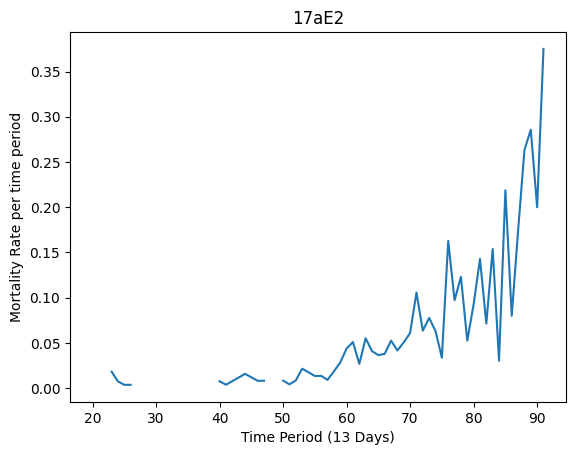

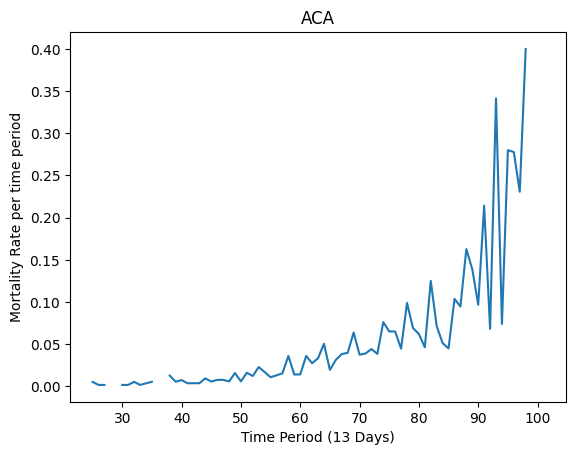

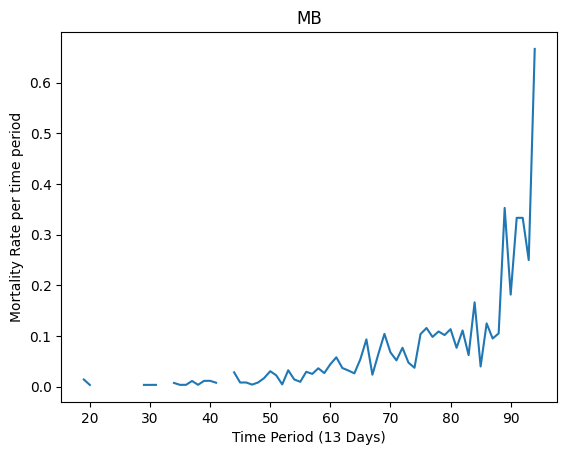

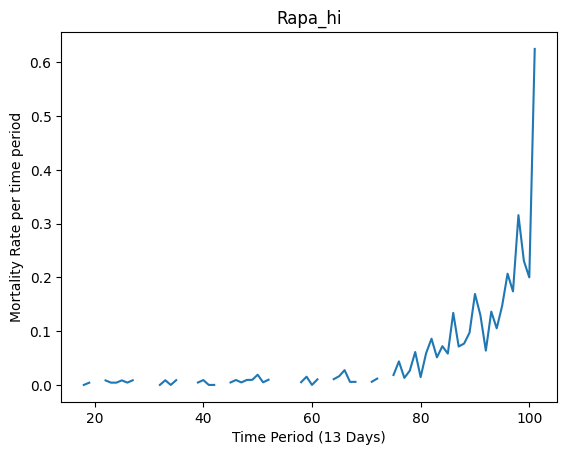

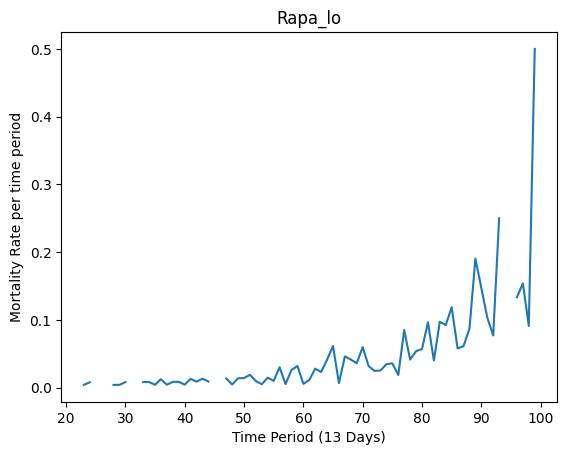

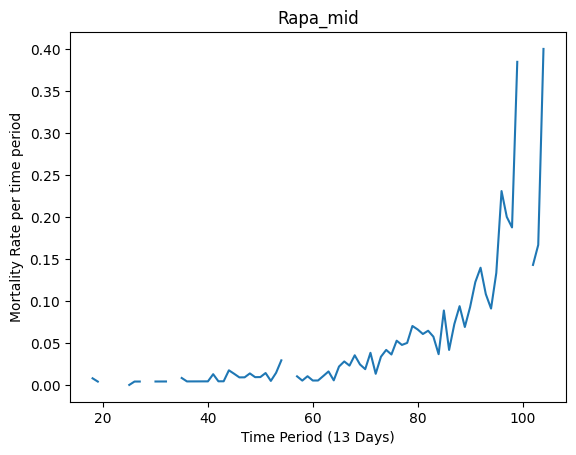

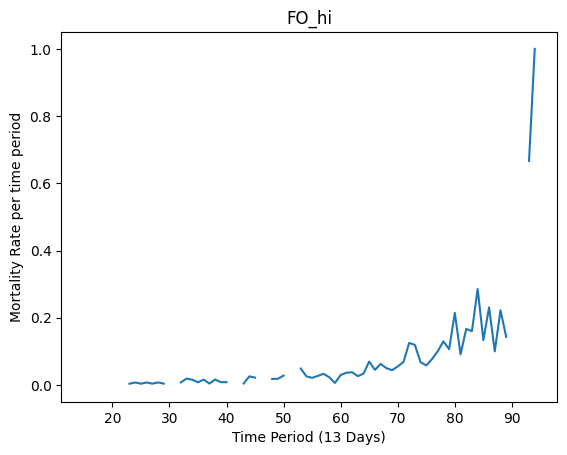

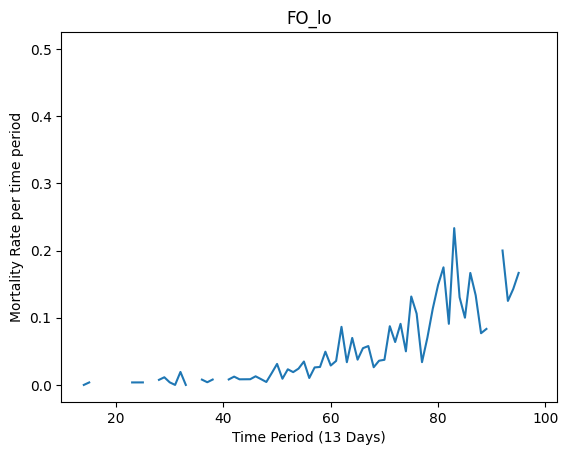

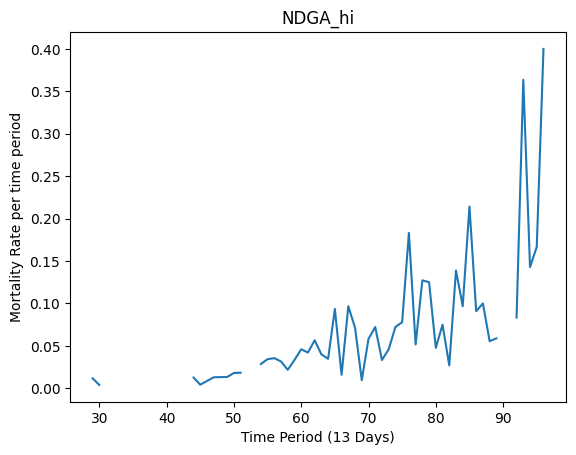

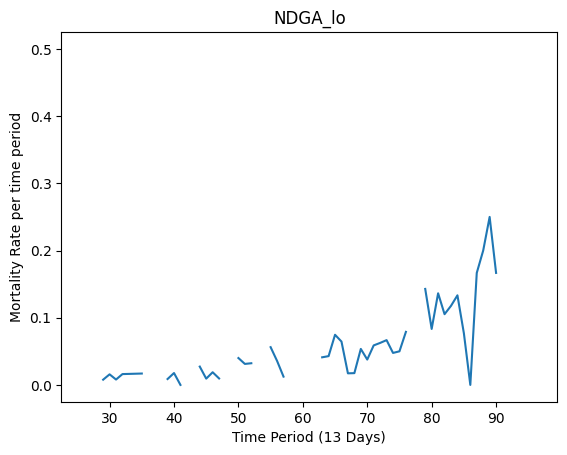

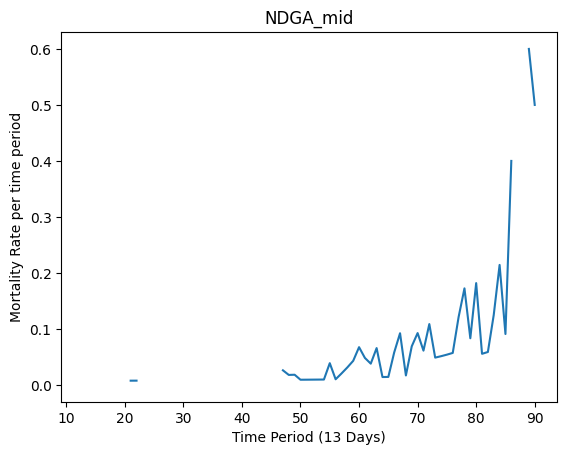

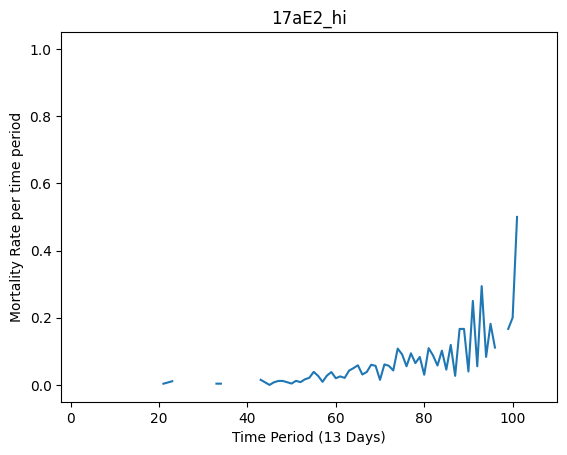

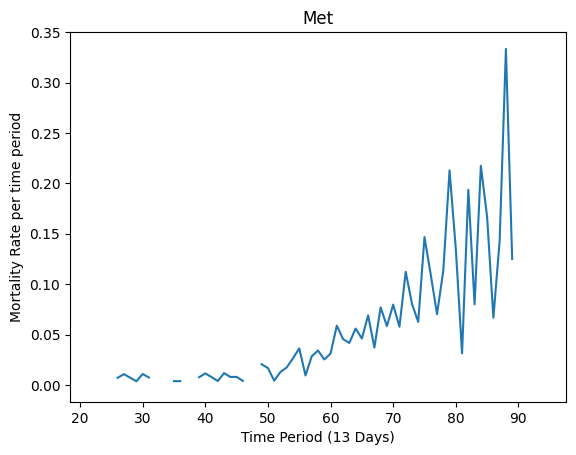

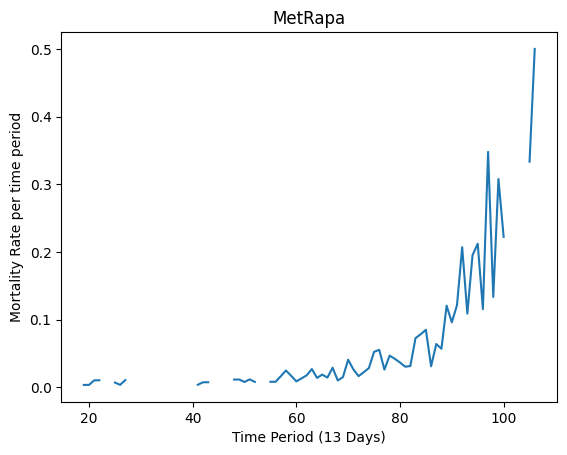

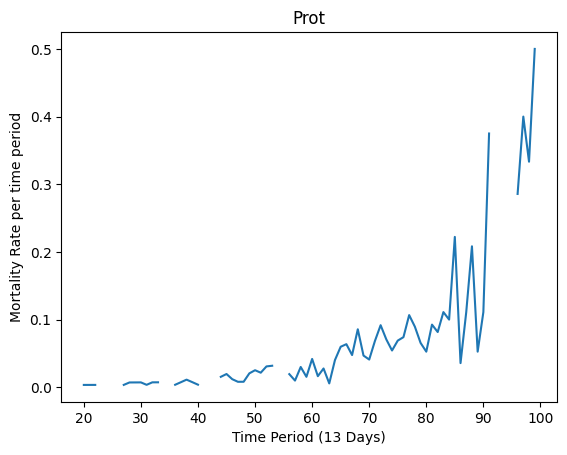

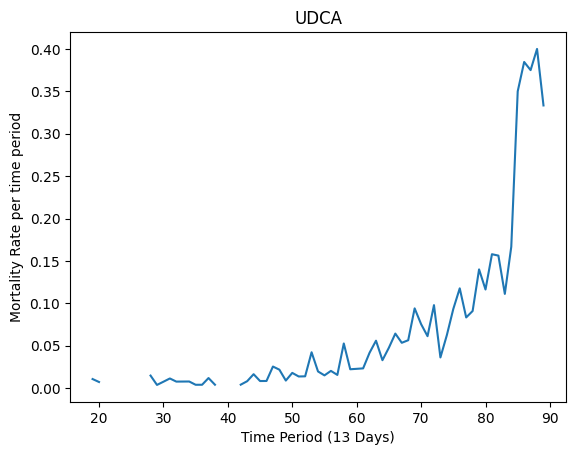

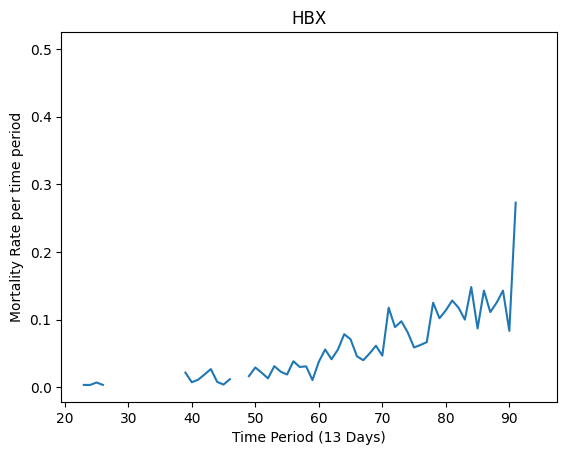

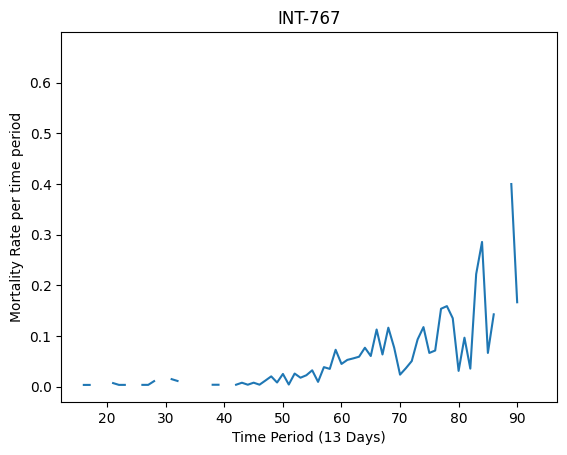

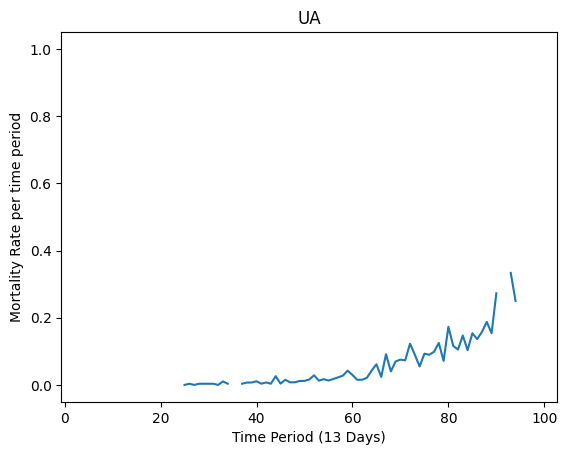

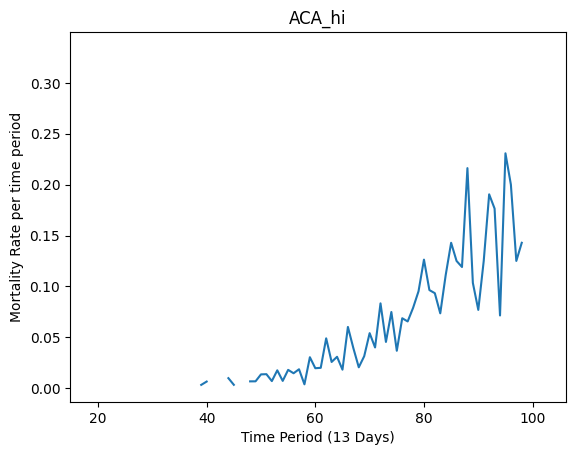

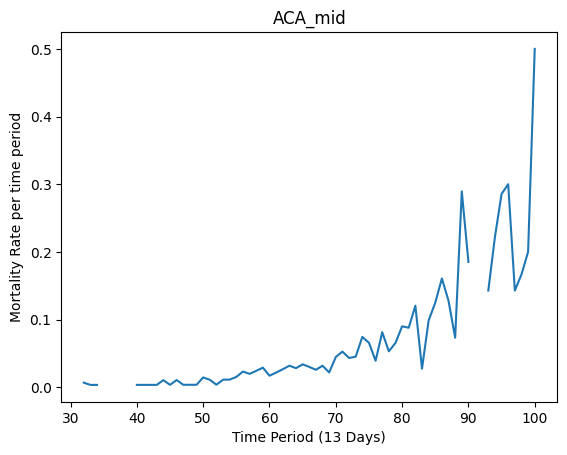

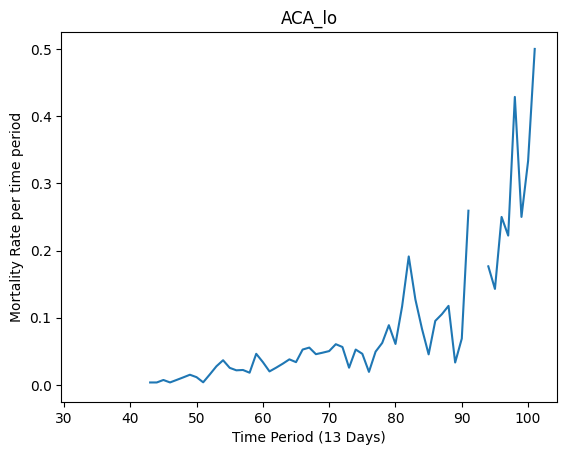

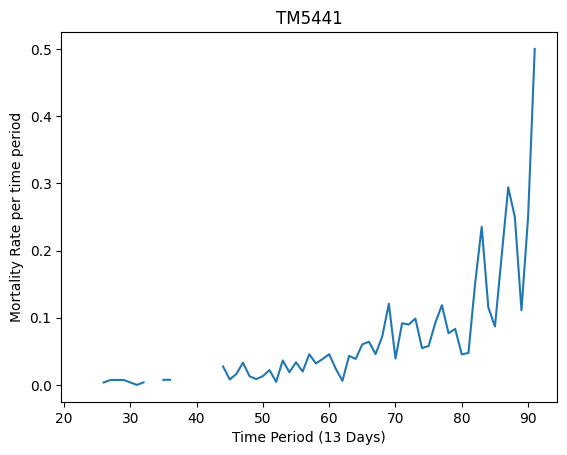

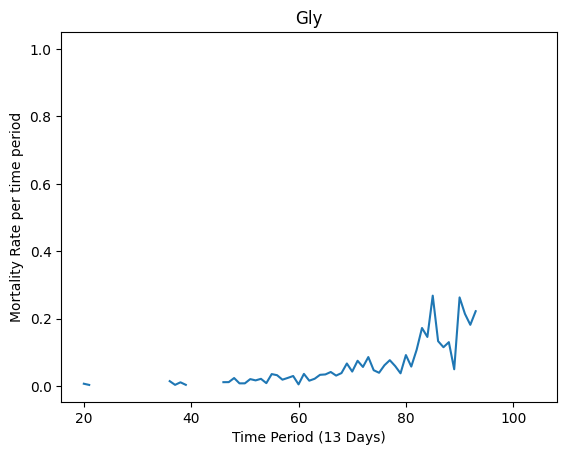

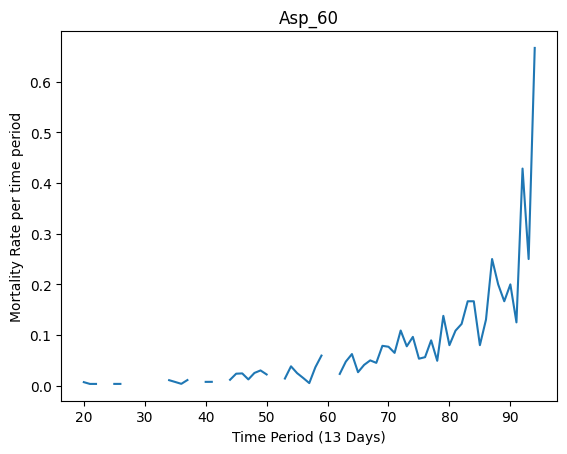

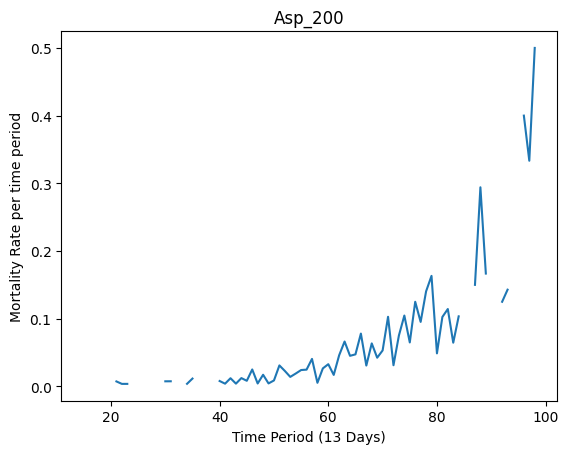

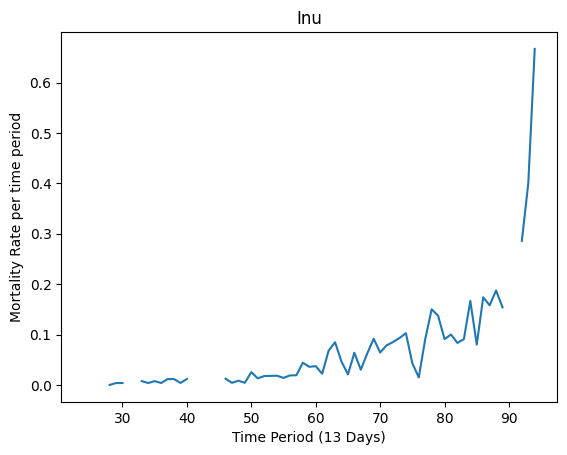

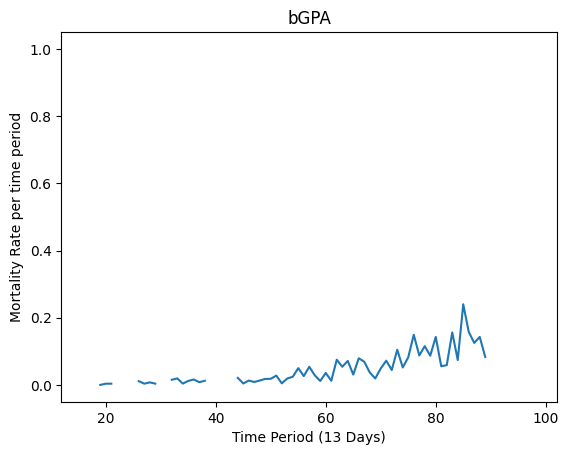

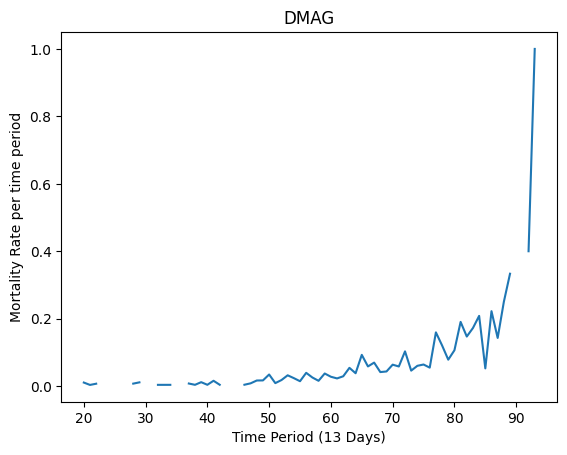

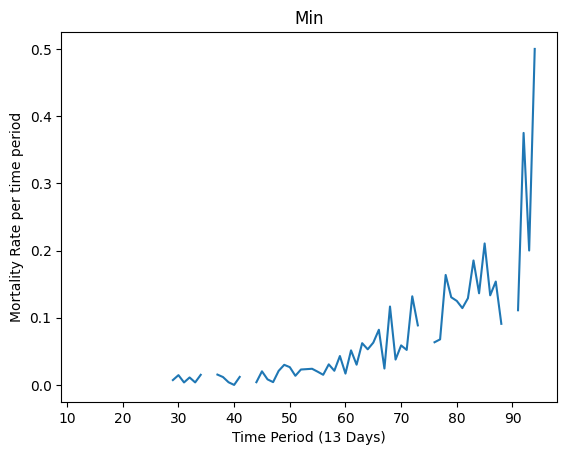

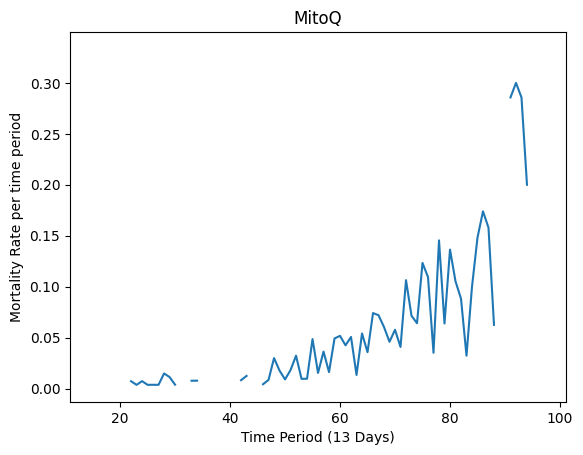

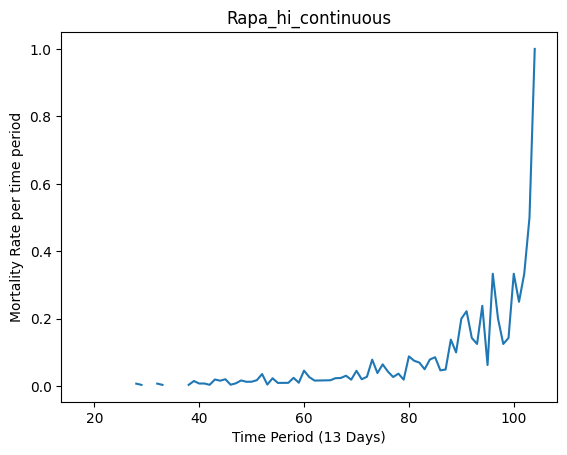

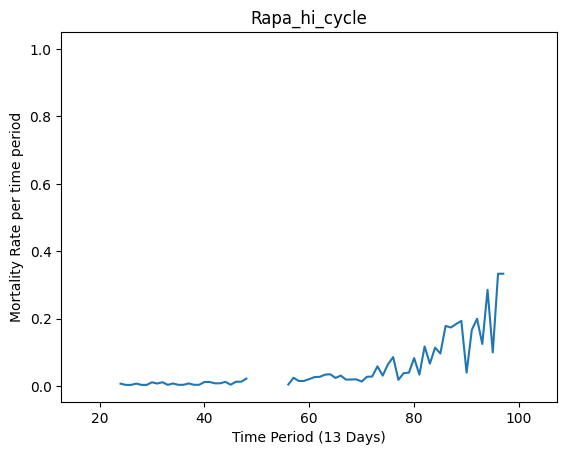

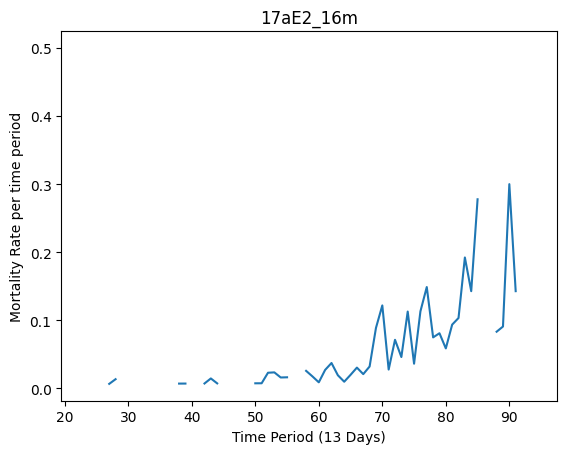

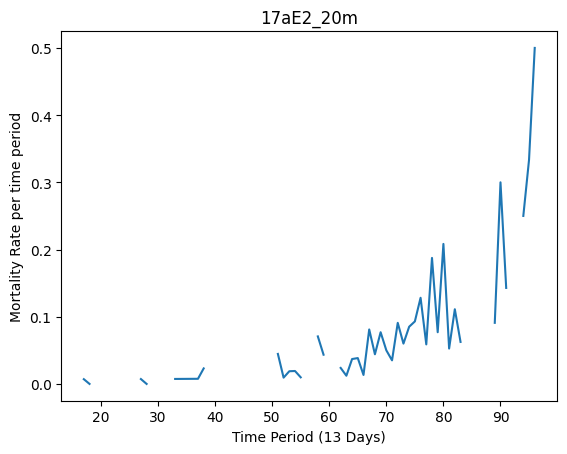

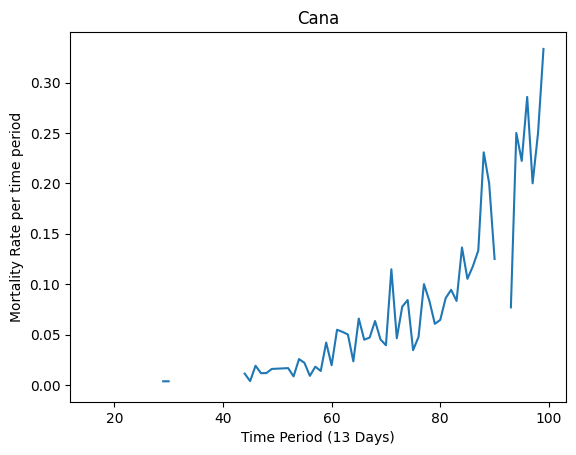

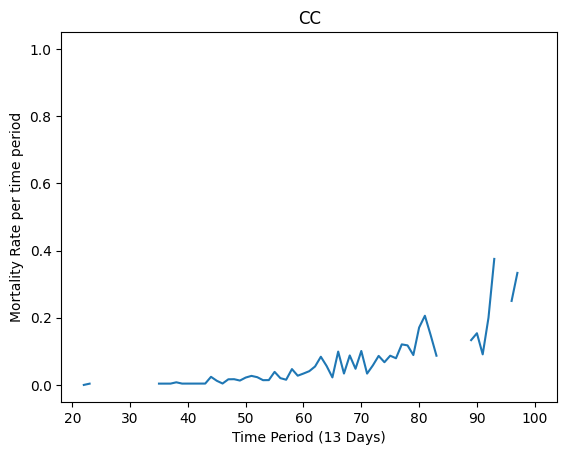

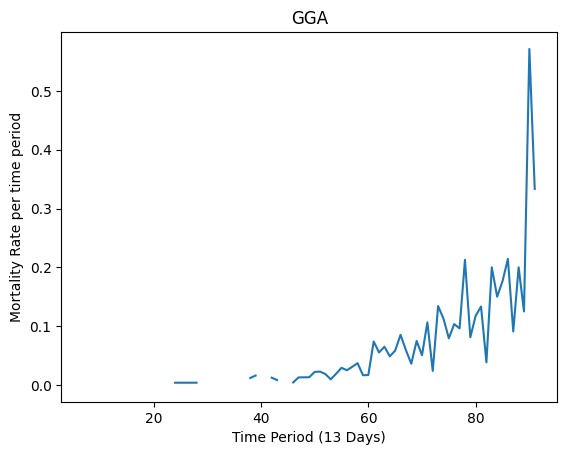

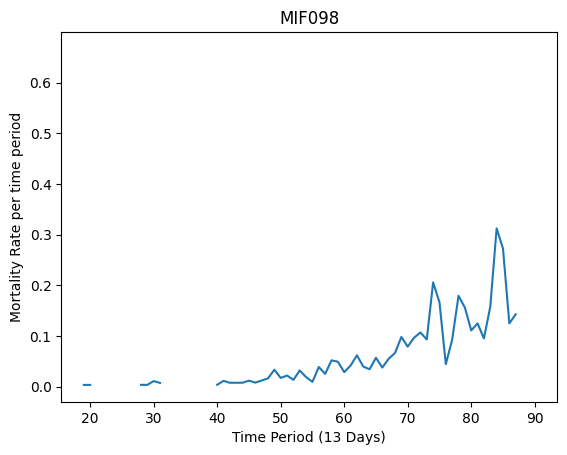

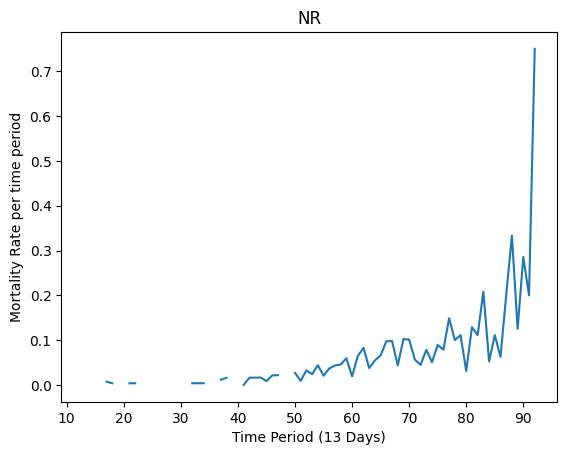

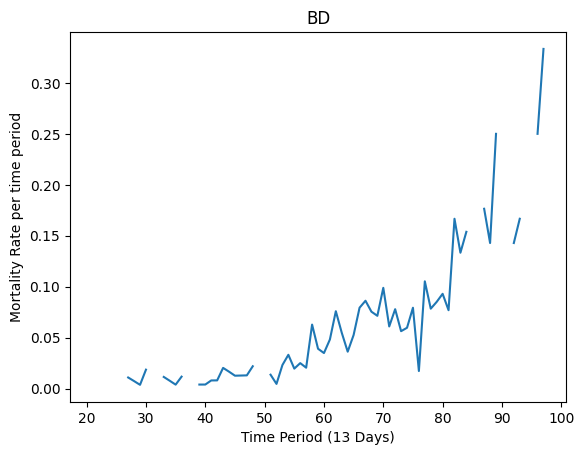

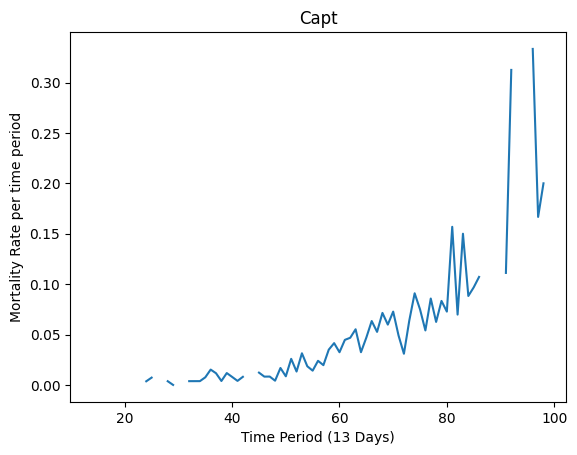

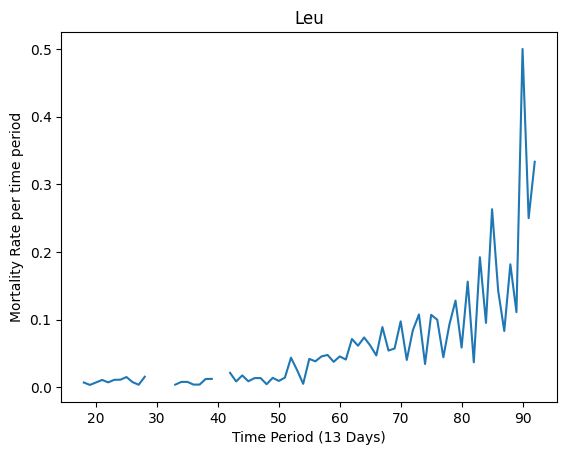

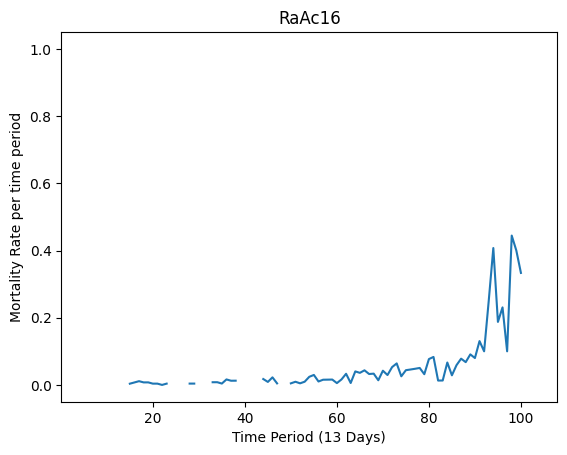

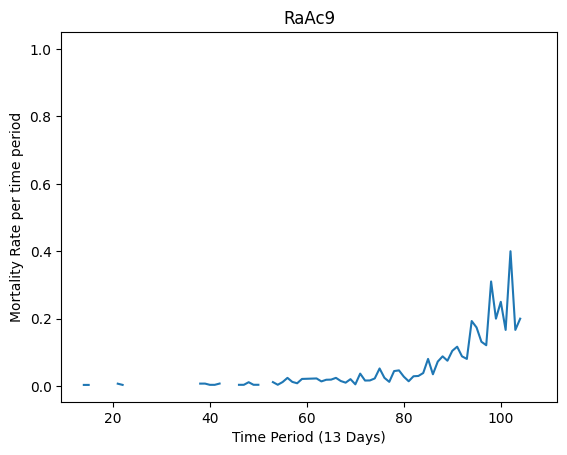

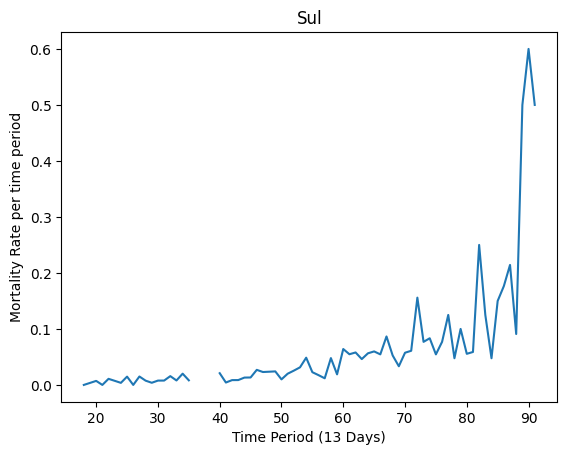

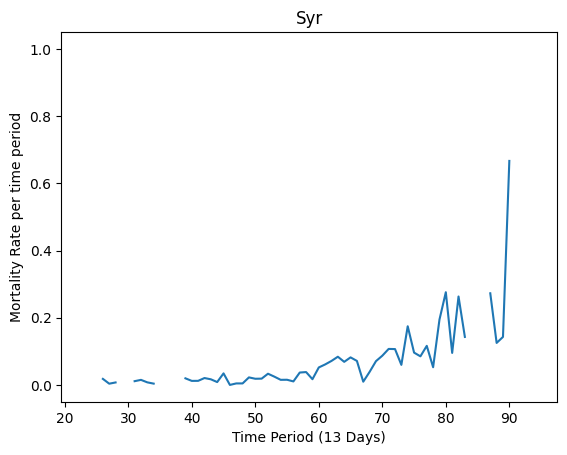

In [320]:
def graph_chance_of_death_per_time_period(chance_of_death_per_time_period: pd.DataFrame,
                                          time_period_in_days: int,
                                          title: str) -> None:
    plt.plot(chance_of_death_per_time_period)
    plt.xlabel(f'Time Period ({time_period_in_days} Days)')
    plt.ylabel(f'Mortality Rate per time period')
    plt.title(title)
    plt.show()


for group_name in chance_of_death_per_experiment.keys():
    graph_chance_of_death_per_time_period(chance_of_death_per_experiment[group_name], mouse_bin_period_in_days, group_name)

# Mouse Dataset Preprocessing (Cumulative Mortality Rate)

In contrast with the mortality rate per time period, here we consider the morality rate with respect to the initial population size. As an example, if there were 1,000 mice alive at *the start of the experiment* and 900 left at 110 days, then (1,000 - 900) / 1,000 = 10% would be the calculated chance of death. This ignores how many mice were alive initially at the start of the experiment for that particular calculation.

In [321]:
def calculate_cumulative_deaths(data):
    return data[DEATH_COLUMN].cumsum()

def compute_total_deaths(cumulative_deaths):
    return cumulative_deaths.iloc[-1]

def compute_running_mortality_percentage(data):
    cumulative_deaths = calculate_cumulative_deaths(data)
    total_deaths = compute_total_deaths(cumulative_deaths)

    if total_deaths == 0:
        raise ValueError('Invalid dataset (# of deaths must be > 0)')

    return cumulative_deaths / total_deaths

running_mortality_percentage = compute_running_mortality_percentage(control_group)
control_group.loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN] = running_mortality_percentage
control_group[[AGE_IN_DAYS_COLUMN, RUNNING_MORALITY_PERCENTAGE_COLUMN]]


running_mortality_percentage = map_over_experiments(experiment_groups, compute_running_mortality_percentage)

for experiment_name in experiment_groups.keys():
    experiment_groups[experiment_name].loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN] = running_mortality_percentage[experiment_name]

experiment_groups[CONTROL_GROUP_KEY][[AGE_IN_DAYS_COLUMN, RUNNING_MORALITY_PERCENTAGE_COLUMN]]

age(days)  cumulative deaths %
population cohort                                
UM-HET3    C2005          27             0.000000
           C2004          27             0.000136
           C2005          27             0.000136
           C2005          29             0.000136
           C2005          29             0.000136
...                      ...                  ...
           C2007        1340             0.999457
           C2014        1358             0.999593
           C2007        1359             0.999728
           C2015        1396             0.999864
           C2011        1456             1.000000

[7815 rows x 2 columns]

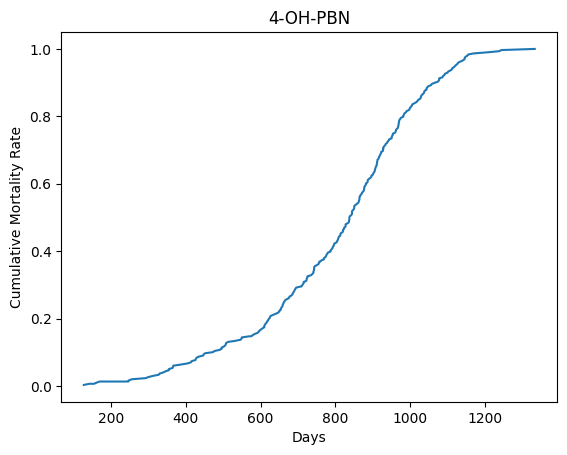

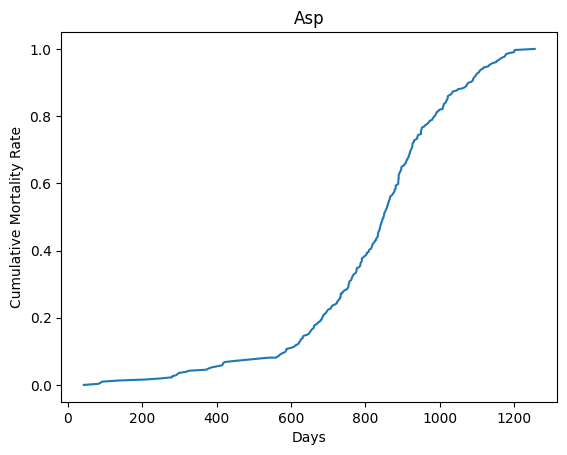

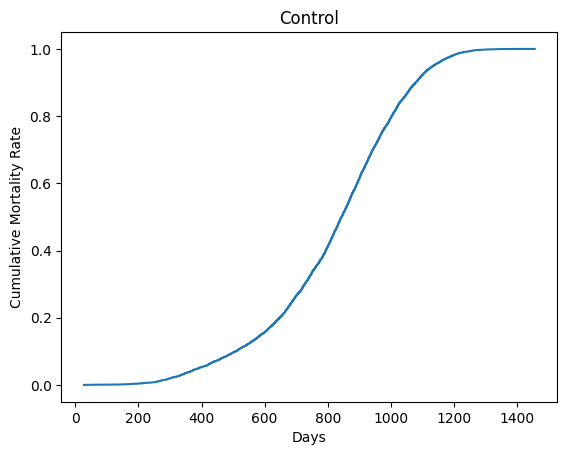

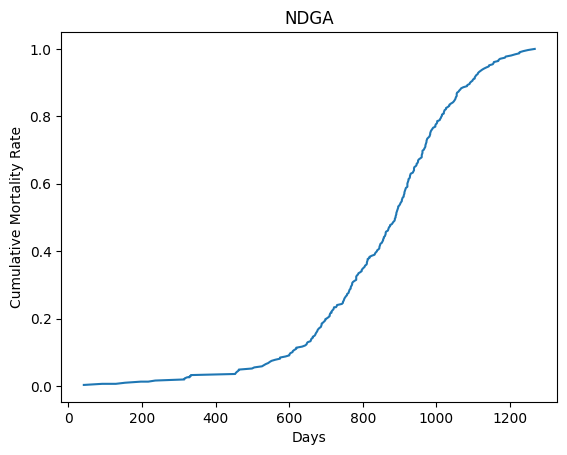

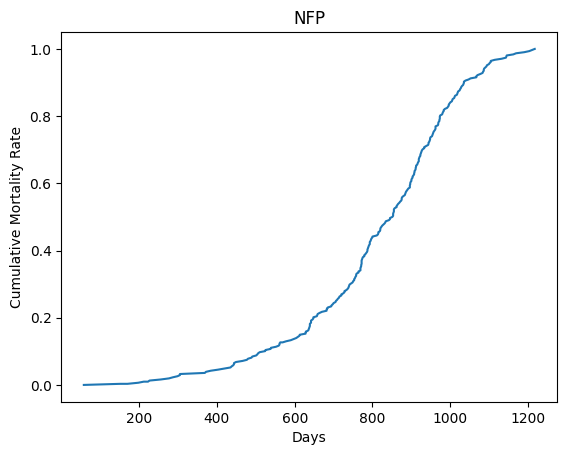

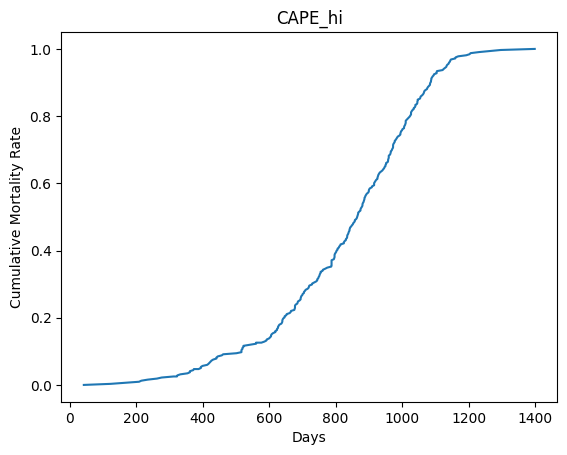

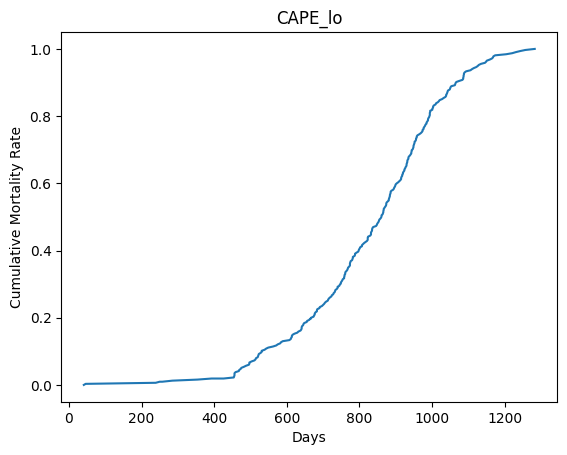

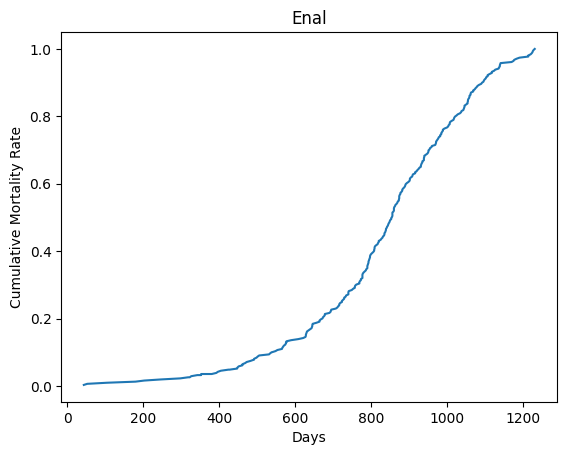

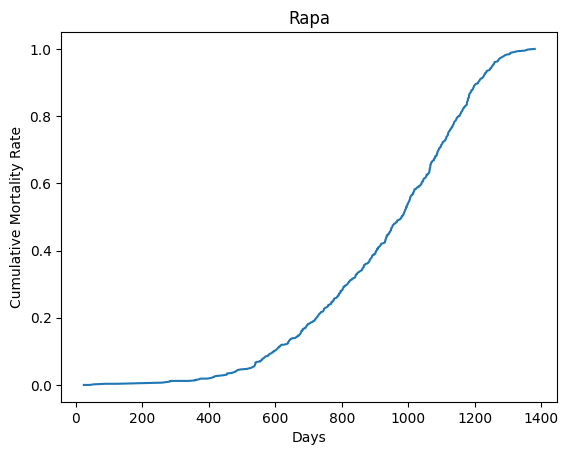

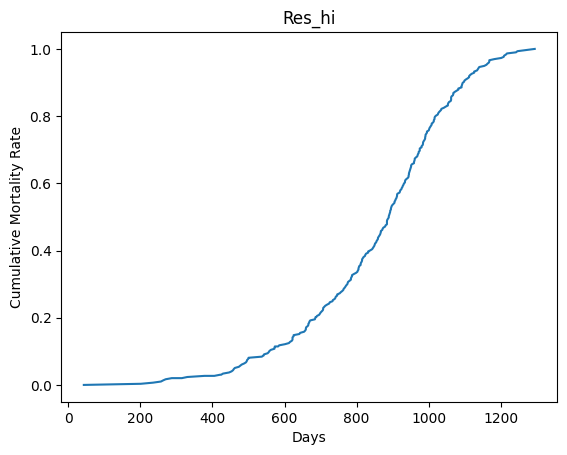

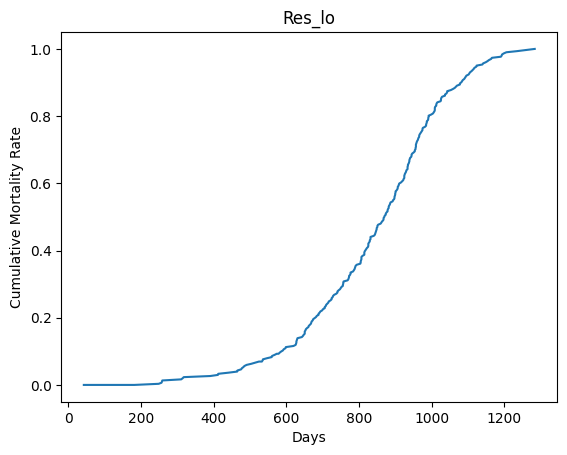

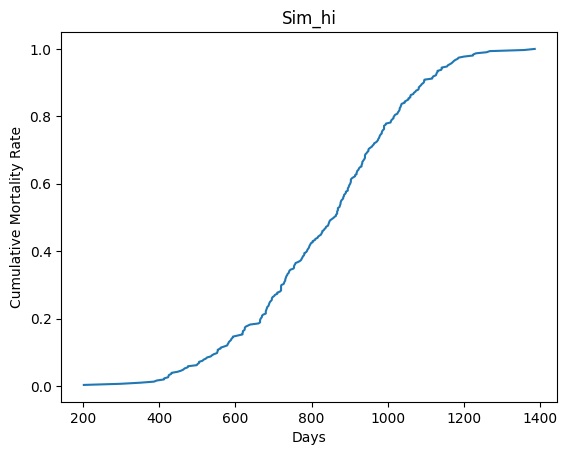

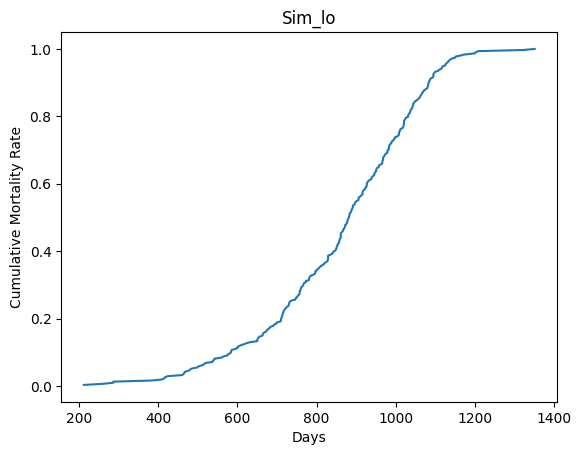

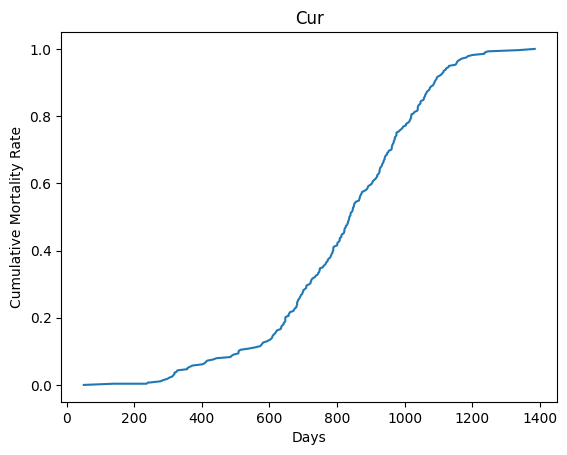

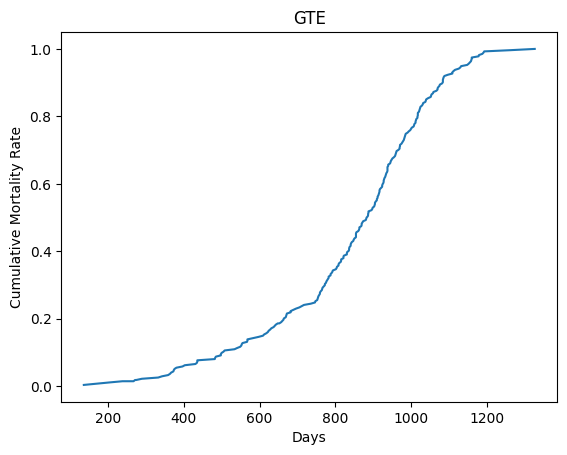

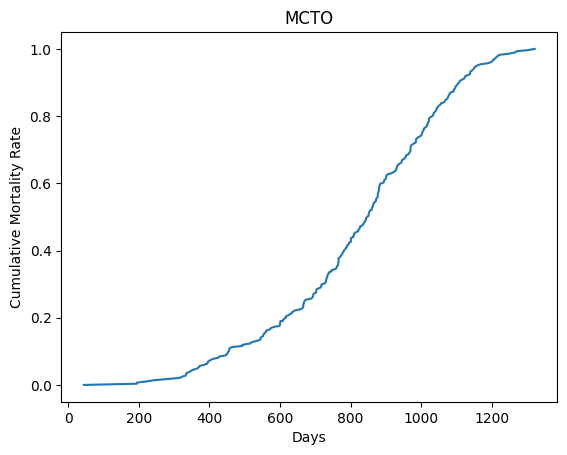

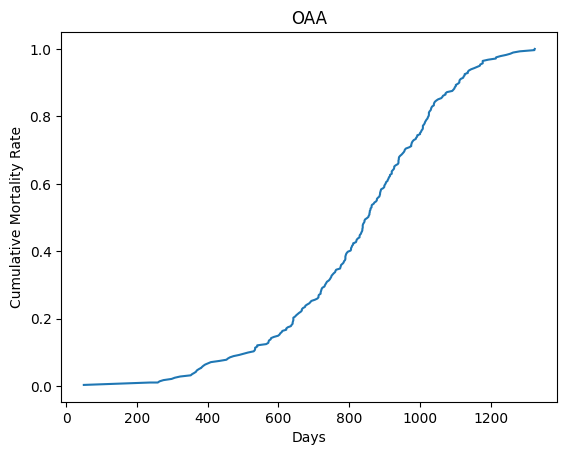

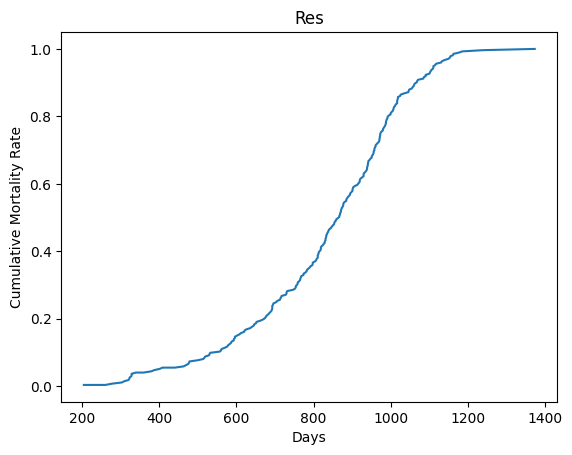

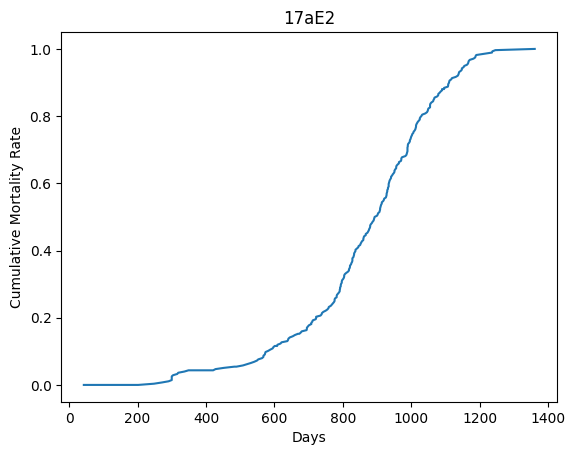

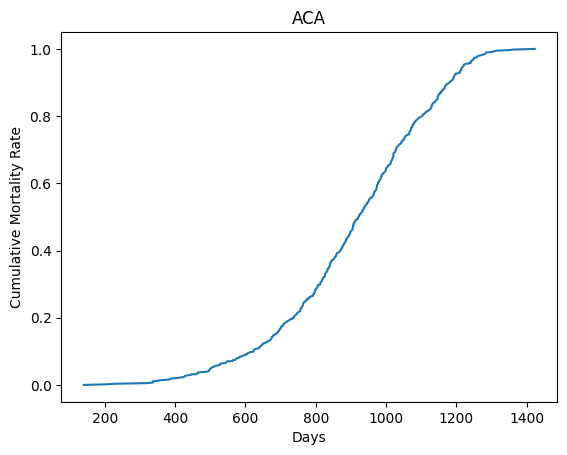

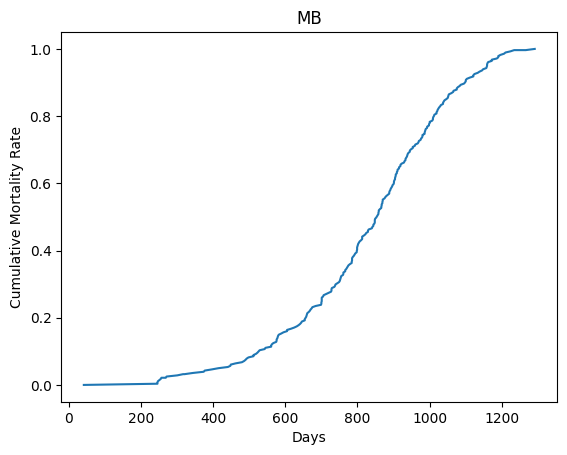

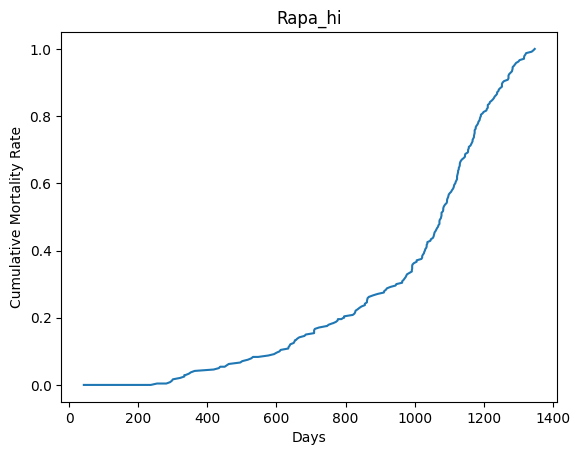

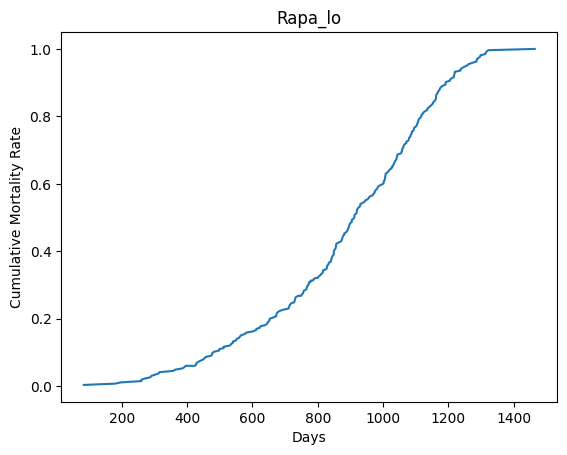

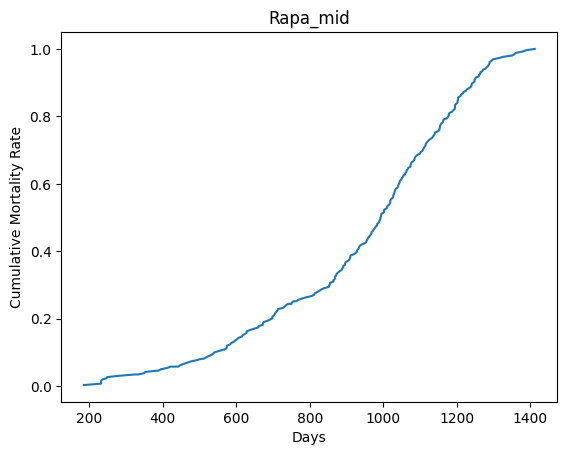

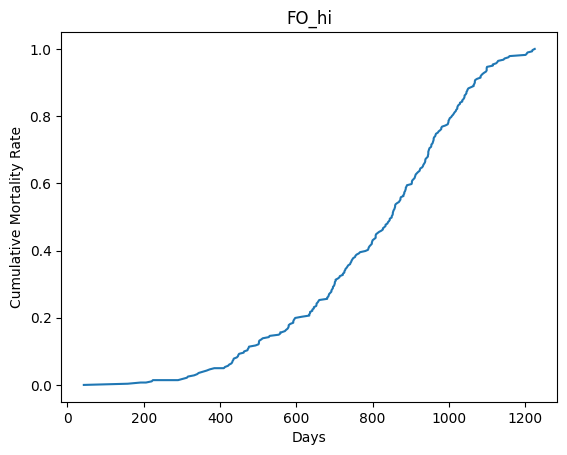

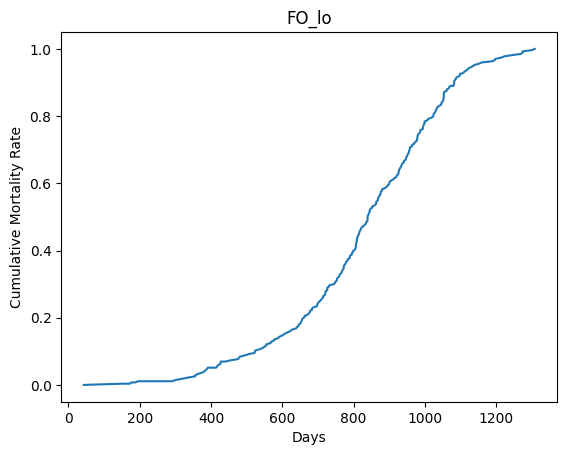

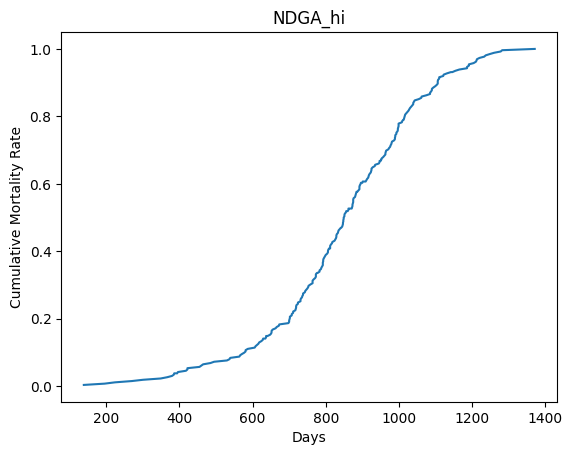

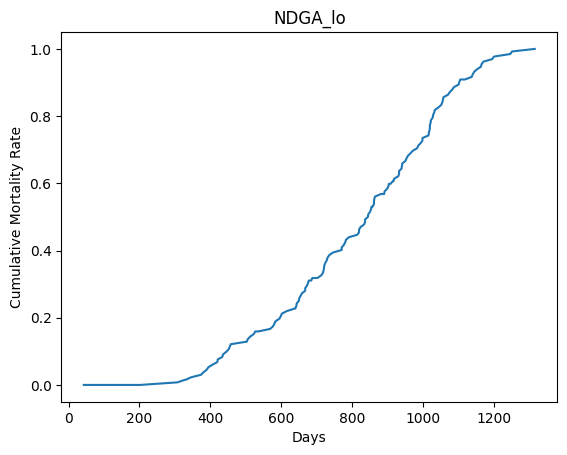

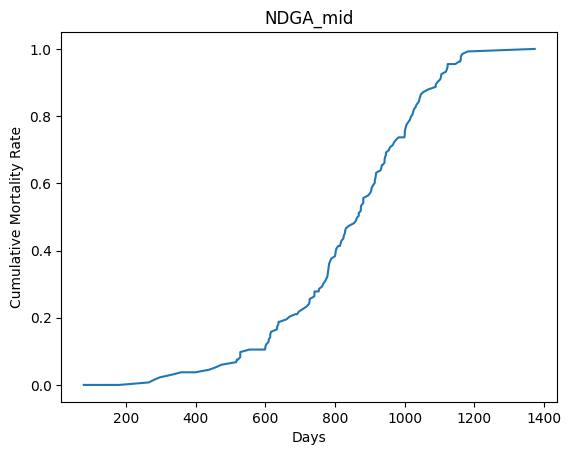

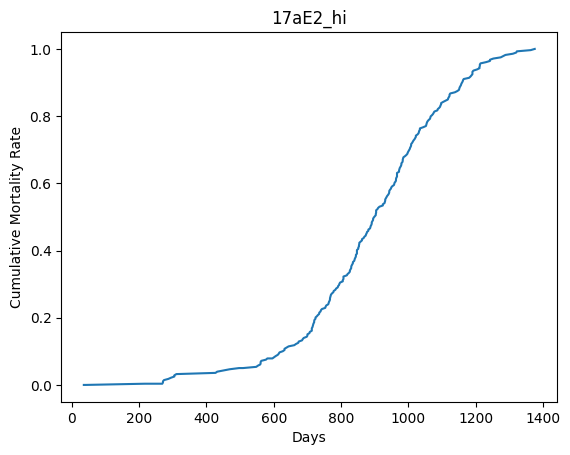

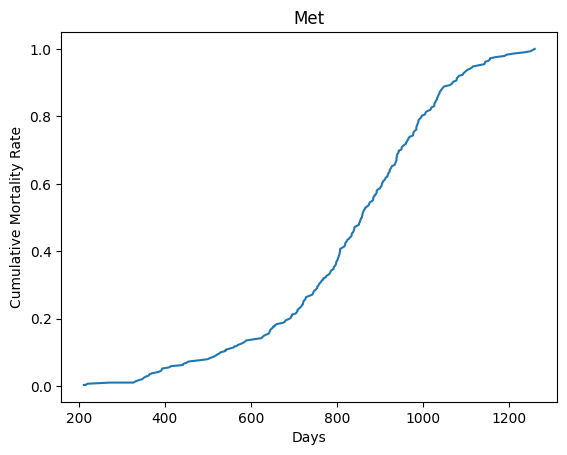

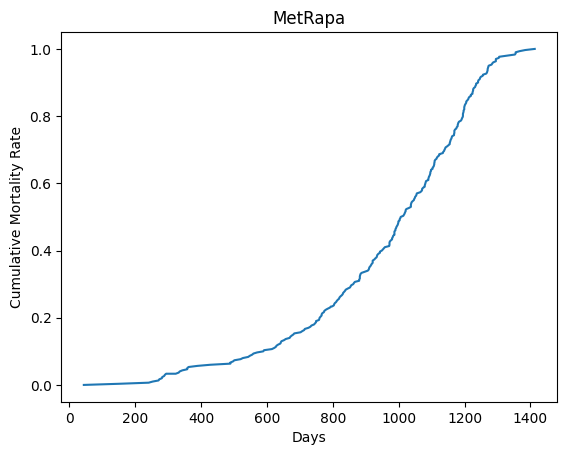

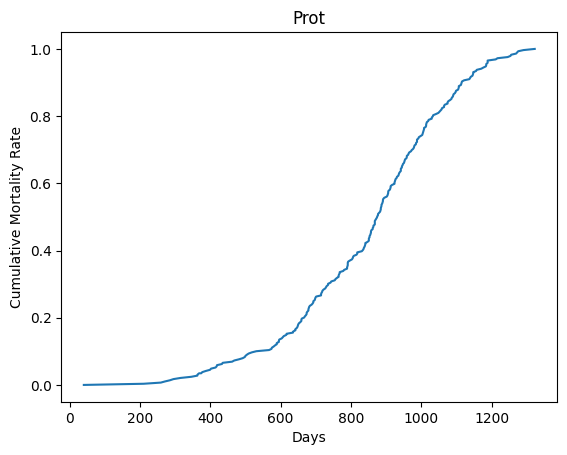

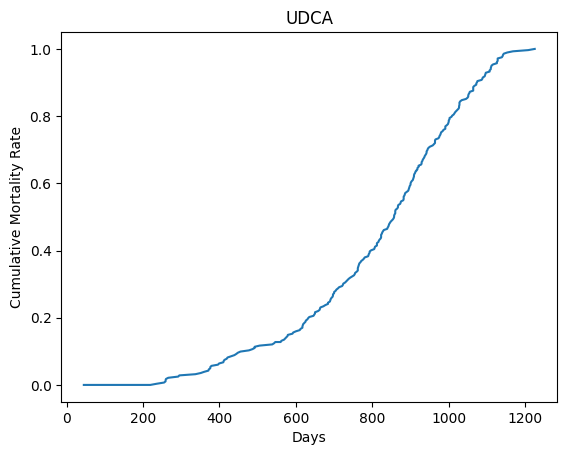

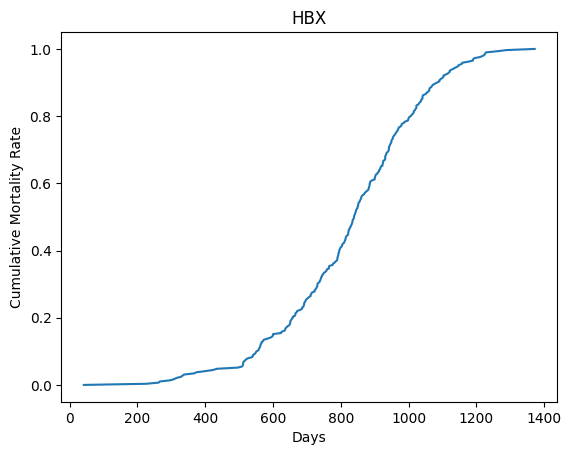

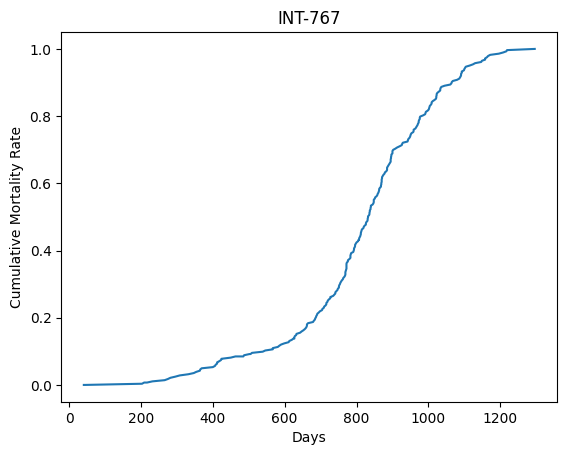

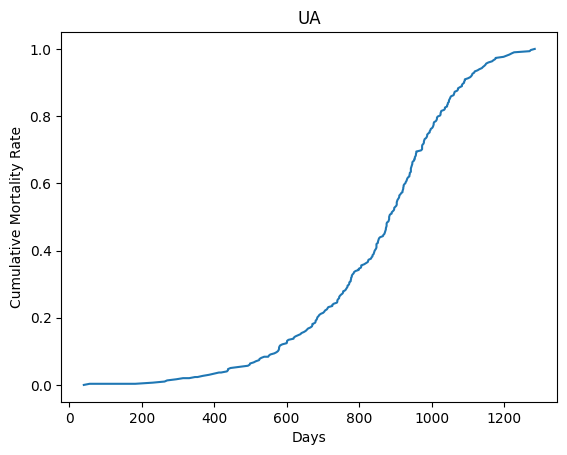

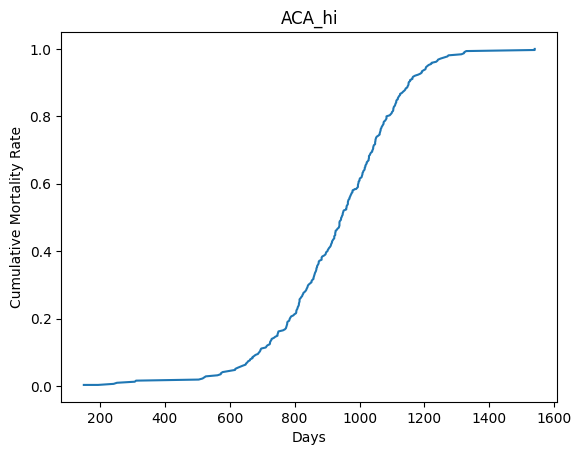

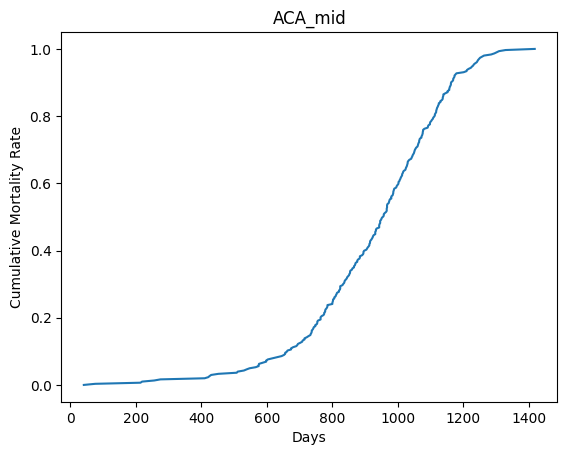

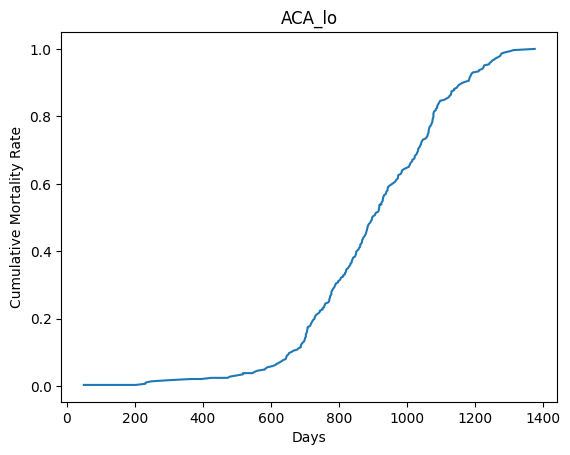

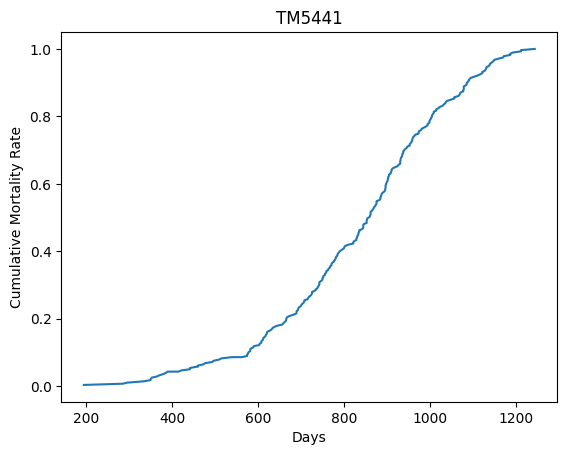

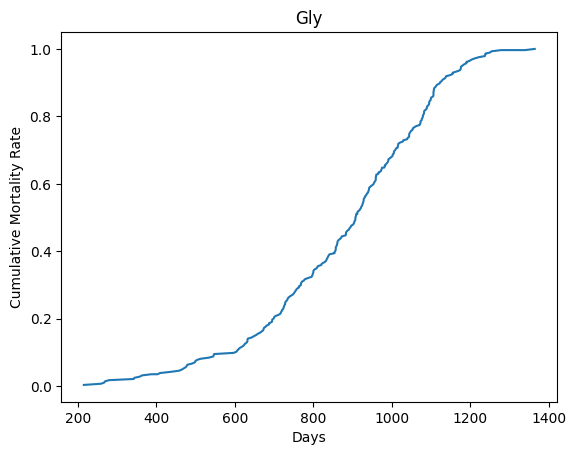

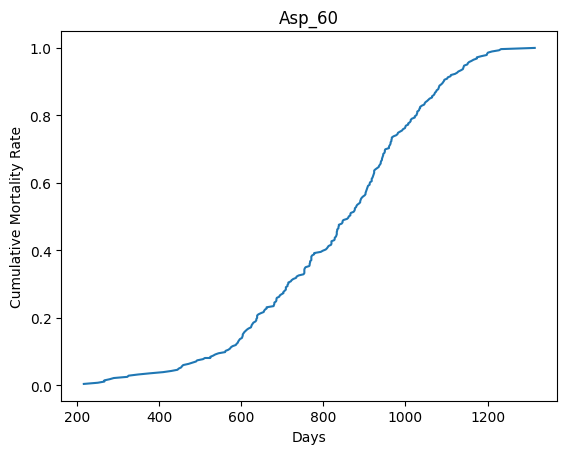

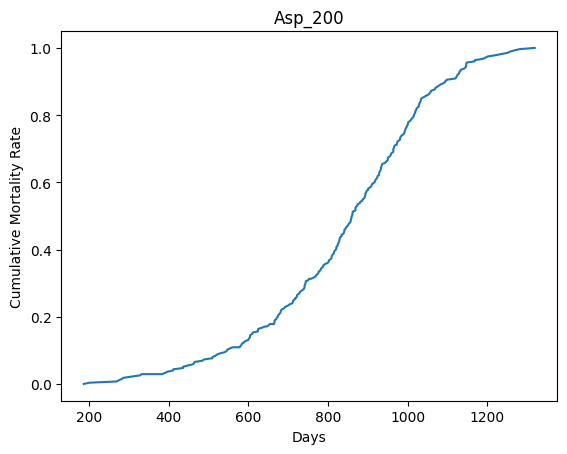

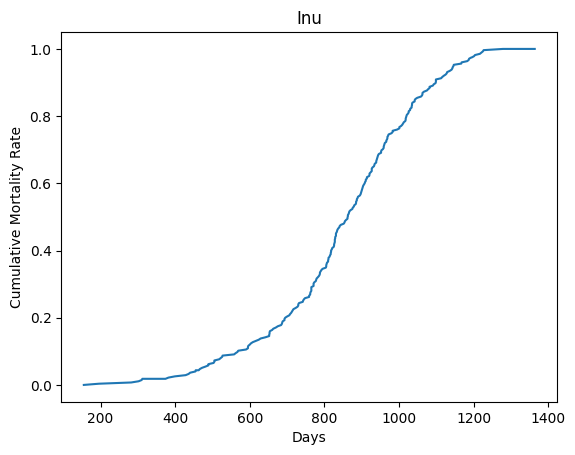

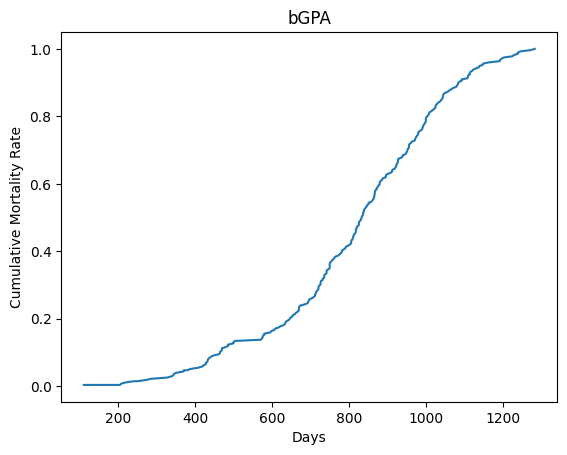

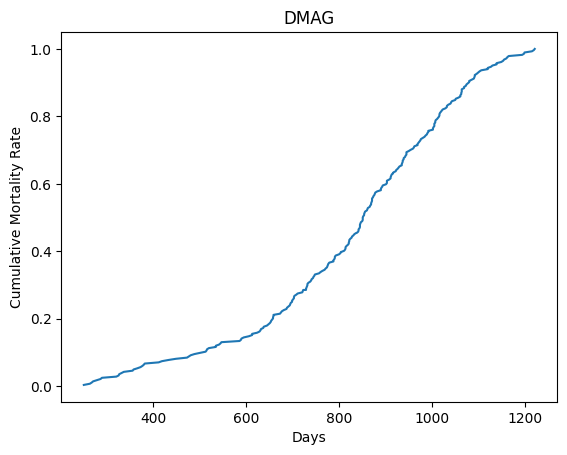

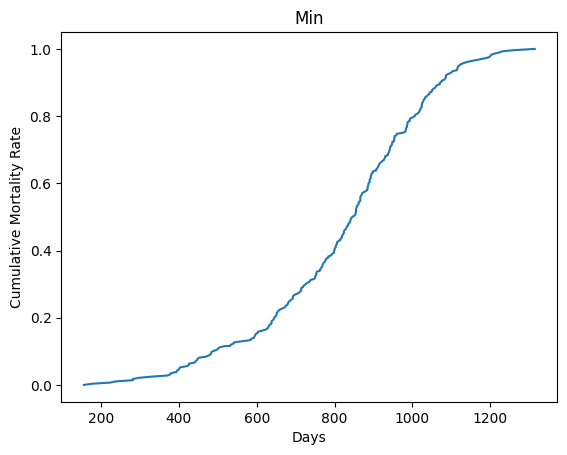

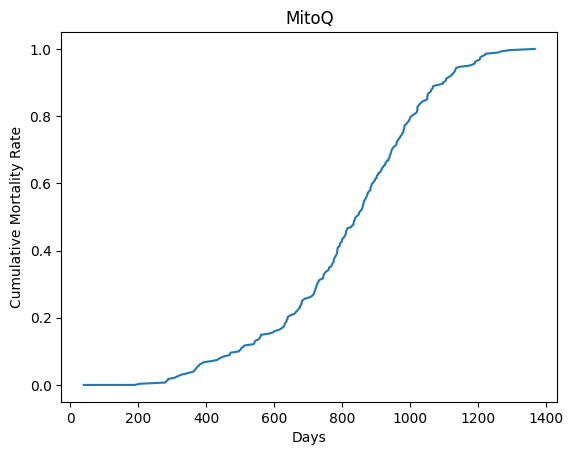

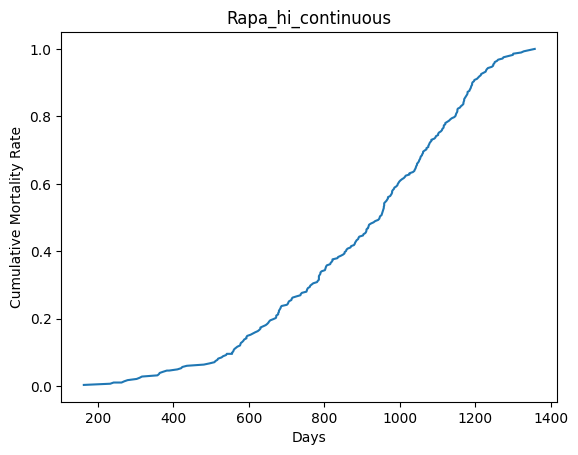

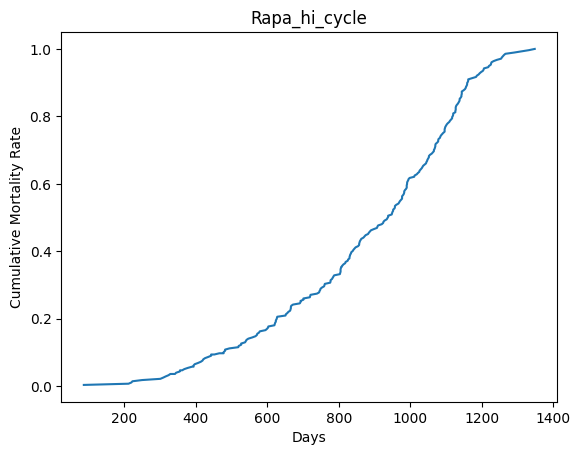

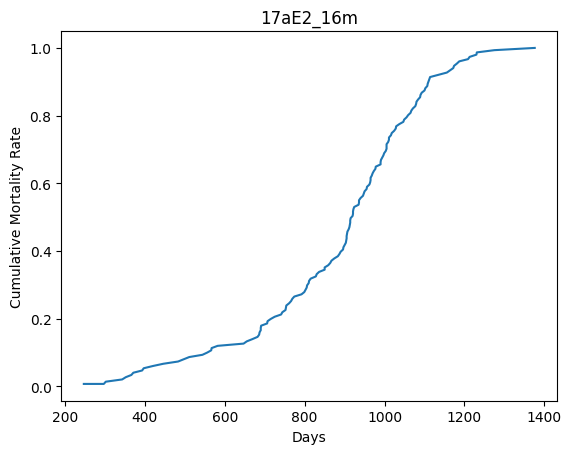

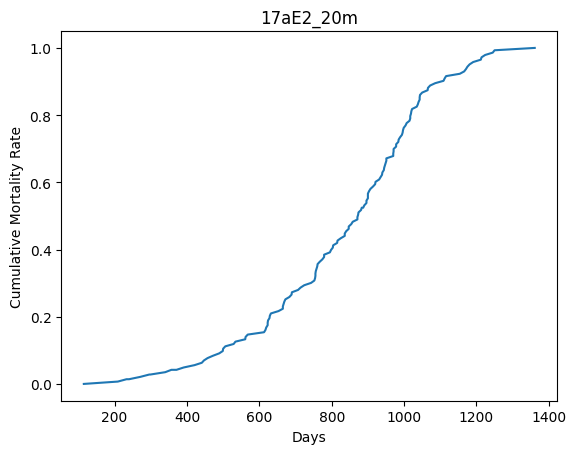

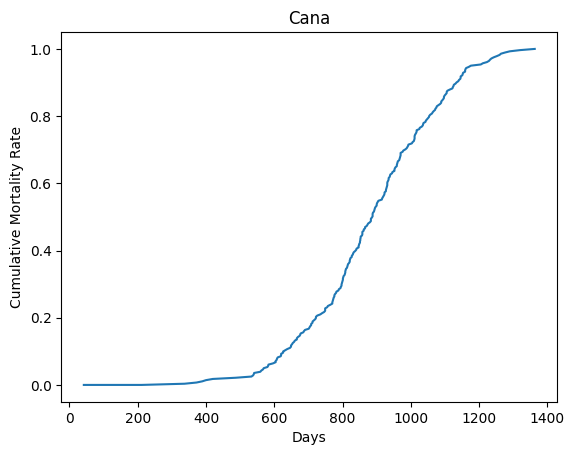

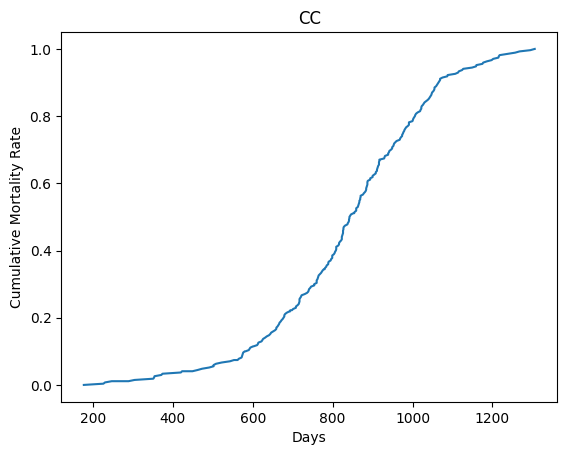

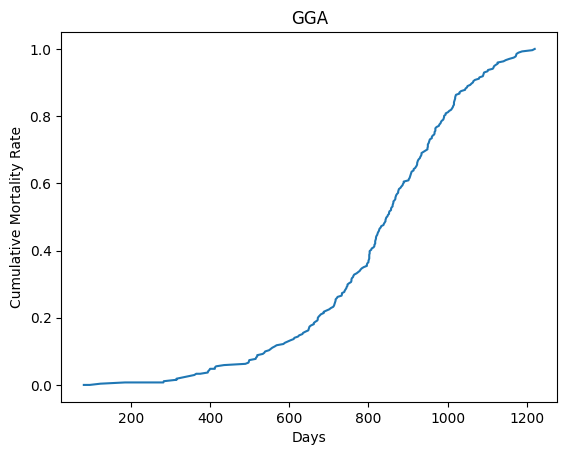

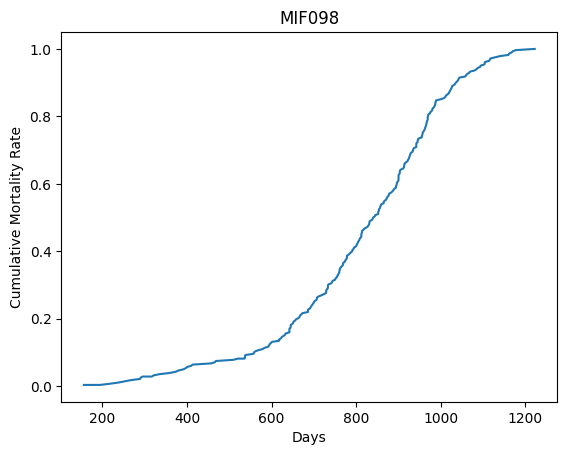

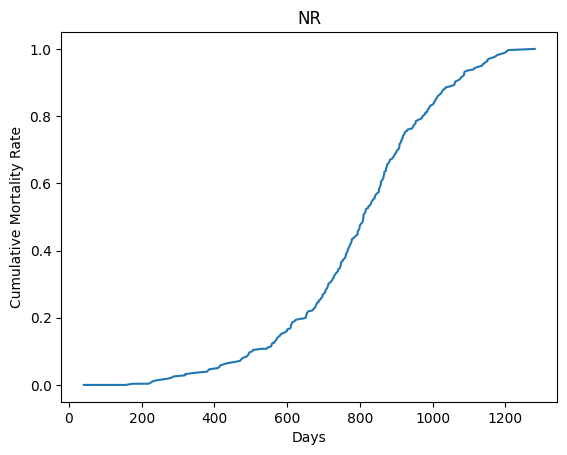

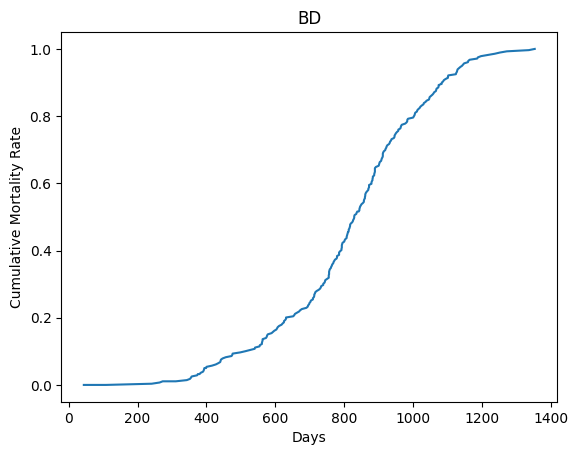

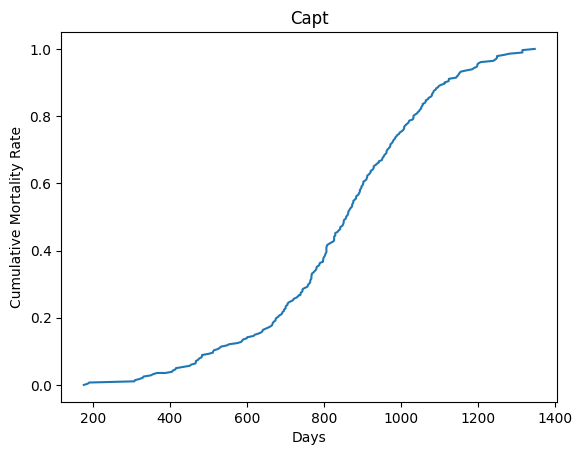

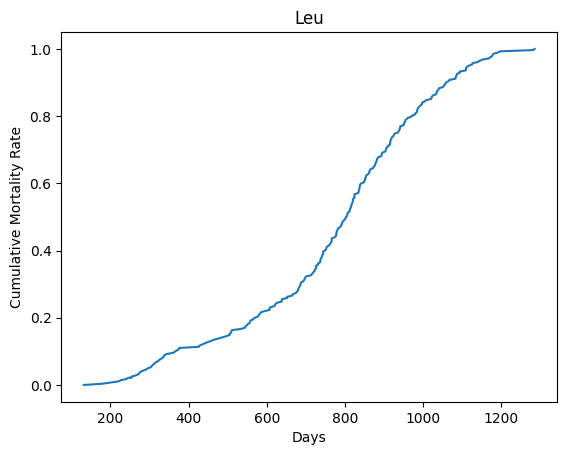

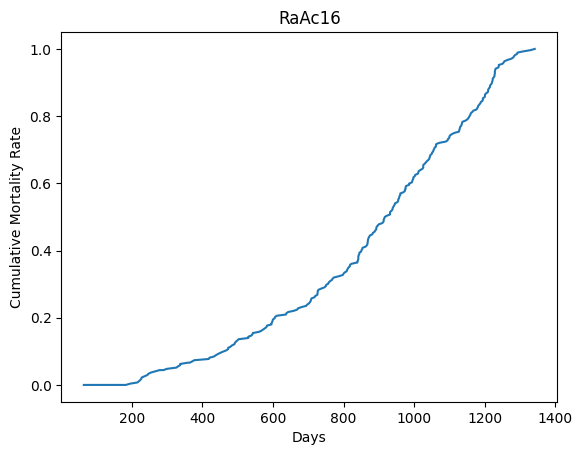

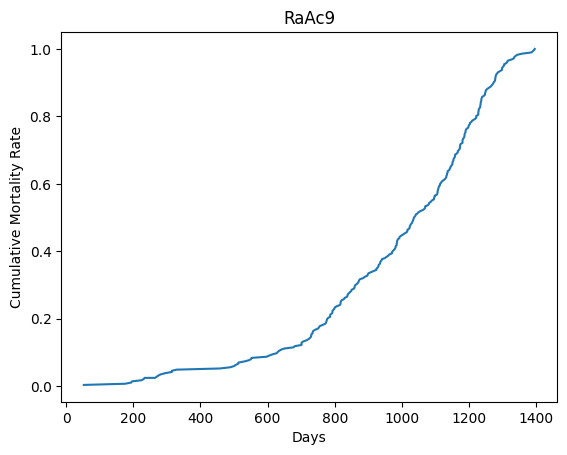

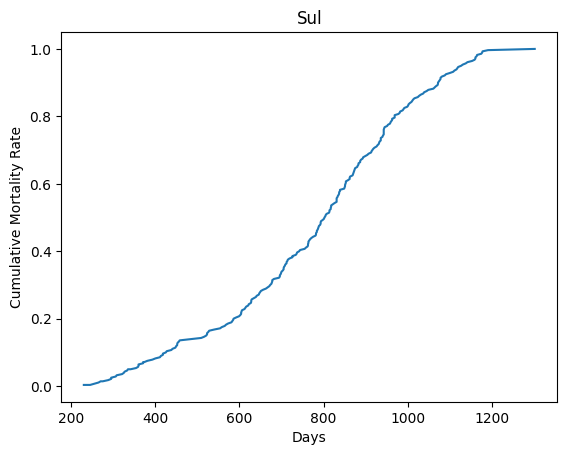

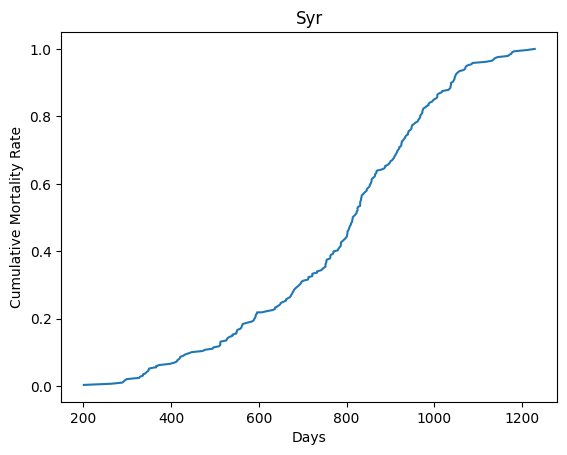

In [322]:
def graph_running_mortality_percentage(age_in_days: pd.DataFrame,
                                       running_mortality_percentage: pd.DataFrame,
                                       title: str) -> None:
    plt.plot(age_in_days, running_mortality_percentage)
    plt.xlabel('Days')
    plt.ylabel('Cumulative Mortality Rate')
    plt.title(title)
    plt.show()

for experiment_name, experiment_group in experiment_groups.items():
    age_in_days = experiment_group.loc[:, AGE_IN_DAYS_COLUMN]
    running_mortality_rate = experiment_group.loc[:, RUNNING_MORALITY_PERCENTAGE_COLUMN]
    graph_running_mortality_percentage(age_in_days, running_mortality_rate, title=experiment_name)

# Gompertz Model

We use a Gompertz curve to fit the data with the assumption it follows the Gompertz-Makeham Law of Mortality. Refer to the link below for more details: [Gompertz–Makeham law of mortality](https://en.wikipedia.org/wiki/Gompertz%E2%80%93Makeham_law_of_mortality)

In [323]:
def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)

@dataclass
class GompertzParameters:
    alpha: np.float64
    beta: np.float64

    @staticmethod
    def from_sequence(seq):
        return GompertzParameters(alpha=seq[0], beta=seq[1])

    def to_tuple(self):
        return (self.alpha, self.beta)

    def __str__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'

    def __repr__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'


def fit_gompertz_model(initial_parameters: GompertzParameters,
                       ages: pd.DataFrame,
                       mortality_rate: pd.DataFrame,
                       max_fit_iterations: int = 2_500) -> GompertzParameters:
    p0 = initial_parameters.to_tuple()
    predicted_parameters, covariance = curve_fit(gompertz, ages, mortality_rate, p0=p0, maxfev=max_fit_iterations)
    return GompertzParameters.from_sequence(predicted_parameters)

# Mortality Graphs

In [324]:
def population_at_daystart(data: pd.DataFrame) -> pd.DataFrame:
    total_population = calculate_total(data)
    population_at_start_of_day = (total_population) - data.cumsum()
    population_at_start_of_day = population_at_start_of_day.shift(1)
    population_at_start_of_day.loc[population_at_start_of_day.index.values[0]] = total_population
    return population_at_start_of_day.rename(columns={"dead": "Population"})

def calculate_mortality_rates(dead_counts: pd.DataFrame, population_data: pd.DataFrame) -> pd.DataFrame:
    return dead_counts['dead'] / population_data['Population']

def remove_days_without_deaths(data: pd.DataFrame) -> pd.DataFrame:
    return data[(data[["dead"]] != 0).all(axis=1)]

def graph_log_mortality_rate(experiment_group: pd.DataFrame, time_period_in_days: int, title: str):
    dead_counts = remove_days_without_deaths(group_ages(experiment_group, time_period_in_days))
    population_data = population_at_daystart(dead_counts)
    mortality_rate = calculate_mortality_rates(dead_counts, population_data)
    mortality_rate.apply(lambda x: np.log(x)).plot(style='.')
    plt.xlabel("Age")
    plt.ylabel("Mortality Rate")
    plt.title(f"Log Mortality Rate ({title})")
    plt.show()

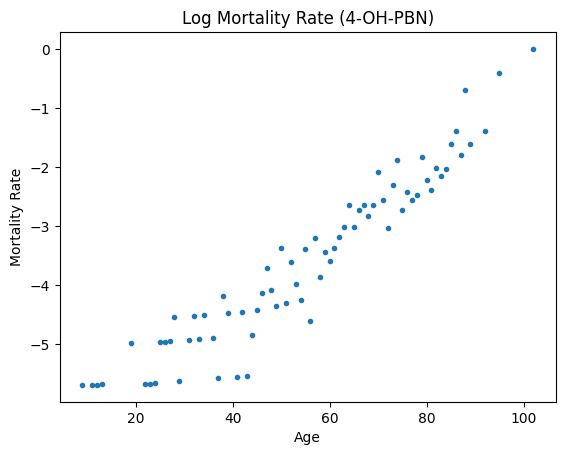

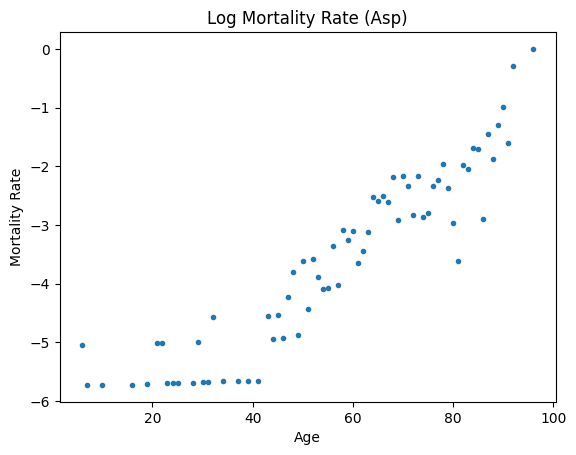

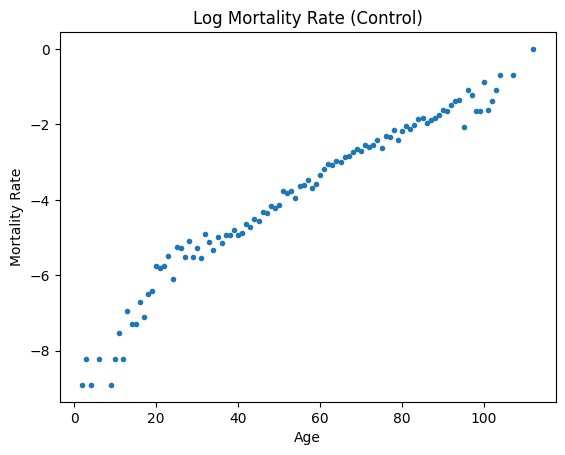

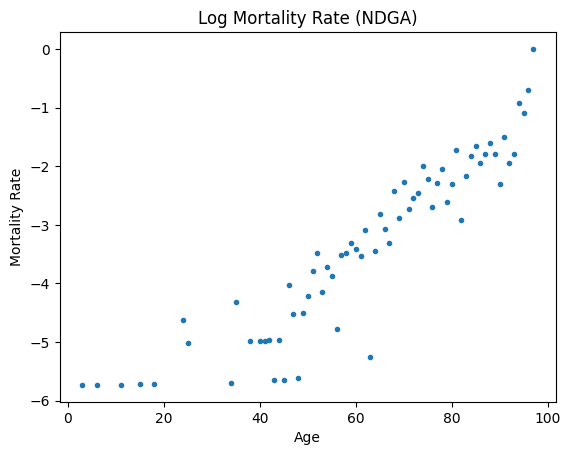

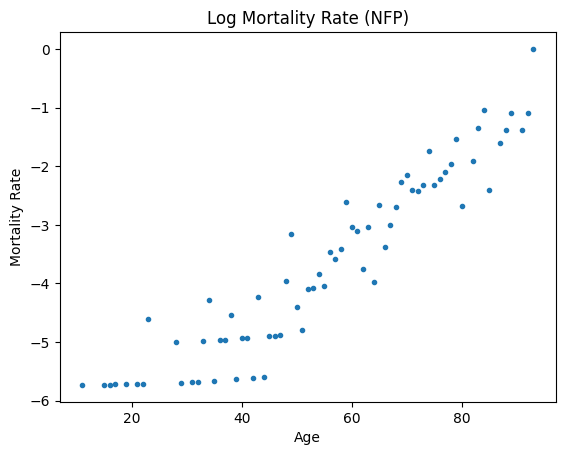

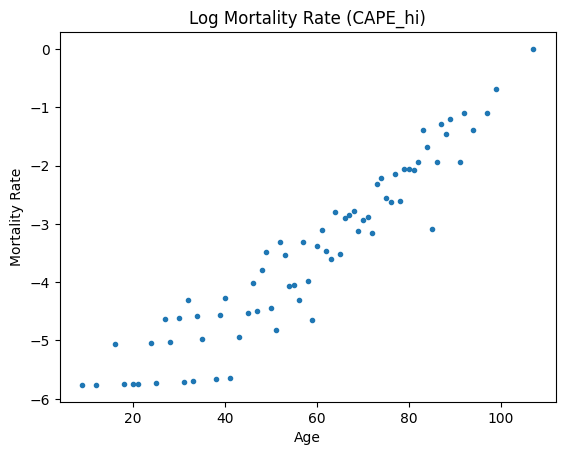

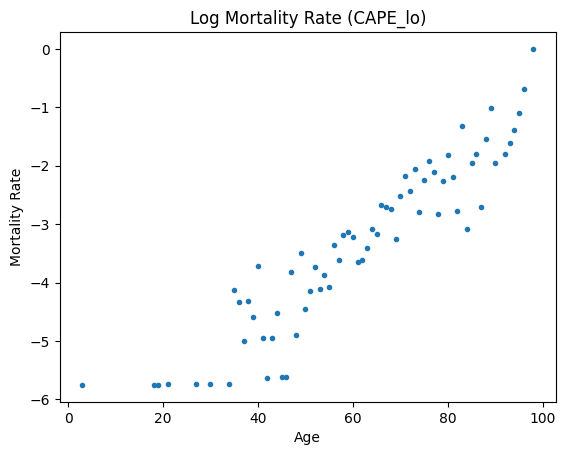

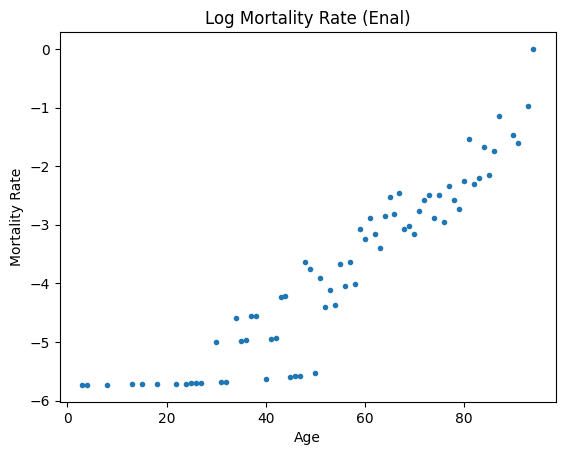

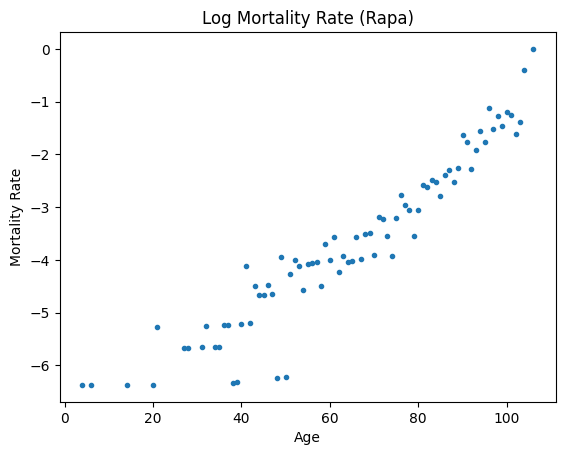

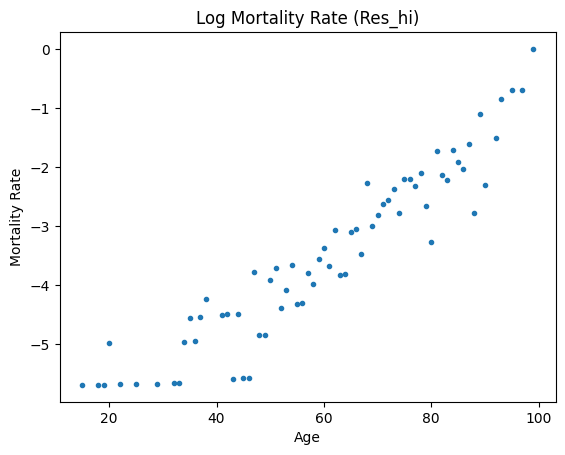

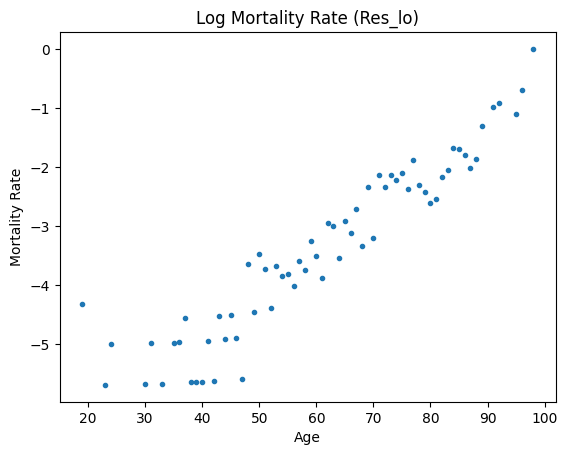

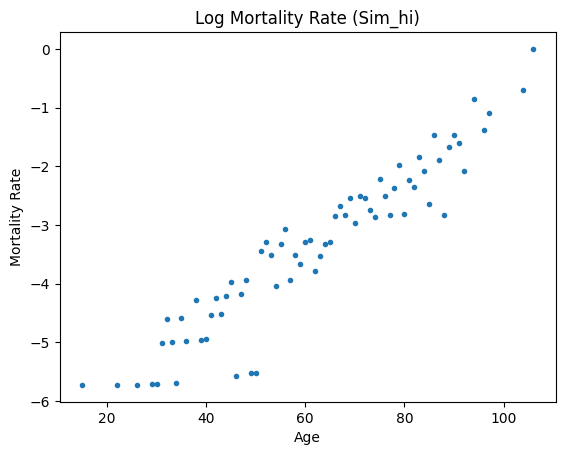

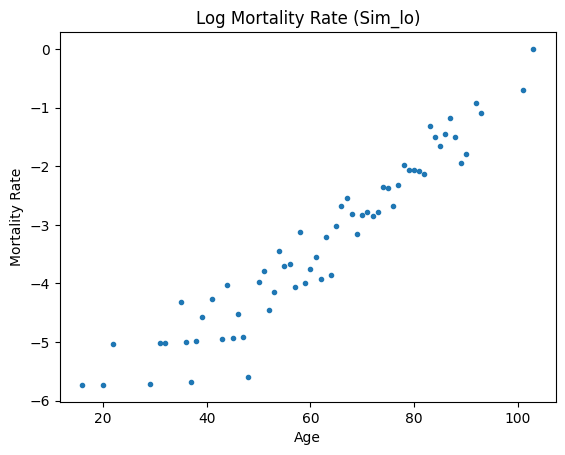

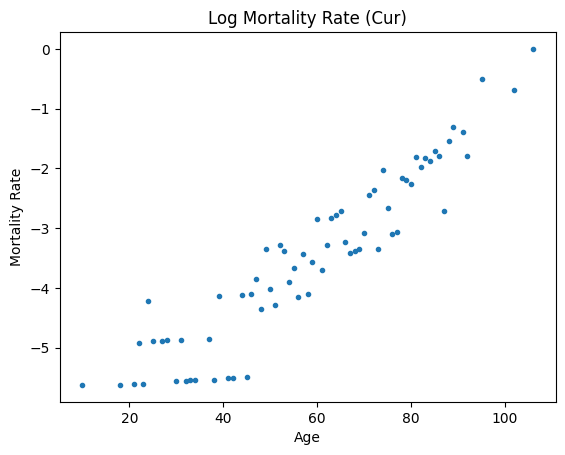

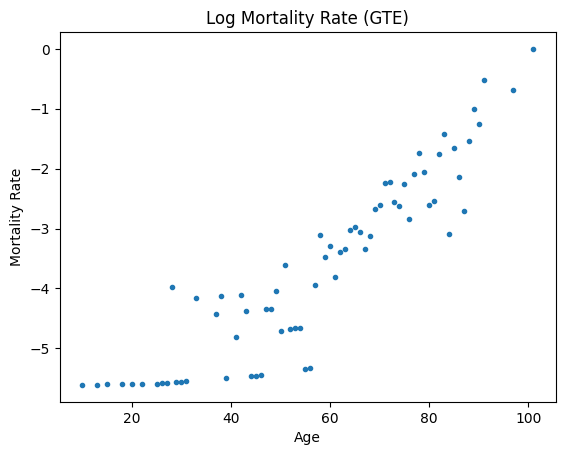

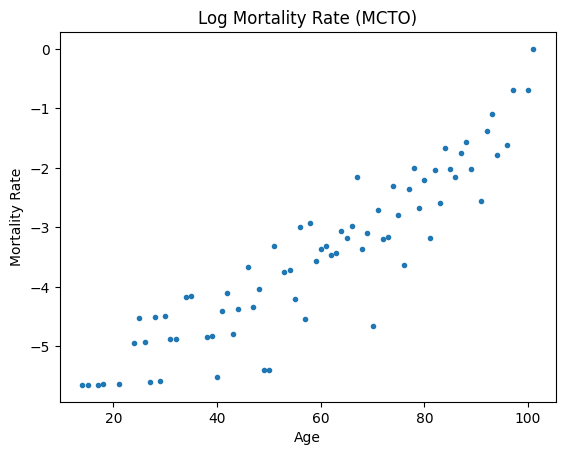

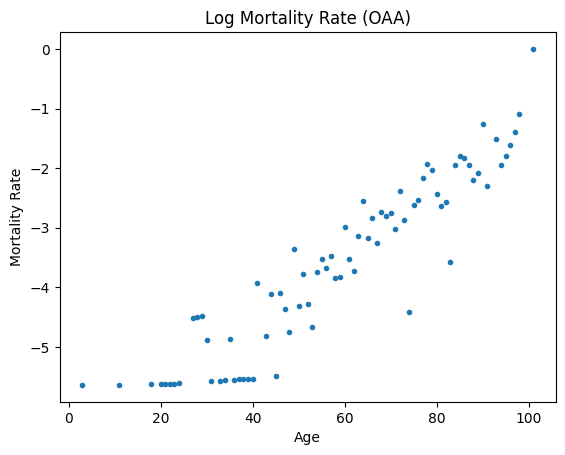

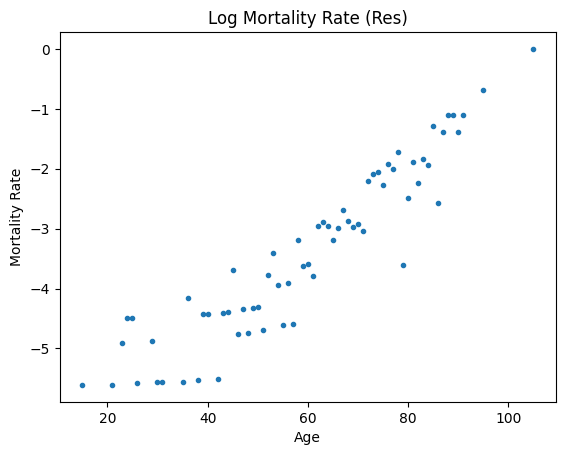

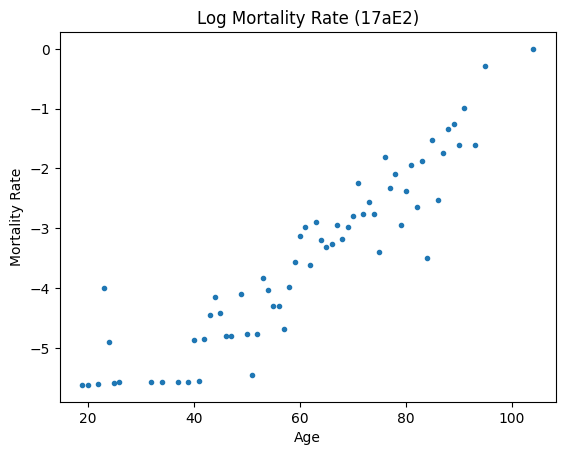

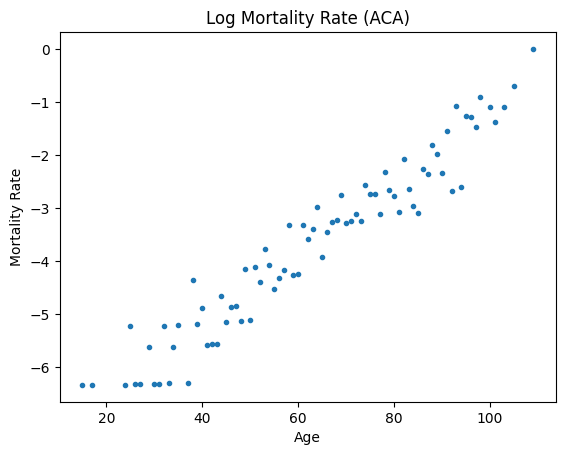

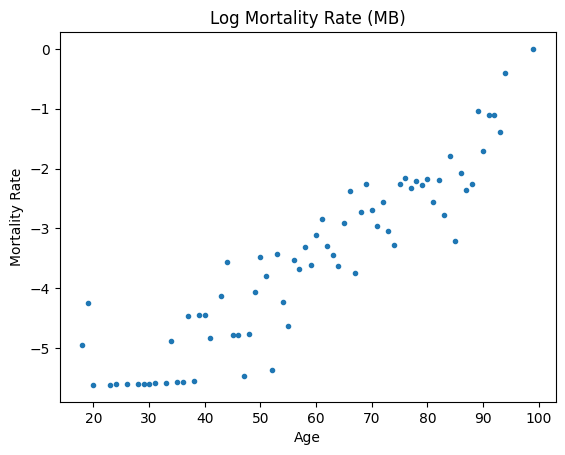

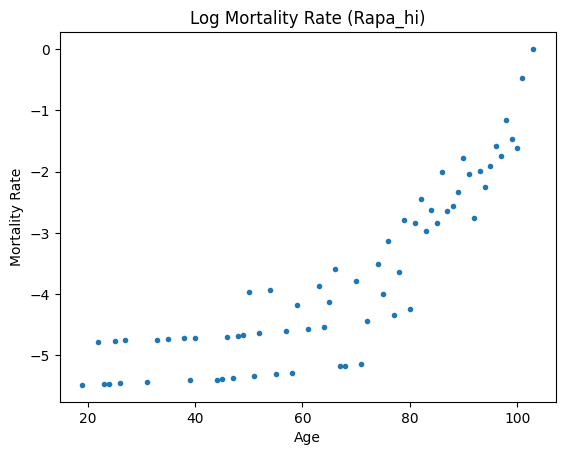

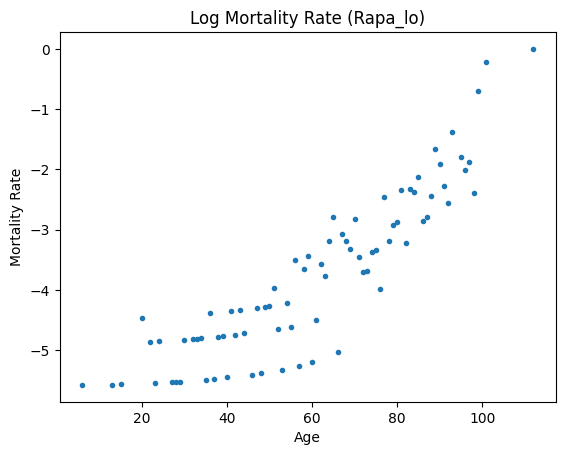

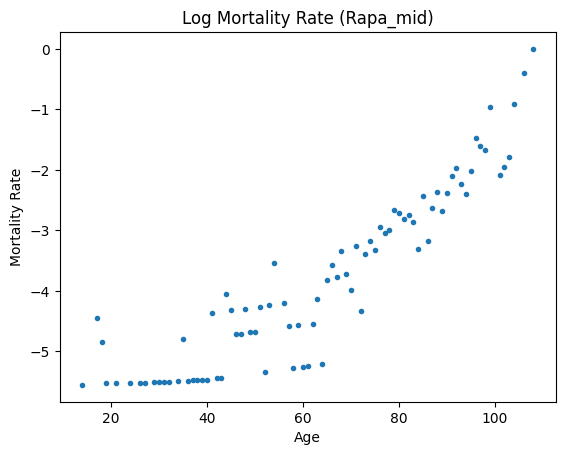

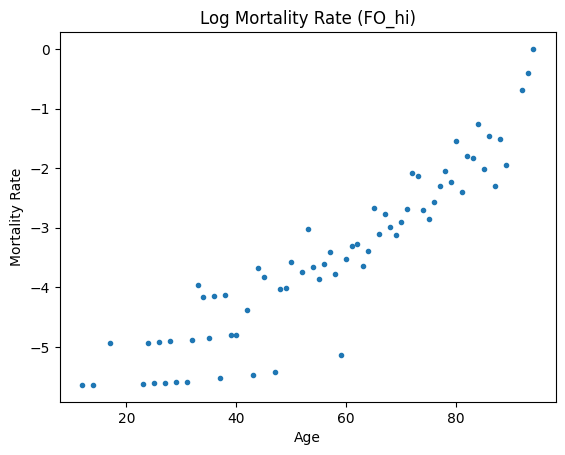

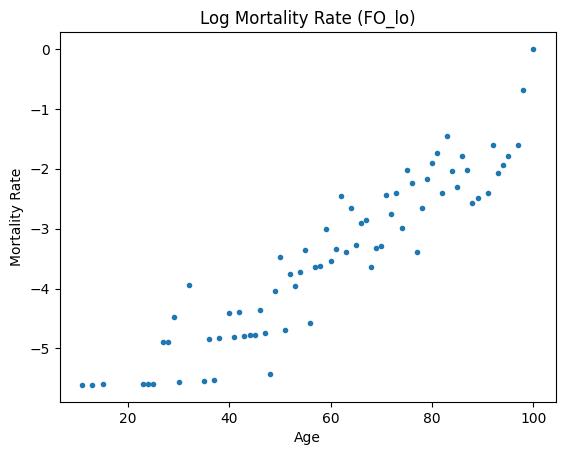

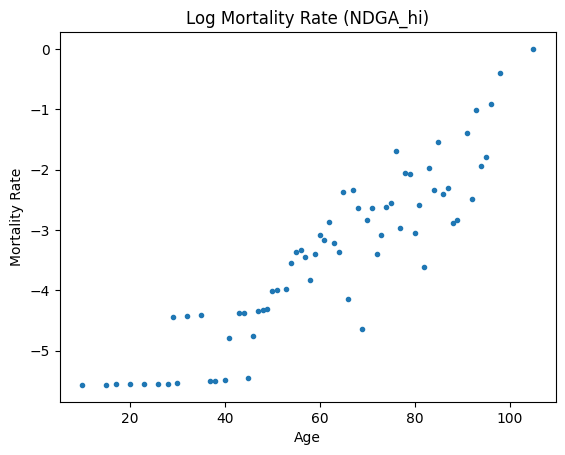

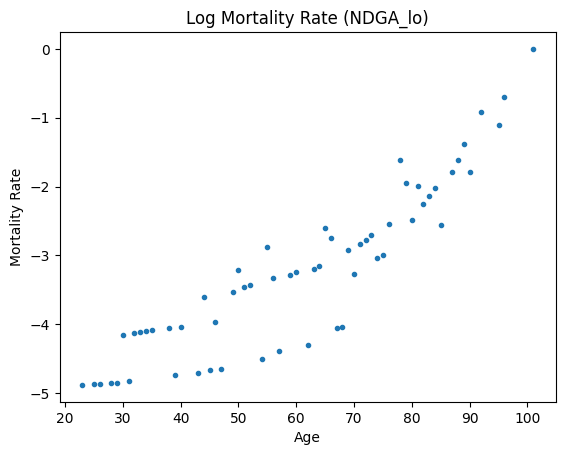

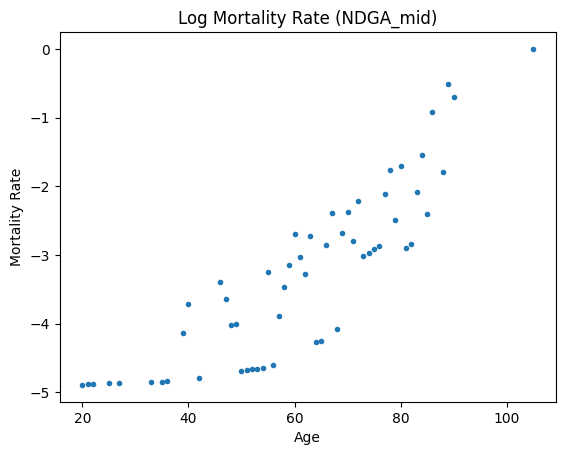

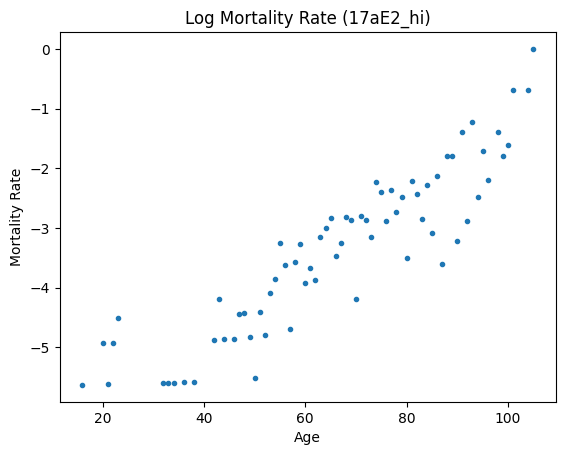

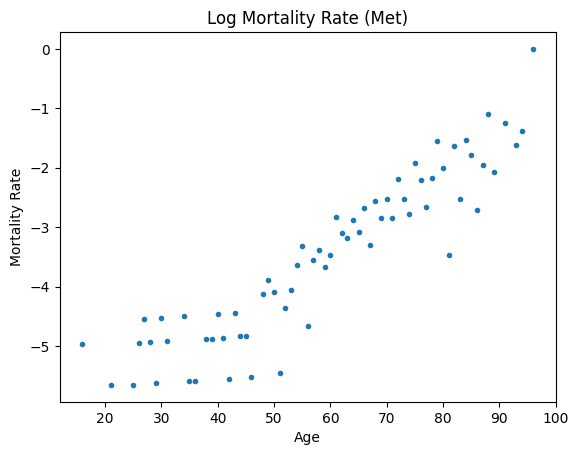

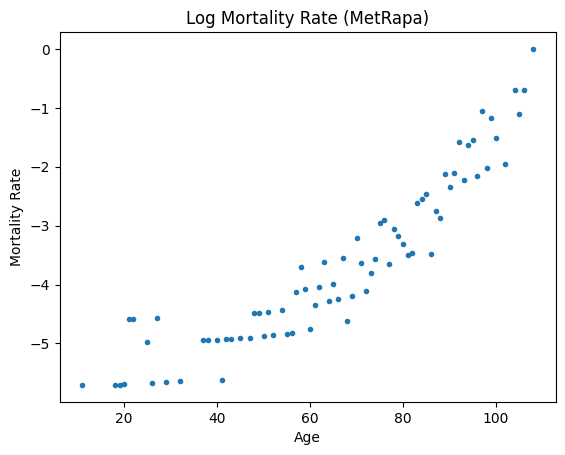

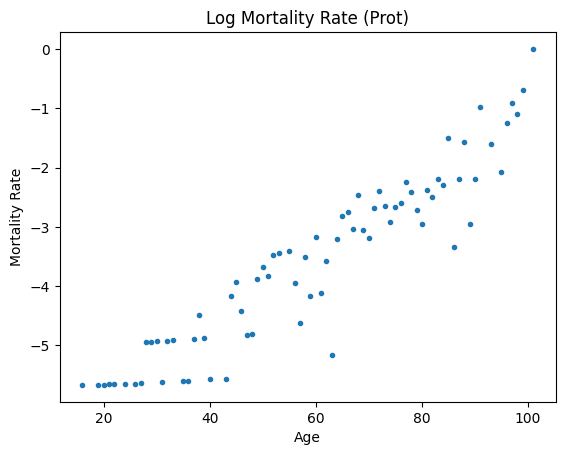

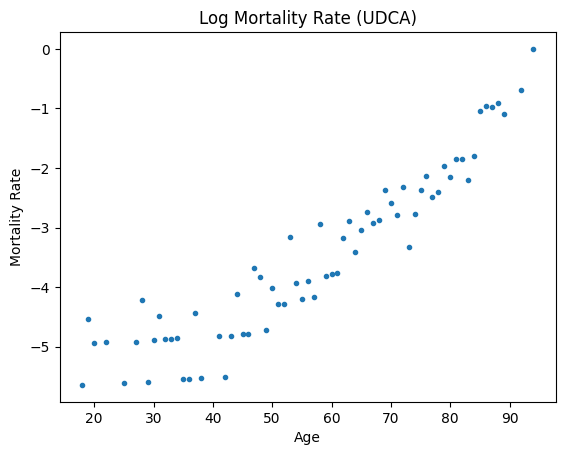

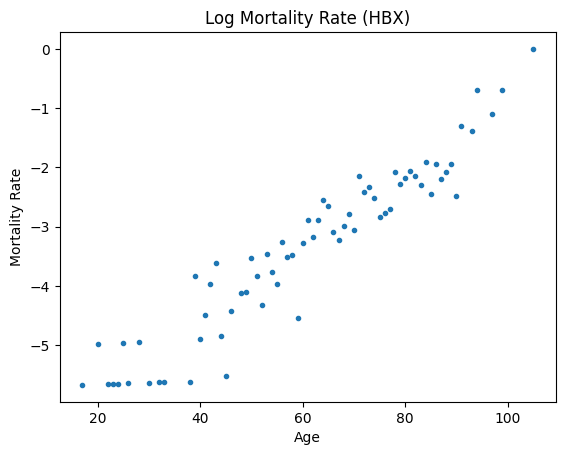

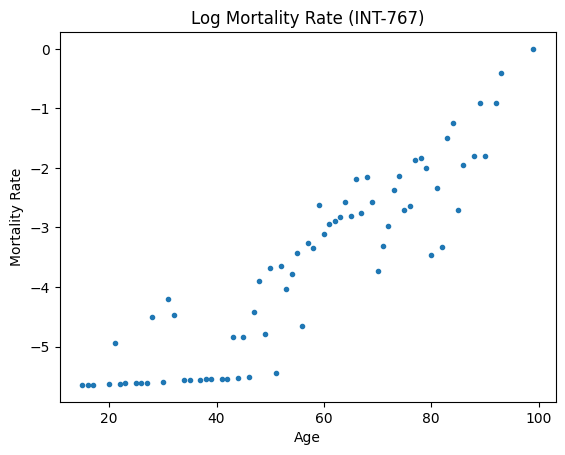

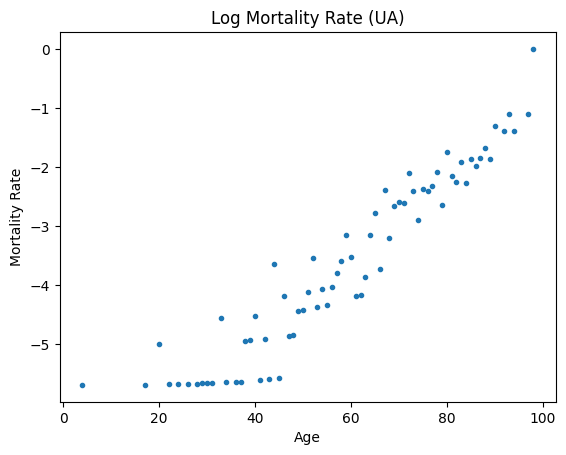

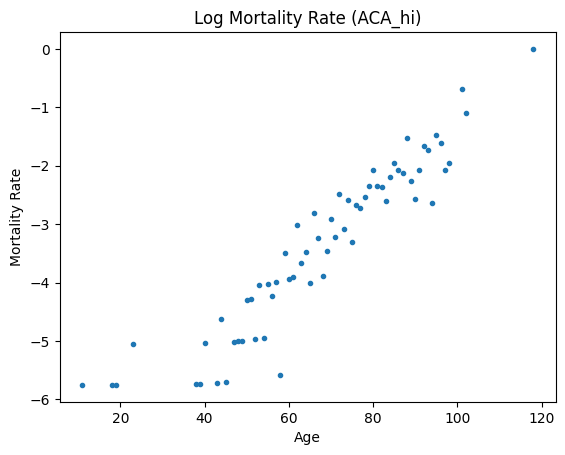

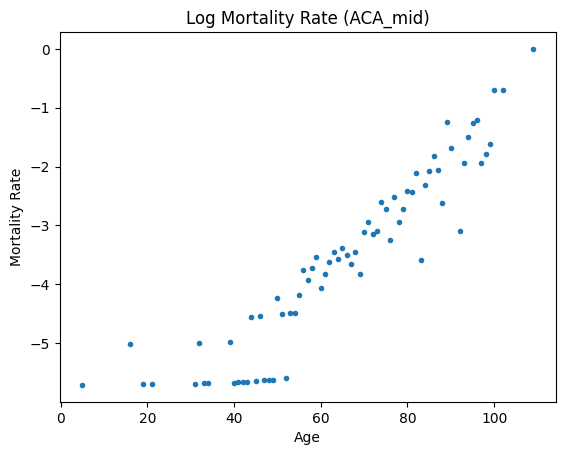

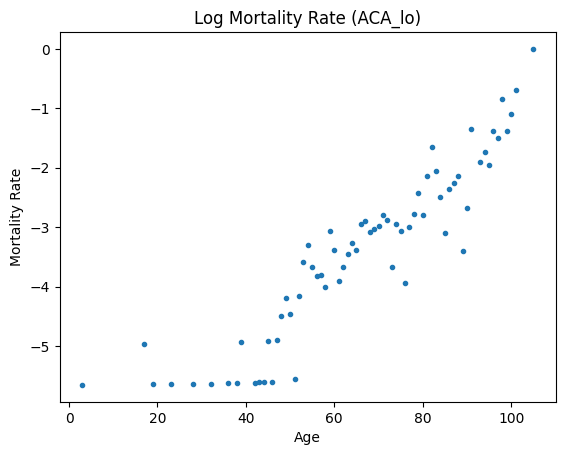

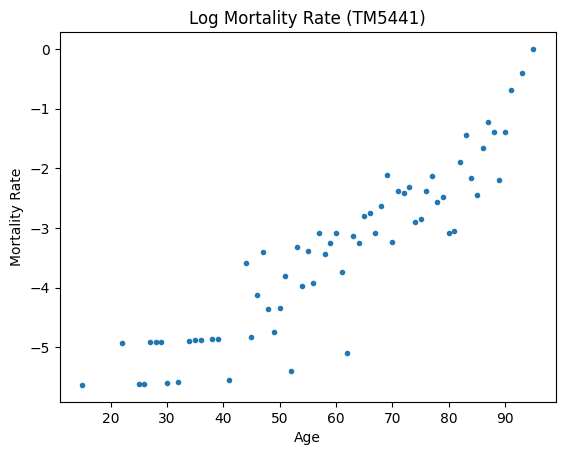

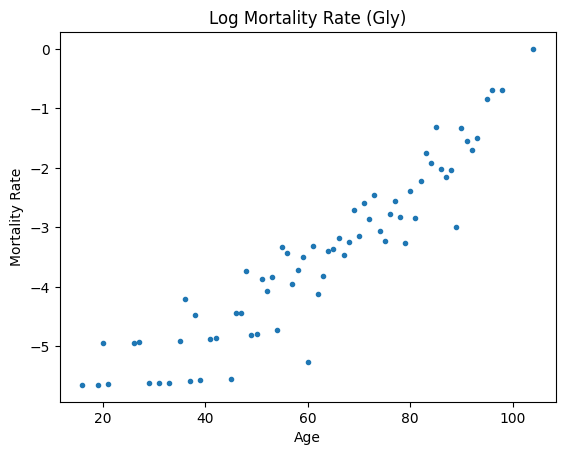

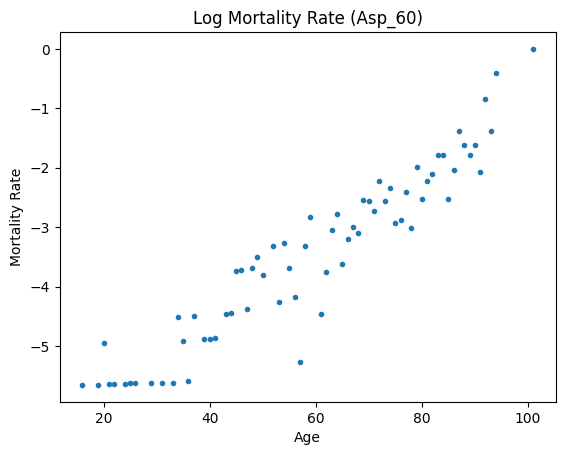

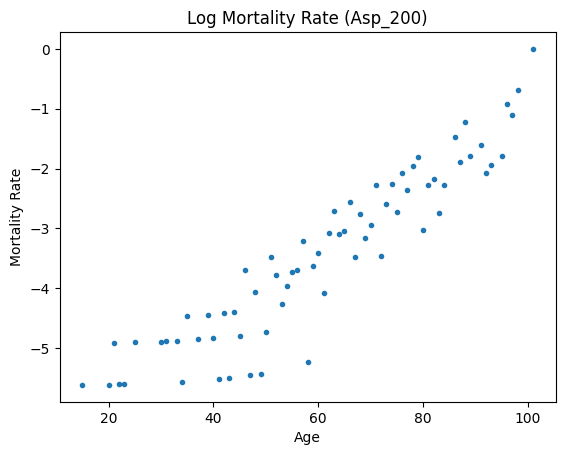

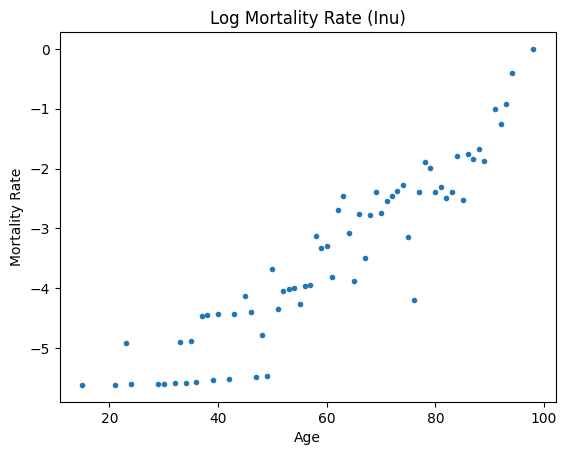

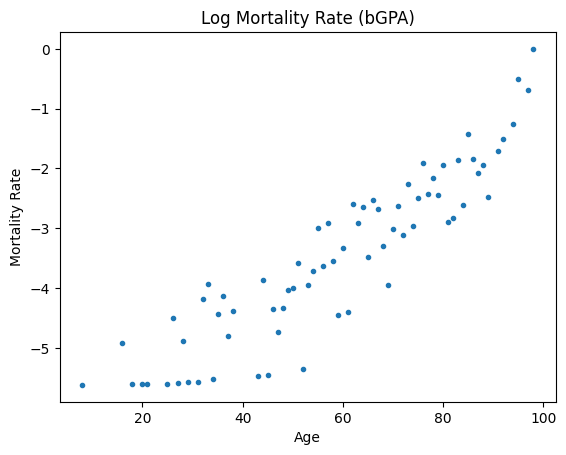

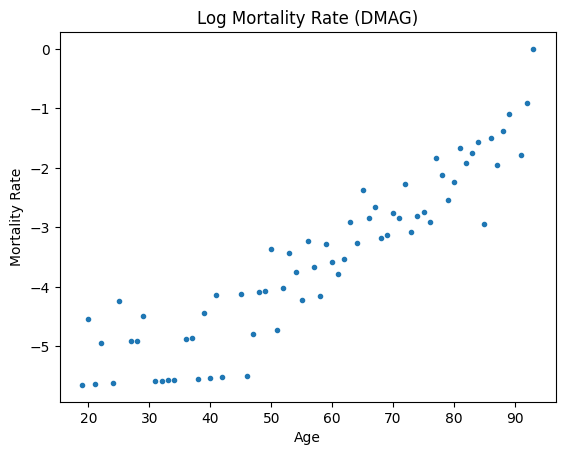

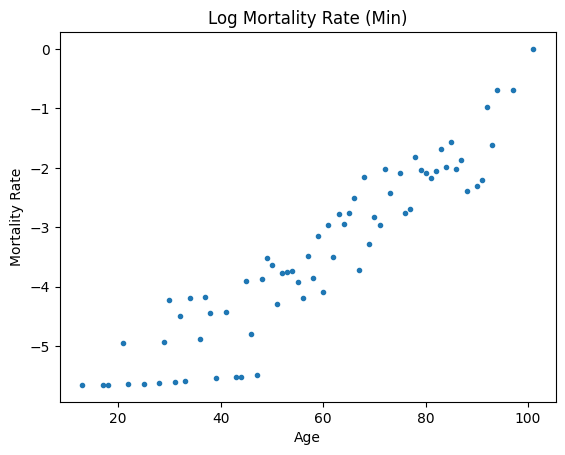

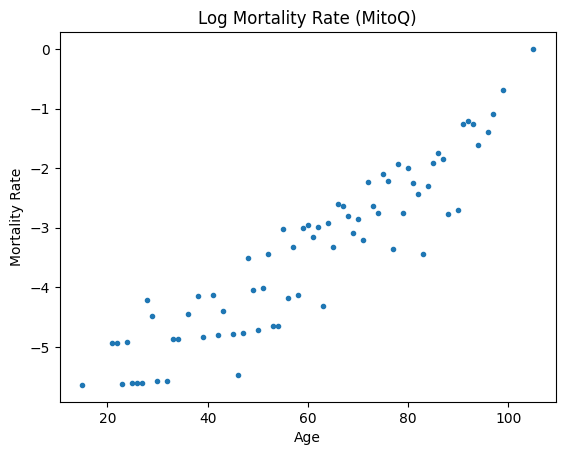

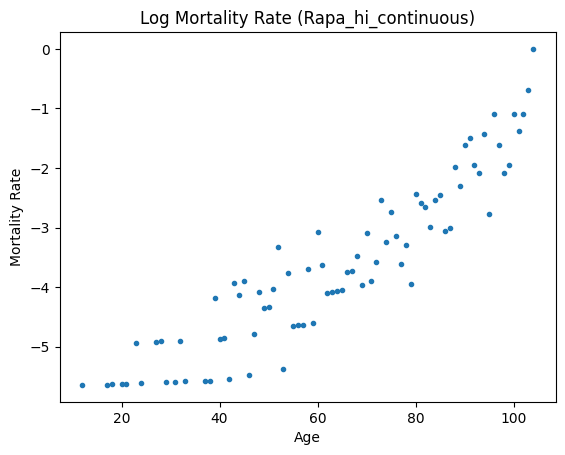

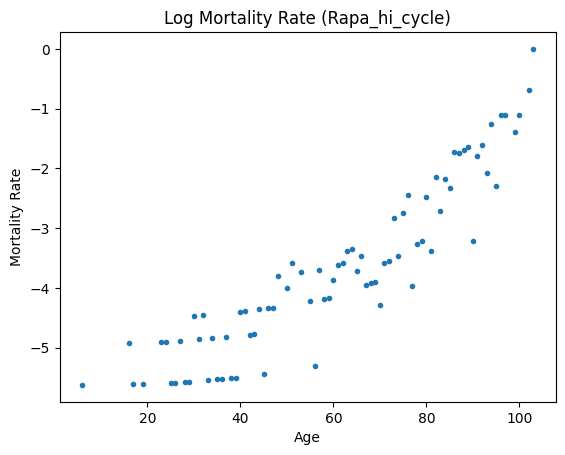

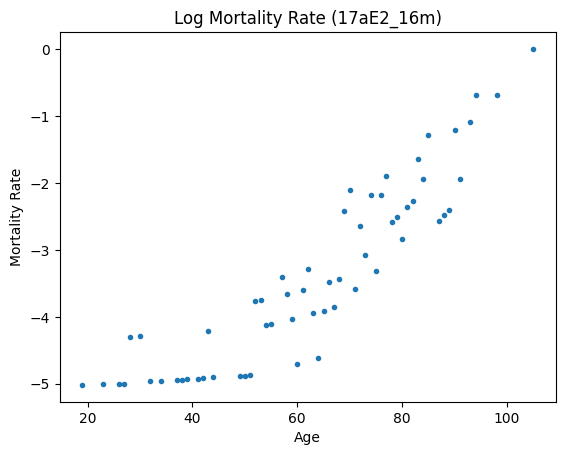

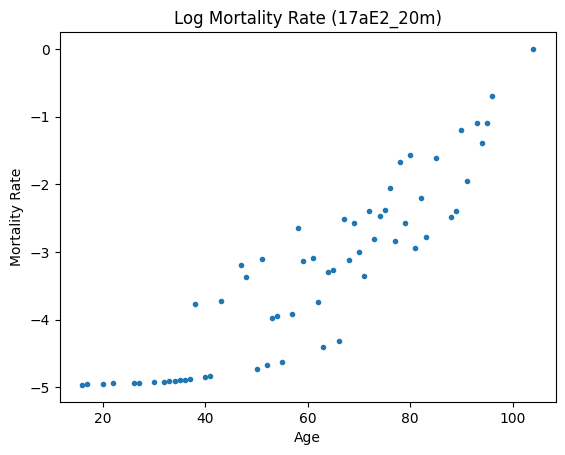

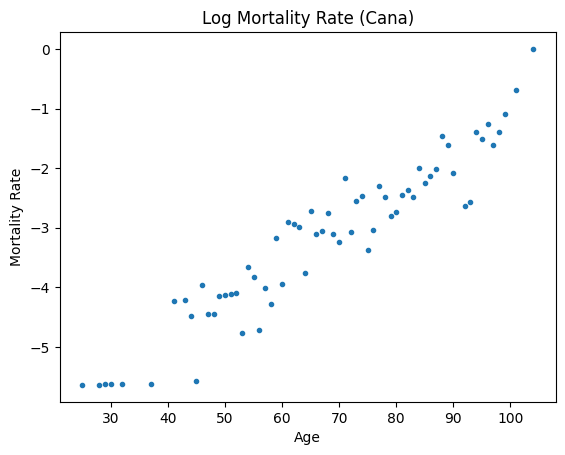

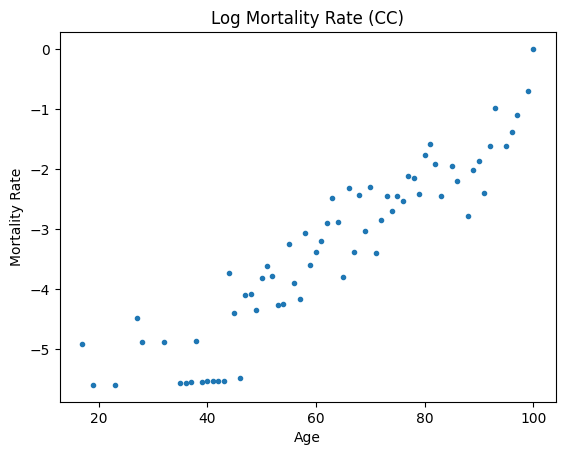

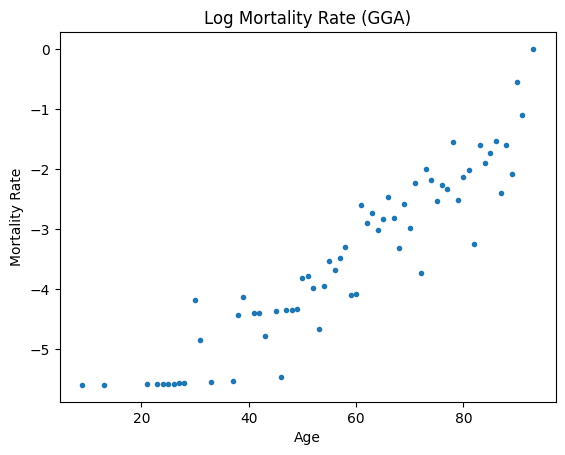

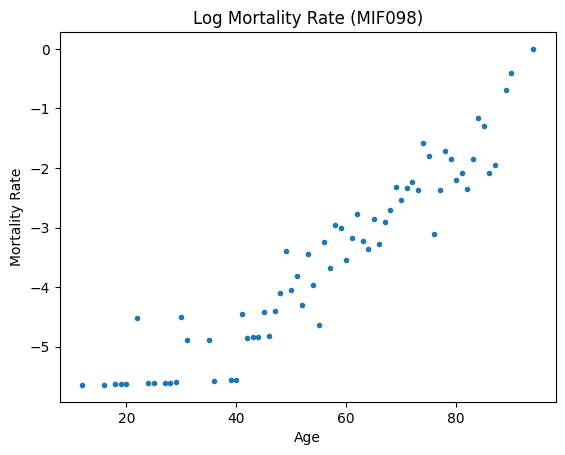

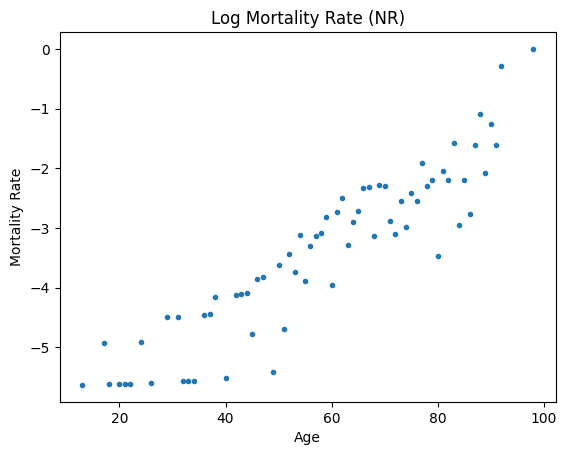

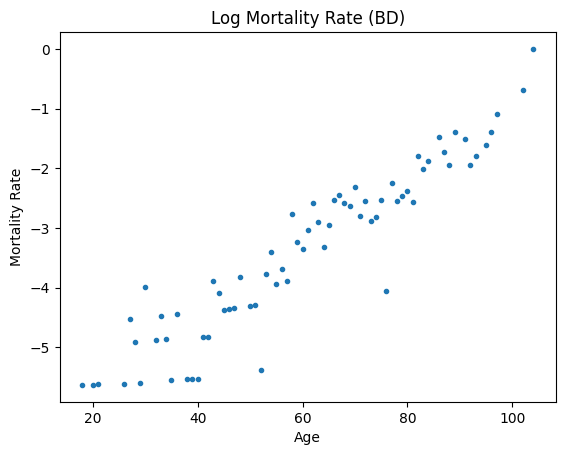

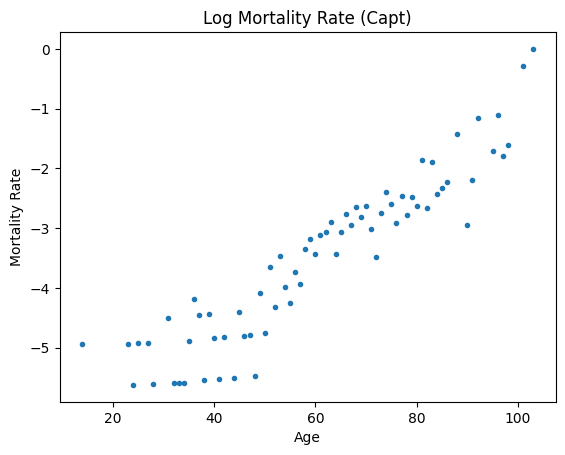

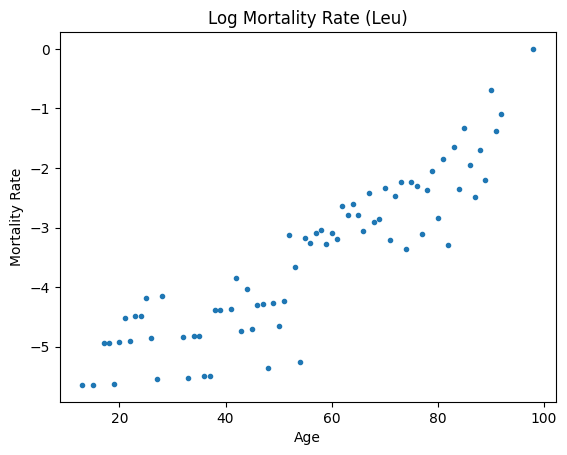

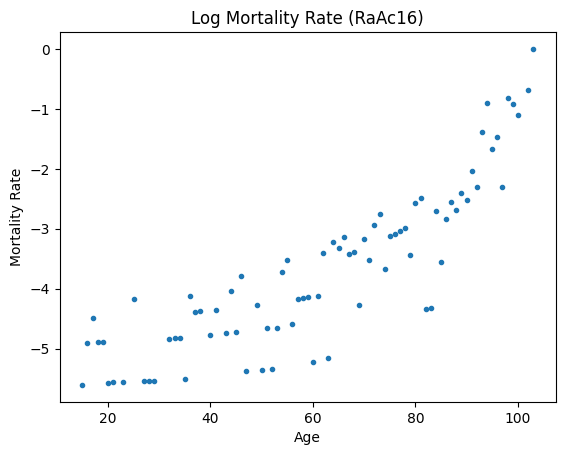

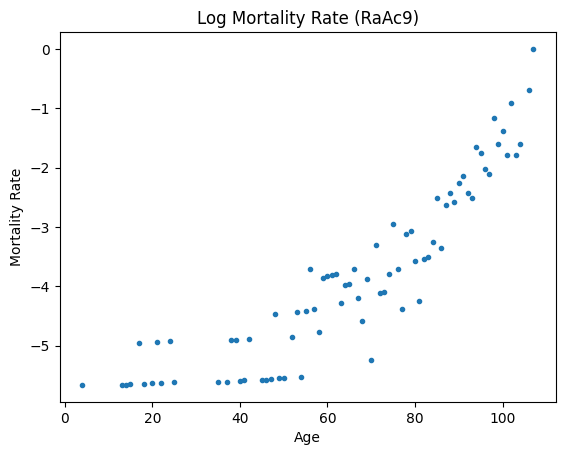

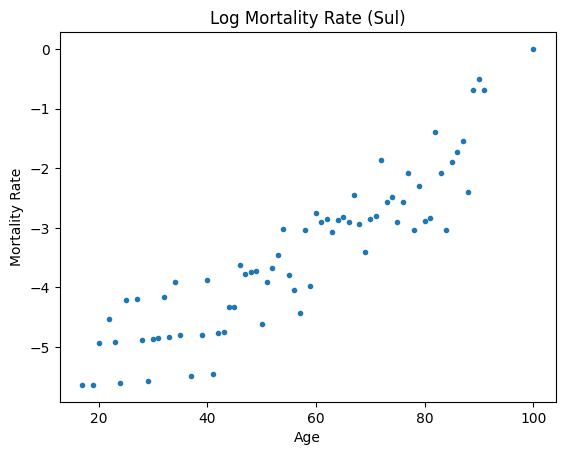

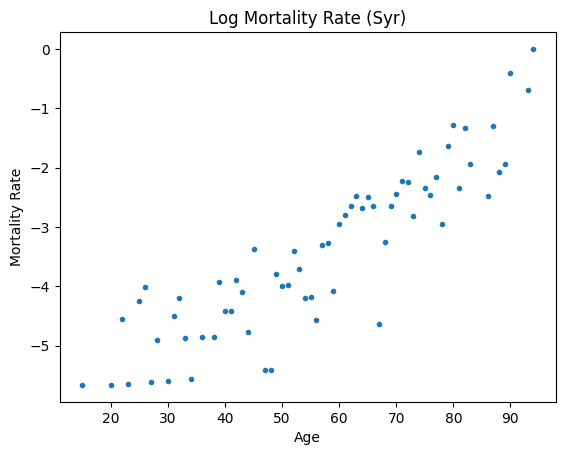

In [325]:
for experiment_name, experiment_group in experiment_groups.items():
    graph_log_mortality_rate(experiment_group, mouse_bin_period_in_days, experiment_name)

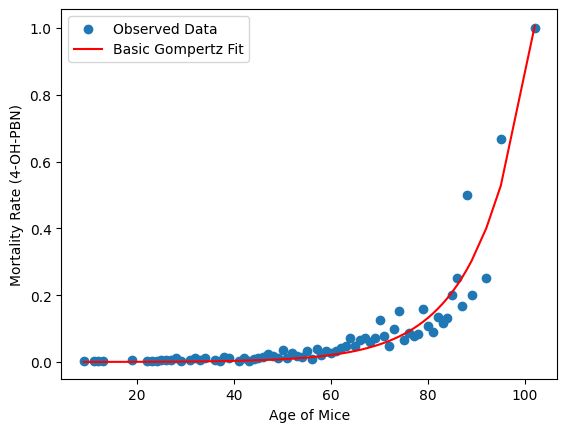

Fitted Parameters:
Alpha: 8.289448124551537e-05
Beta: 8.289448124551537e-05


Statistics:
R-squared: 0.9127932324145732
Mean Squared Error: 0.0020069352538124962




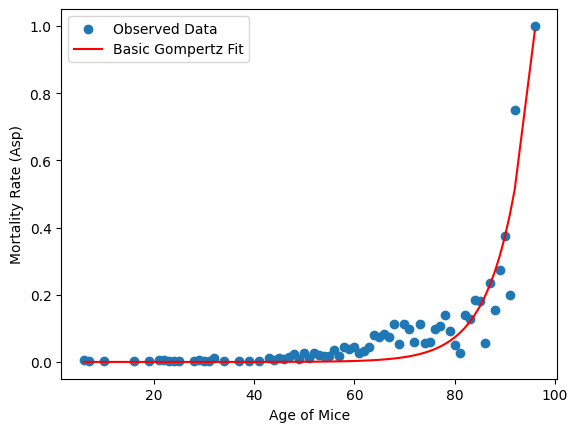

Fitted Parameters:
Alpha: 1.6125484568504268e-07
Beta: 1.6125484568504268e-07


Statistics:
R-squared: 0.855774003735646
Mean Squared Error: 0.003471712128013986




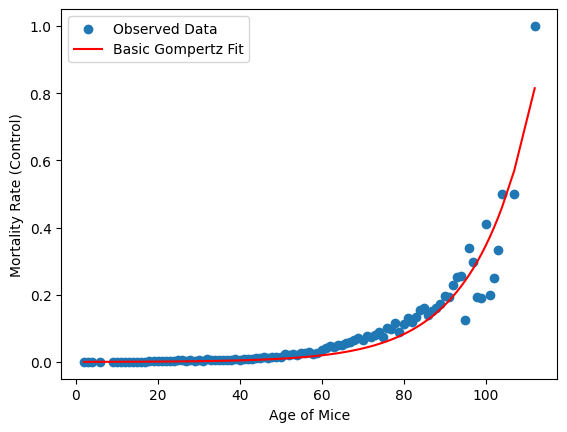

Fitted Parameters:
Alpha: 0.0002684176936084595
Beta: 0.0002684176936084595


Statistics:
R-squared: 0.9074622096224944
Mean Squared Error: 0.0018181453244839193




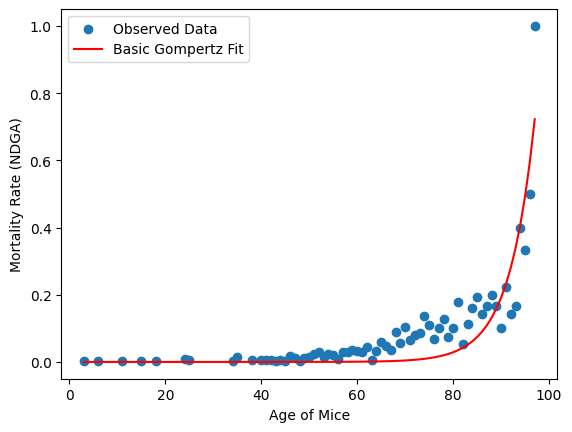

Fitted Parameters:
Alpha: 7.522701705800328e-09
Beta: 7.522701705800328e-09


Statistics:
R-squared: 0.7665749821593328
Mean Squared Error: 0.00496224023928596




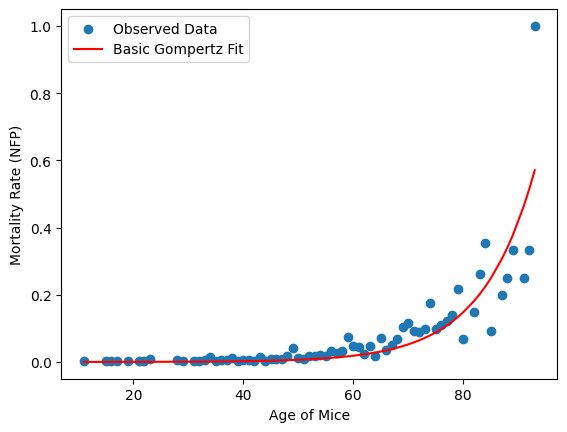

Fitted Parameters:
Alpha: 3.647490134199955e-05
Beta: 3.647490134199955e-05


Statistics:
R-squared: 0.7320309474955685
Mean Squared Error: 0.005340259199717534




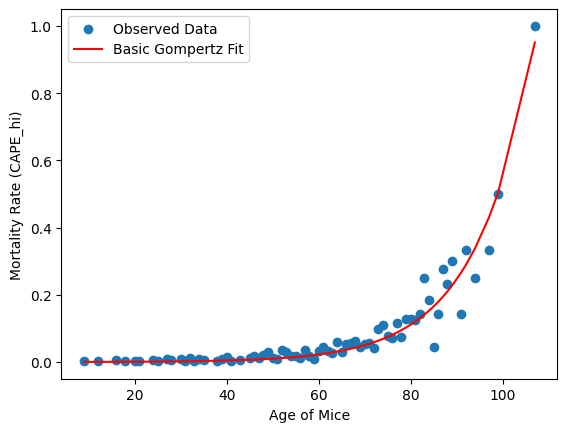

Fitted Parameters:
Alpha: 0.0001937667947140855
Beta: 0.0001937667947140855


Statistics:
R-squared: 0.9422633365350573
Mean Squared Error: 0.0012334657288828928




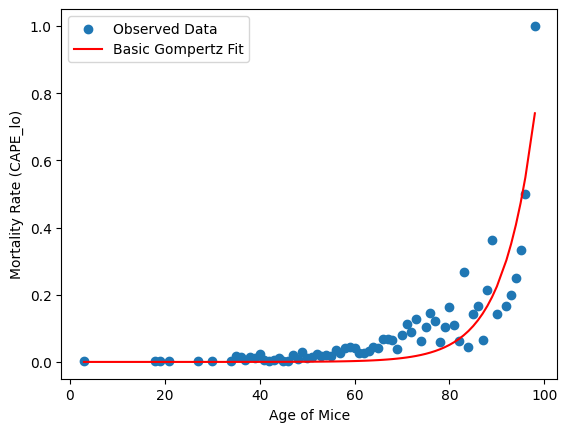

Fitted Parameters:
Alpha: 3.3885875625316173e-07
Beta: 3.3885875625316173e-07


Statistics:
R-squared: 0.760338144110072
Mean Squared Error: 0.005070587730628295




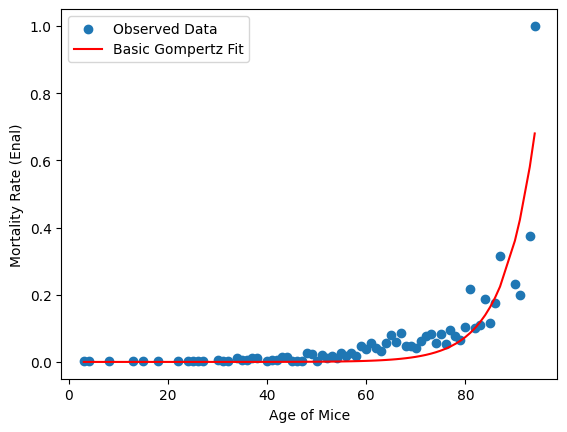

Fitted Parameters:
Alpha: 2.3058581503452023e-07
Beta: 2.3058581503452023e-07


Statistics:
R-squared: 0.77043249433391
Mean Squared Error: 0.0040802164067270845




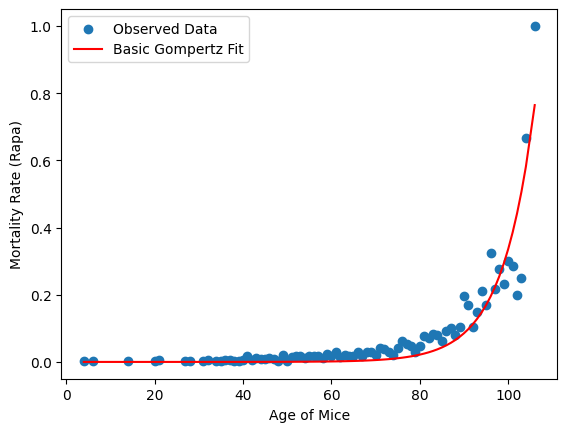

Fitted Parameters:
Alpha: 3.776131471108899e-07
Beta: 3.776131471108899e-07


Statistics:
R-squared: 0.8441659771588733
Mean Squared Error: 0.0033728475368719397




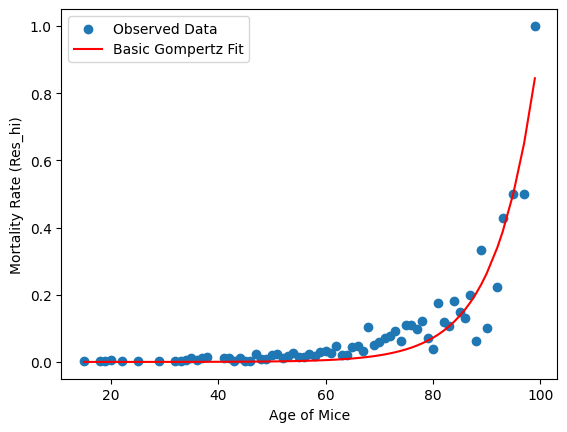

Fitted Parameters:
Alpha: 2.213617033483474e-06
Beta: 2.213617033483474e-06


Statistics:
R-squared: 0.8876961251087759
Mean Squared Error: 0.002656399590444633




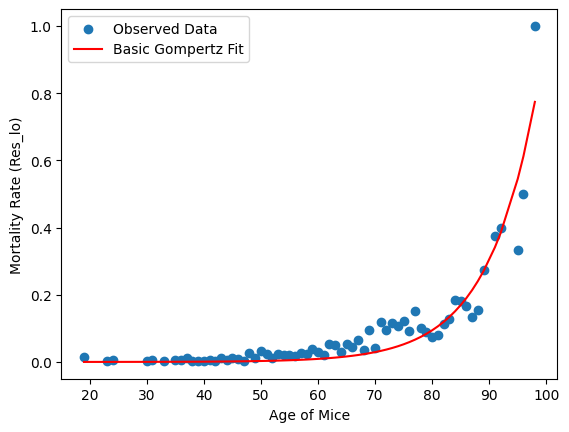

Fitted Parameters:
Alpha: 8.11433667521611e-06
Beta: 8.11433667521611e-06


Statistics:
R-squared: 0.8813262348185007
Mean Squared Error: 0.0027260968077438778




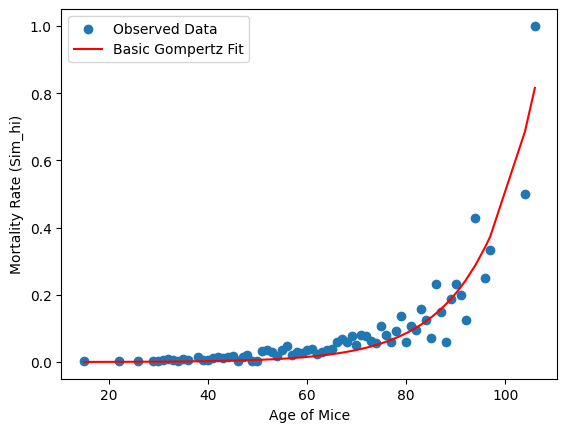

Fitted Parameters:
Alpha: 8.327213990802576e-05
Beta: 8.327213990802576e-05


Statistics:
R-squared: 0.8896743484426107
Mean Squared Error: 0.002315397713373321




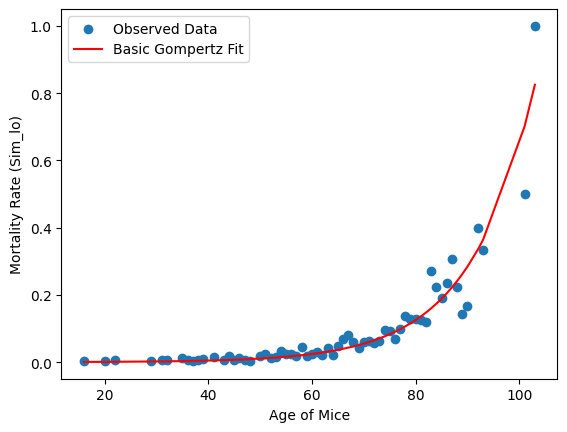

Fitted Parameters:
Alpha: 0.00017832842101718198
Beta: 0.00017832842101718198


Statistics:
R-squared: 0.9108737729032972
Mean Squared Error: 0.00213452777778942




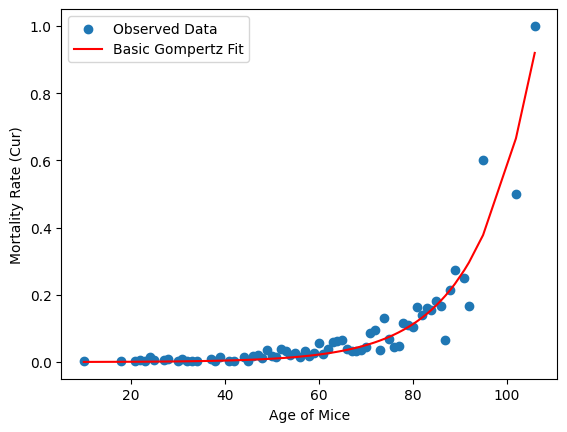

Fitted Parameters:
Alpha: 0.00017366863297550318
Beta: 0.00017366863297550318


Statistics:
R-squared: 0.9126512039101693
Mean Squared Error: 0.0020082493986729954




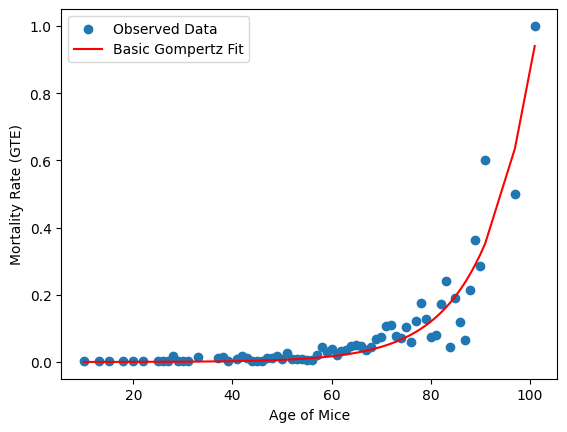

Fitted Parameters:
Alpha: 4.682683257791336e-05
Beta: 4.682683257791336e-05


Statistics:
R-squared: 0.8918073220112648
Mean Squared Error: 0.0026153569631195083




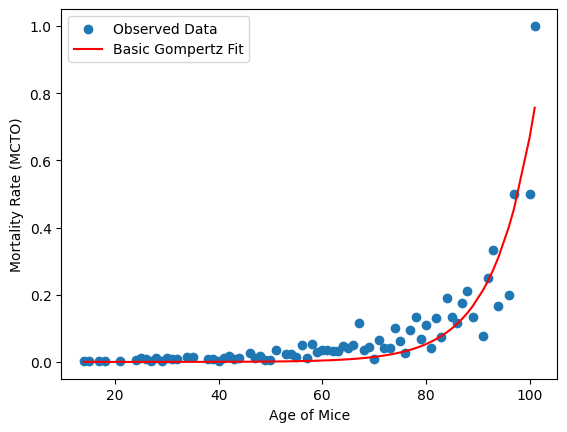

Fitted Parameters:
Alpha: 2.0885994019843044e-06
Beta: 2.0885994019843044e-06


Statistics:
R-squared: 0.8376769022869112
Mean Squared Error: 0.0034190746811207815




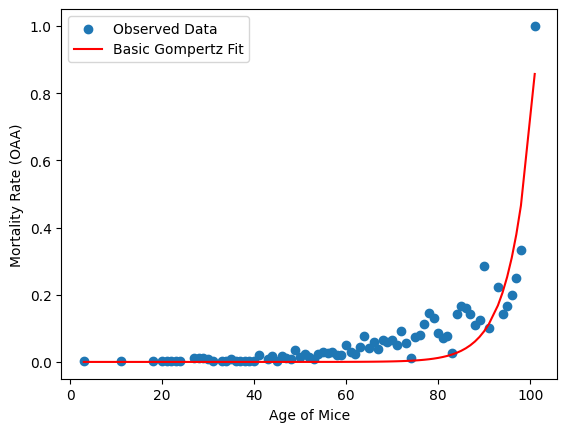

Fitted Parameters:
Alpha: 1.0056693479592082e-09
Beta: 1.0056693479592082e-09


Statistics:
R-squared: 0.7647814647344218
Mean Squared Error: 0.0038117891988675525




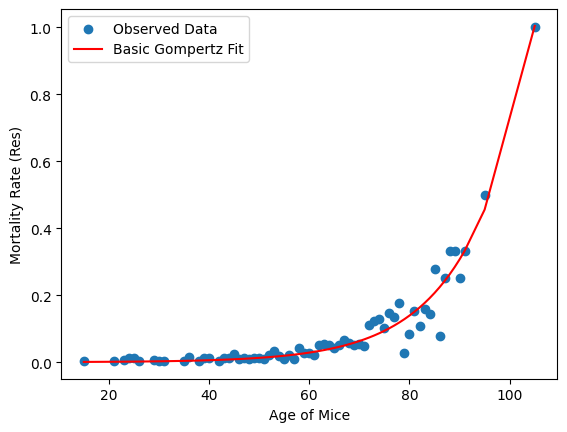

Fitted Parameters:
Alpha: 0.00025002841239946854
Beta: 0.00025002841239946854


Statistics:
R-squared: 0.9513861182649509
Mean Squared Error: 0.001111305419446901




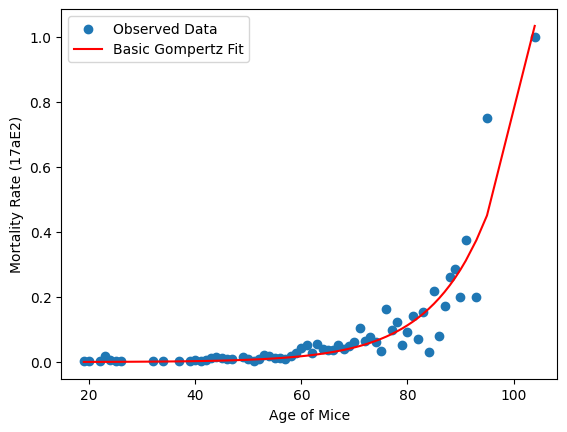

Fitted Parameters:
Alpha: 7.06834083886754e-05
Beta: 7.06834083886754e-05


Statistics:
R-squared: 0.885897235564873
Mean Squared Error: 0.0029855713875347085




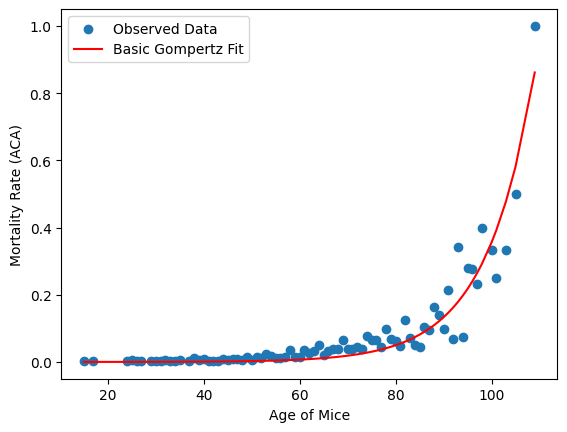

Fitted Parameters:
Alpha: 1.9137621313050647e-05
Beta: 1.9137621313050647e-05


Statistics:
R-squared: 0.8995243034751688
Mean Squared Error: 0.0021421440907142104




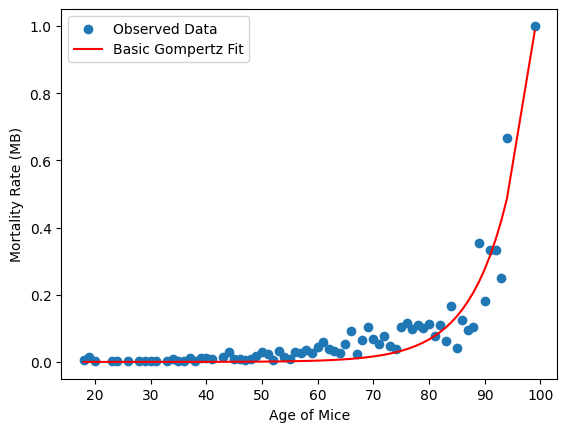

Fitted Parameters:
Alpha: 8.082062899246404e-07
Beta: 8.082062899246404e-07


Statistics:
R-squared: 0.8889593302779308
Mean Squared Error: 0.0025243180592986673




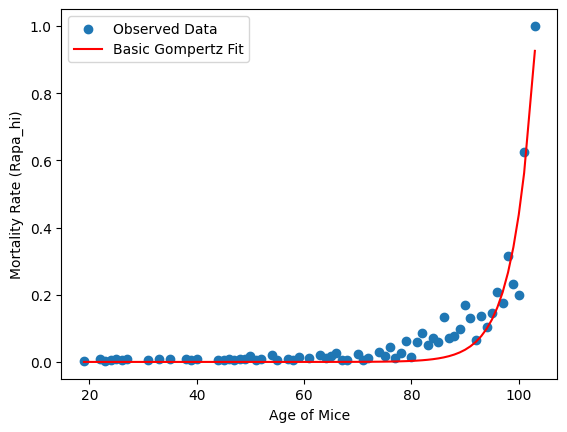

Fitted Parameters:
Alpha: 6.556269348778228e-12
Beta: 6.556269348778228e-12


Statistics:
R-squared: 0.8869333872205771
Mean Squared Error: 0.0025451441199666365




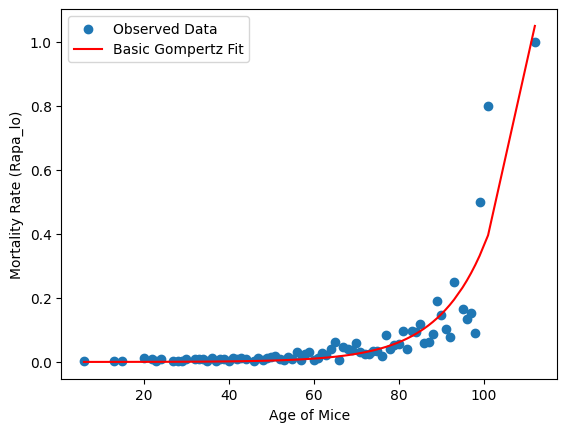

Fitted Parameters:
Alpha: 5.104034620657606e-05
Beta: 5.104034620657606e-05


Statistics:
R-squared: 0.8289755604060279
Mean Squared Error: 0.003969974991322954




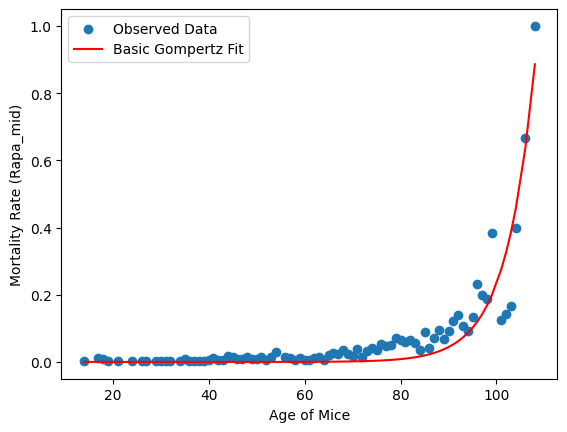

Fitted Parameters:
Alpha: 1.3646655796515686e-08
Beta: 1.3646655796515686e-08


Statistics:
R-squared: 0.8629130498099207
Mean Squared Error: 0.002812587093732143




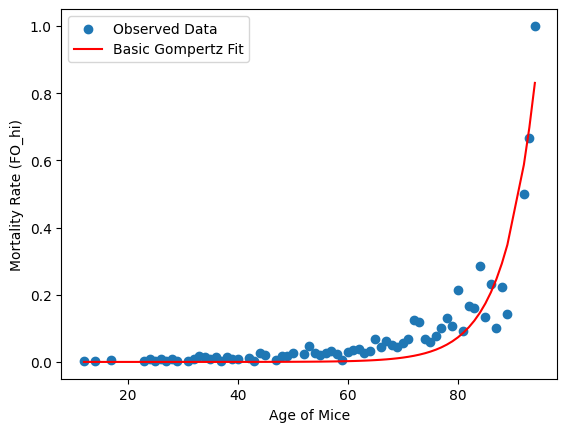

Fitted Parameters:
Alpha: 6.774777944081004e-08
Beta: 6.774777944081004e-08


Statistics:
R-squared: 0.8687561631629688
Mean Squared Error: 0.00318820218236644




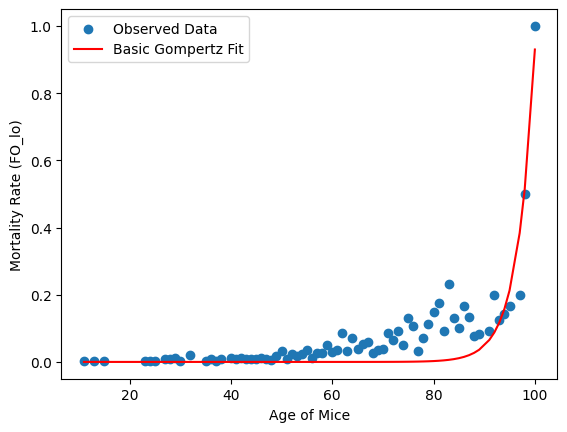

Fitted Parameters:
Alpha: 1.4201036642918783e-13
Beta: 1.4201036642918783e-13


Statistics:
R-squared: 0.743794951931559
Mean Squared Error: 0.004562452829960229




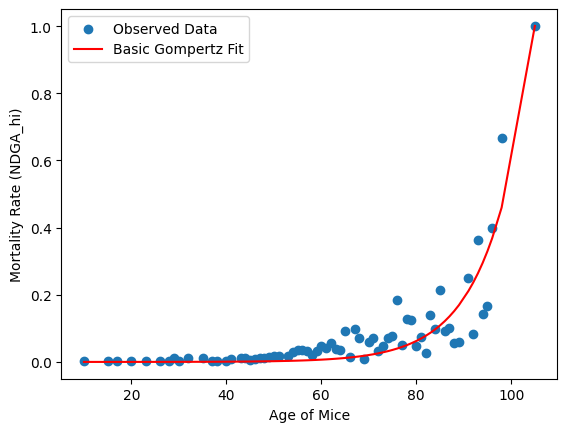

Fitted Parameters:
Alpha: 8.616649389425355e-06
Beta: 8.616649389425355e-06


Statistics:
R-squared: 0.8536372517553069
Mean Squared Error: 0.0034329536347331596




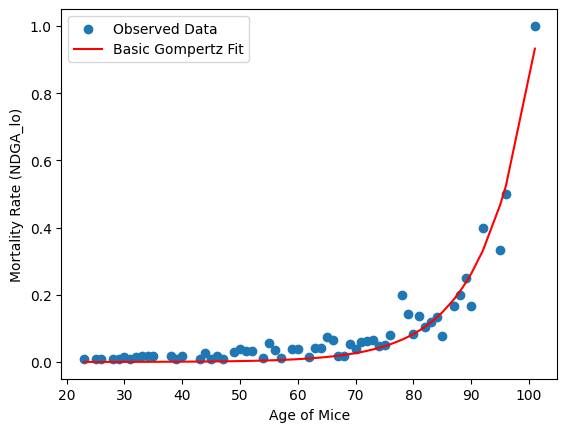

Fitted Parameters:
Alpha: 8.400673411254522e-06
Beta: 8.400673411254522e-06


Statistics:
R-squared: 0.9342434720785966
Mean Squared Error: 0.0015351356848407704




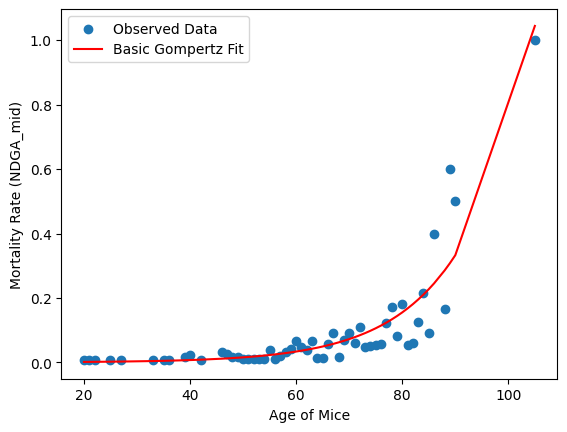

Fitted Parameters:
Alpha: 0.0003486748758337209
Beta: 0.0003486748758337209


Statistics:
R-squared: 0.852374204859822
Mean Squared Error: 0.004123033278879996




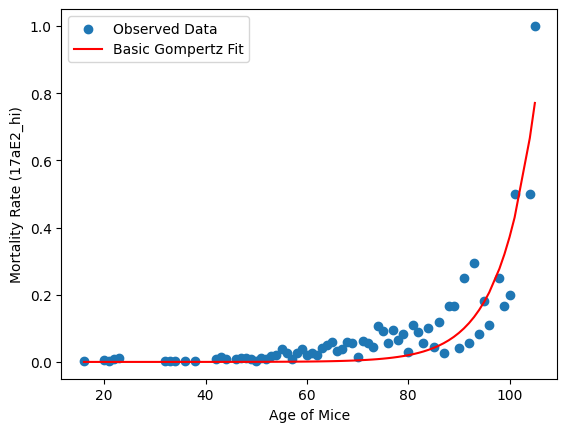

Fitted Parameters:
Alpha: 1.6976382027371731e-07
Beta: 1.6976382027371731e-07


Statistics:
R-squared: 0.7951940782033105
Mean Squared Error: 0.004433504007625382




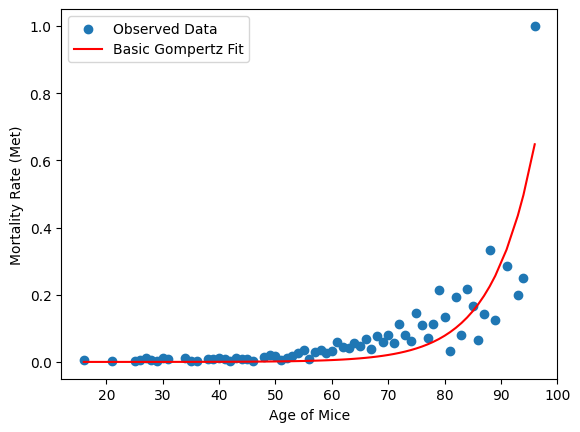

Fitted Parameters:
Alpha: 1.953238096787377e-06
Beta: 1.953238096787377e-06


Statistics:
R-squared: 0.6856915209414399
Mean Squared Error: 0.005804863176144394




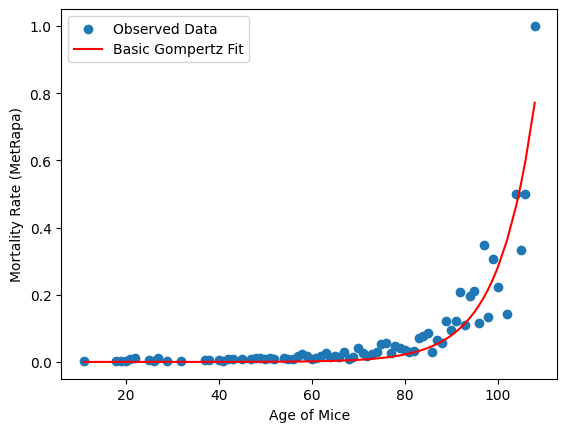

Fitted Parameters:
Alpha: 8.565434866884007e-07
Beta: 8.565434866884007e-07


Statistics:
R-squared: 0.8638610925116968
Mean Squared Error: 0.003032000821114549




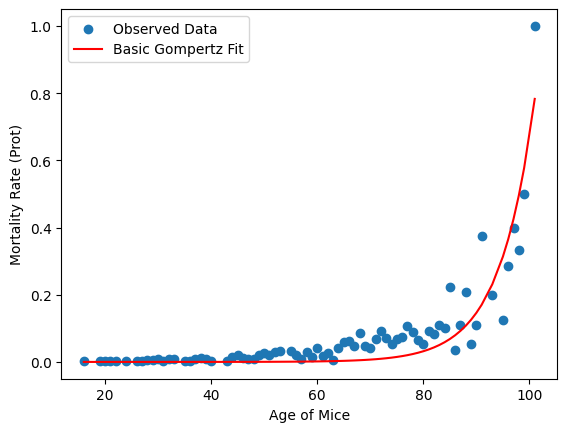

Fitted Parameters:
Alpha: 1.5895914517569248e-07
Beta: 1.5895914517569248e-07


Statistics:
R-squared: 0.8205552484022363
Mean Squared Error: 0.0037639309154744167




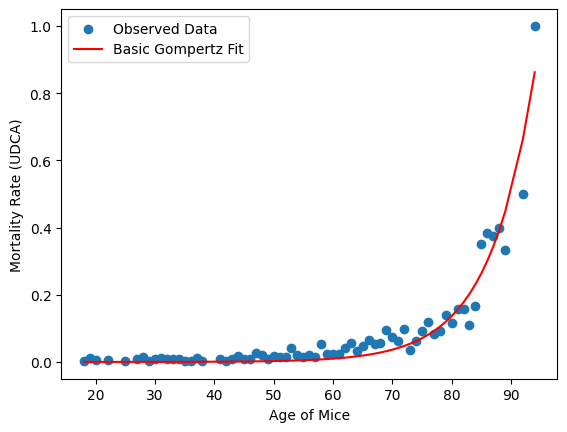

Fitted Parameters:
Alpha: 3.6322704247522184e-06
Beta: 3.6322704247522184e-06


Statistics:
R-squared: 0.9314700521101237
Mean Squared Error: 0.0016613158715738344




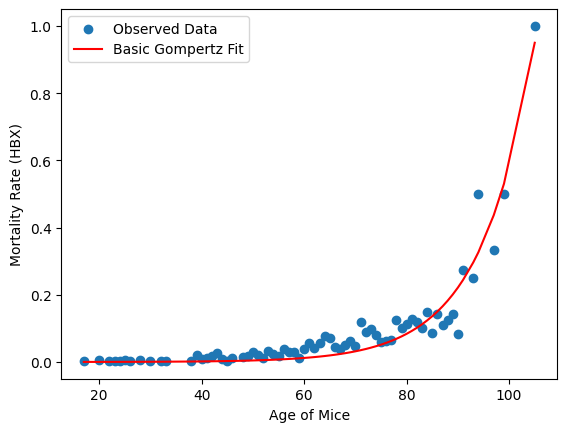

Fitted Parameters:
Alpha: 3.542380105434011e-05
Beta: 3.542380105434011e-05


Statistics:
R-squared: 0.9212100869270644
Mean Squared Error: 0.001719260230896424




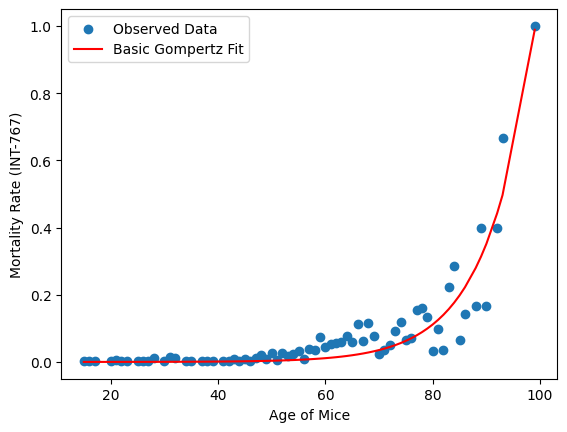

Fitted Parameters:
Alpha: 1.1467329349513547e-05
Beta: 1.1467329349513547e-05


Statistics:
R-squared: 0.8813304776102714
Mean Squared Error: 0.0028298736671666077




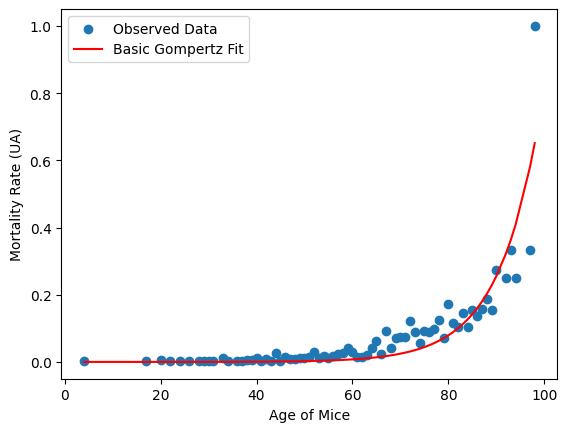

Fitted Parameters:
Alpha: 6.8074097226413434e-06
Beta: 6.8074097226413434e-06


Statistics:
R-squared: 0.7917855403738328
Mean Squared Error: 0.0038157815996662323




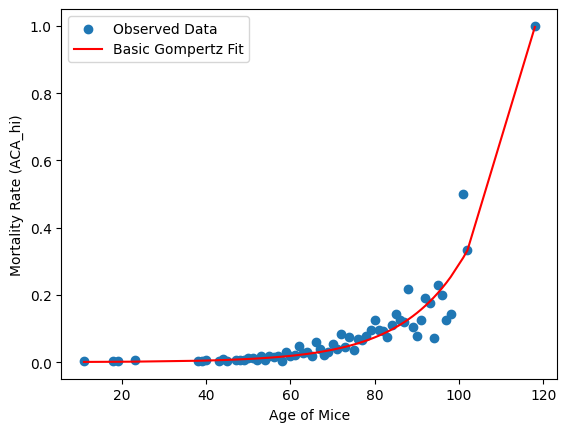

Fitted Parameters:
Alpha: 0.0003052007906917701
Beta: 0.0003052007906917701


Statistics:
R-squared: 0.9223304384256814
Mean Squared Error: 0.001589184829155973




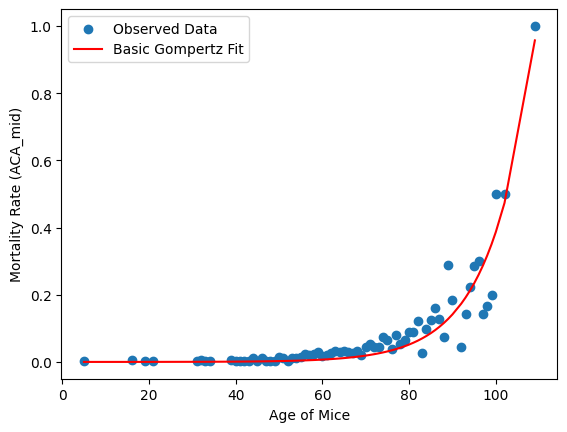

Fitted Parameters:
Alpha: 1.658521561597947e-05
Beta: 1.658521561597947e-05


Statistics:
R-squared: 0.8990222394951661
Mean Squared Error: 0.0022691490393240716




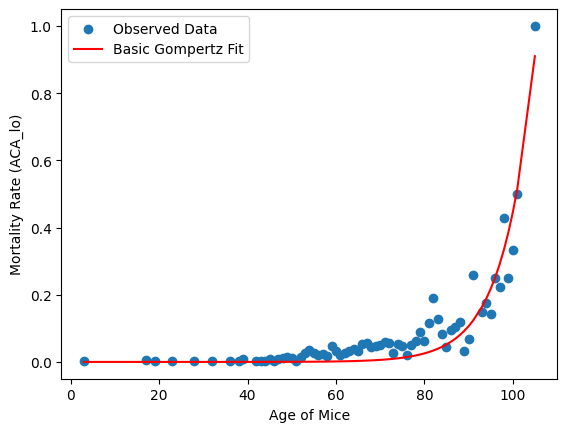

Fitted Parameters:
Alpha: 2.6891807257429167e-07
Beta: 2.6891807257429167e-07


Statistics:
R-squared: 0.8895301854693727
Mean Squared Error: 0.0024241237921869595




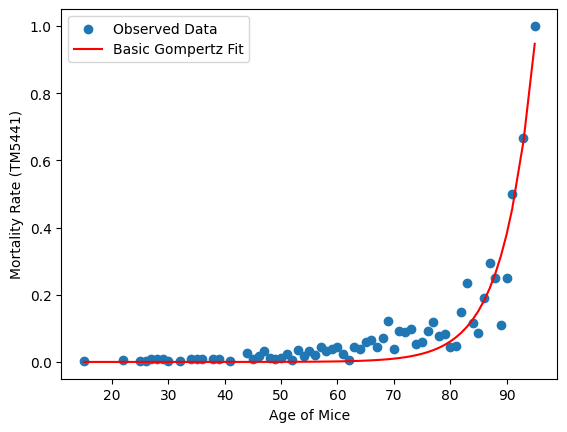

Fitted Parameters:
Alpha: 2.625390478066184e-08
Beta: 2.625390478066184e-08


Statistics:
R-squared: 0.8967763629903804
Mean Squared Error: 0.002651482601534154




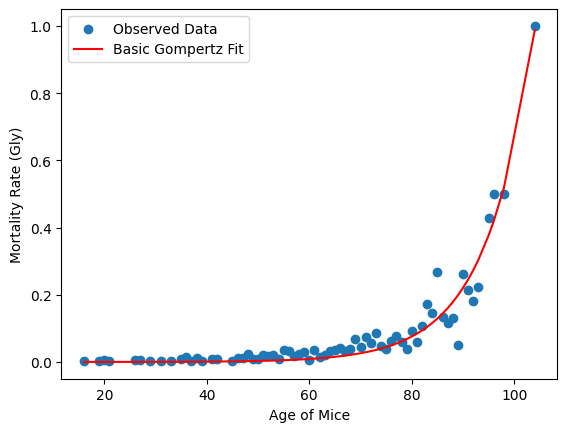

Fitted Parameters:
Alpha: 1.4495913099692412e-05
Beta: 1.4495913099692412e-05


Statistics:
R-squared: 0.9409568032252834
Mean Squared Error: 0.001399641045947128




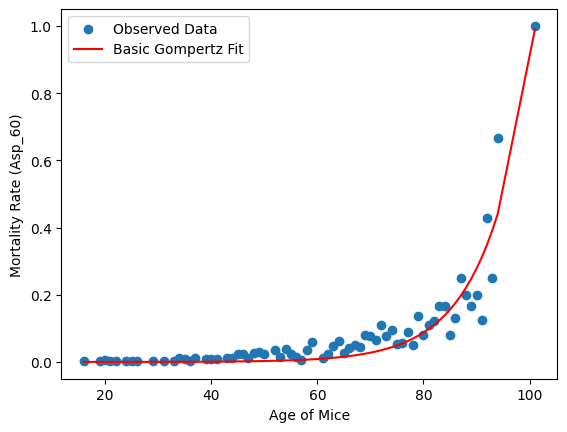

Fitted Parameters:
Alpha: 8.527557364045018e-06
Beta: 8.527557364045018e-06


Statistics:
R-squared: 0.8900916136410802
Mean Squared Error: 0.0025516493985366087




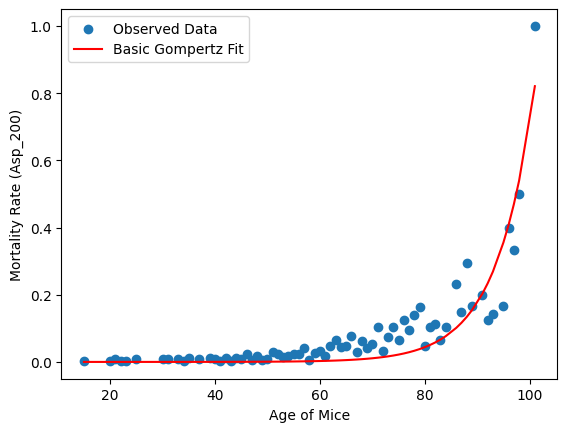

Fitted Parameters:
Alpha: 6.258523142791528e-07
Beta: 6.258523142791528e-07


Statistics:
R-squared: 0.826511119184159
Mean Squared Error: 0.0036815632264330864




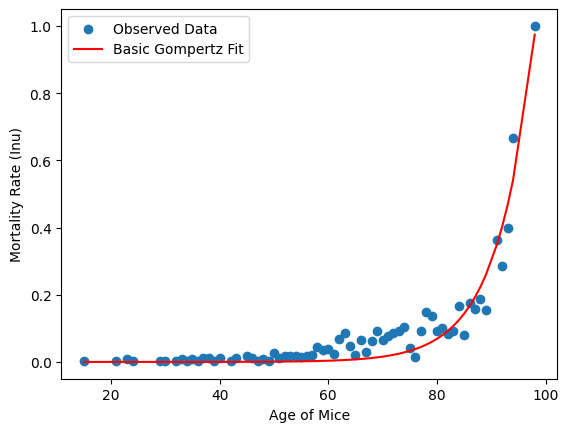

Fitted Parameters:
Alpha: 5.243336626558258e-07
Beta: 5.243336626558258e-07


Statistics:
R-squared: 0.9225603426856469
Mean Squared Error: 0.0018877374597510064




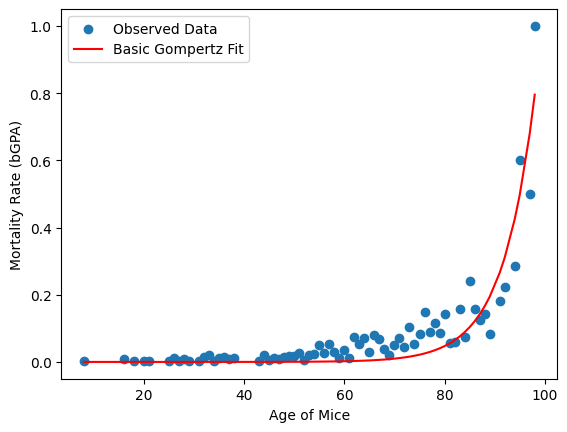

Fitted Parameters:
Alpha: 1.6559691484476245e-07
Beta: 1.6559691484476245e-07


Statistics:
R-squared: 0.8432761537728674
Mean Squared Error: 0.0035251520383315174




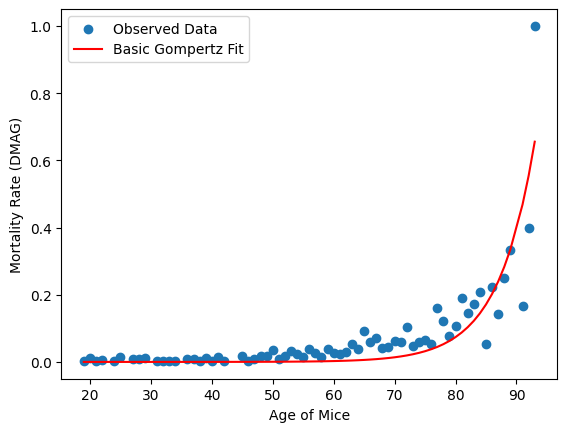

Fitted Parameters:
Alpha: 1.0782347664961071e-07
Beta: 1.0782347664961071e-07


Statistics:
R-squared: 0.7383369247575433
Mean Squared Error: 0.005012939521377081




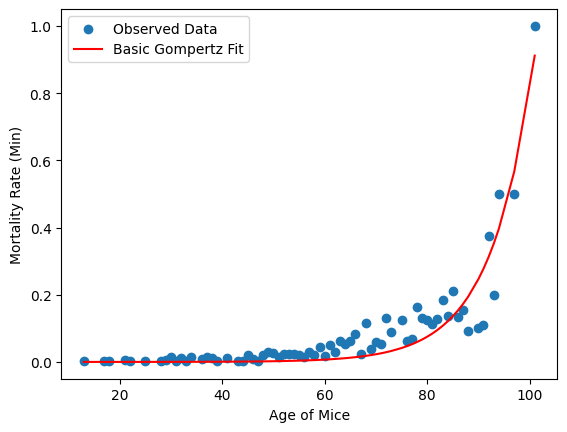

Fitted Parameters:
Alpha: 5.497213283923528e-06
Beta: 5.497213283923528e-06


Statistics:
R-squared: 0.8718341839432586
Mean Squared Error: 0.0028113256331503958




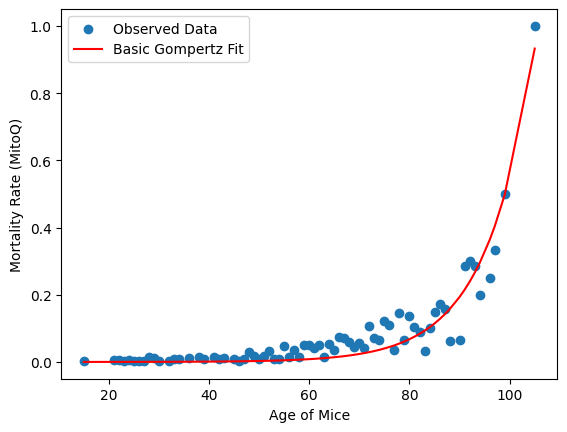

Fitted Parameters:
Alpha: 1.5389017512688898e-05
Beta: 1.5389017512688898e-05


Statistics:
R-squared: 0.9109639759652381
Mean Squared Error: 0.0017966719658484025




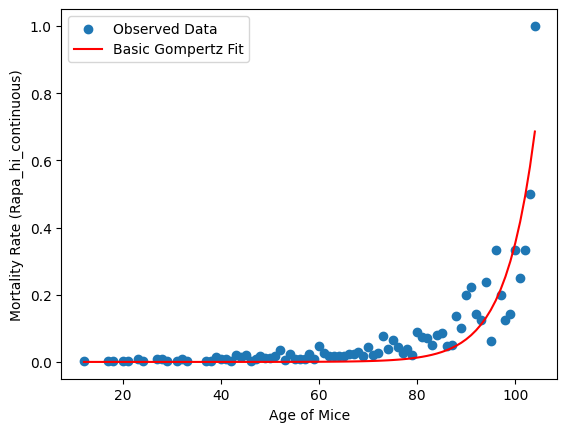

Fitted Parameters:
Alpha: 2.2801875718360104e-08
Beta: 2.2801875718360104e-08


Statistics:
R-squared: 0.7829333960364097
Mean Squared Error: 0.004192006171616088




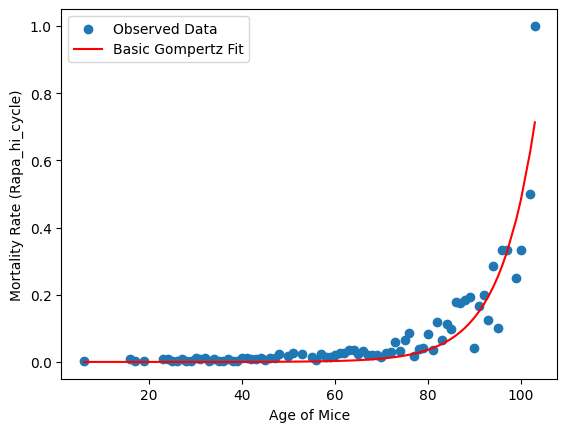

Fitted Parameters:
Alpha: 1.125209279644711e-06
Beta: 1.125209279644711e-06


Statistics:
R-squared: 0.8401926019212198
Mean Squared Error: 0.0031871854200784993




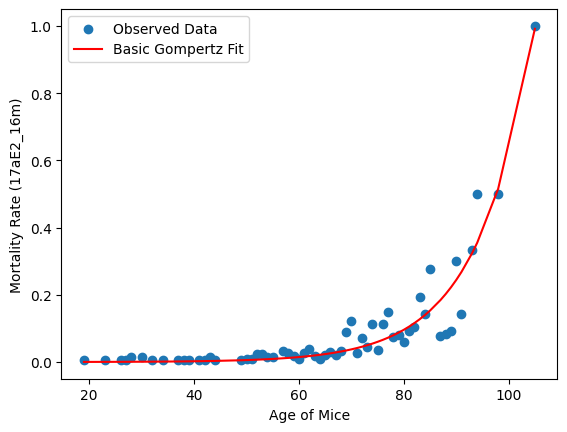

Fitted Parameters:
Alpha: 5.445714588049183e-05
Beta: 5.445714588049183e-05


Statistics:
R-squared: 0.9144397168503791
Mean Squared Error: 0.0021802518683680617




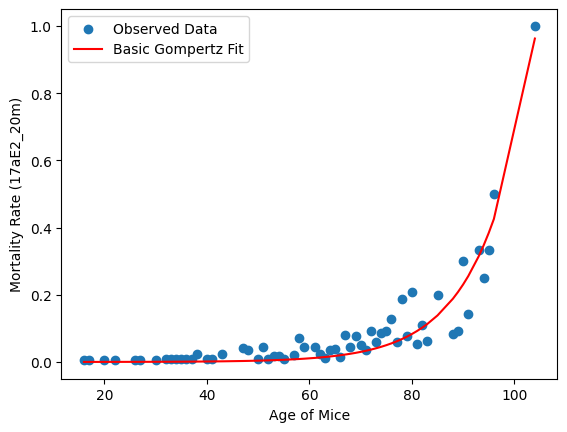

Fitted Parameters:
Alpha: 2.3703948305538282e-05
Beta: 2.3703948305538282e-05


Statistics:
R-squared: 0.9069052420704202
Mean Squared Error: 0.002159942721233759




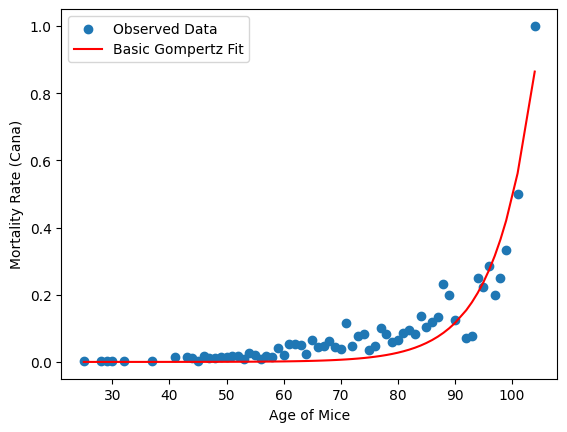

Fitted Parameters:
Alpha: 2.768773310598199e-07
Beta: 2.768773310598199e-07


Statistics:
R-squared: 0.8588463929886617
Mean Squared Error: 0.003017396139074664




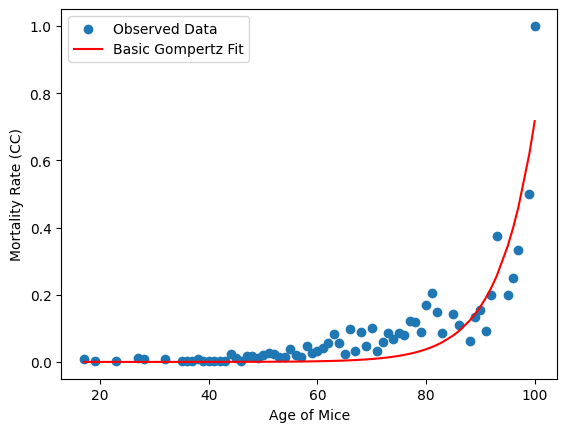

Fitted Parameters:
Alpha: 2.898408806576538e-07
Beta: 2.898408806576538e-07


Statistics:
R-squared: 0.7693297077253087
Mean Squared Error: 0.004846935458182022




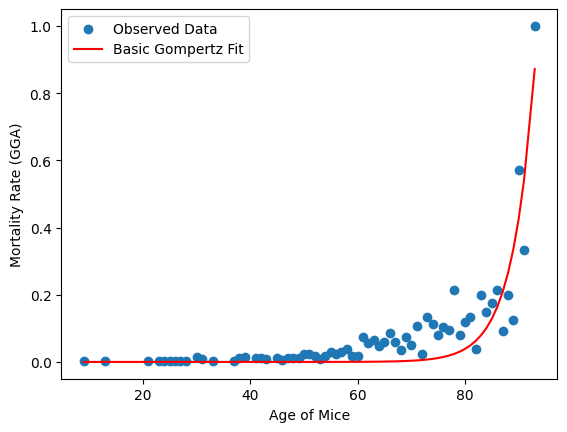

Fitted Parameters:
Alpha: 1.8239232381478172e-10
Beta: 1.8239232381478172e-10


Statistics:
R-squared: 0.7753849051441554
Mean Squared Error: 0.00479972762178572




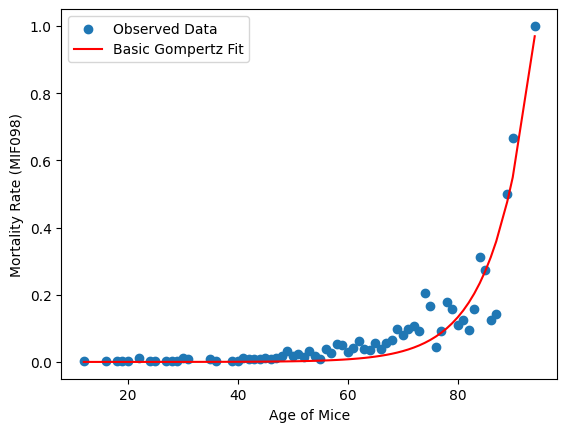

Fitted Parameters:
Alpha: 1.557188618447862e-06
Beta: 1.557188618447862e-06


Statistics:
R-squared: 0.8868228437682522
Mean Squared Error: 0.002855103020013002




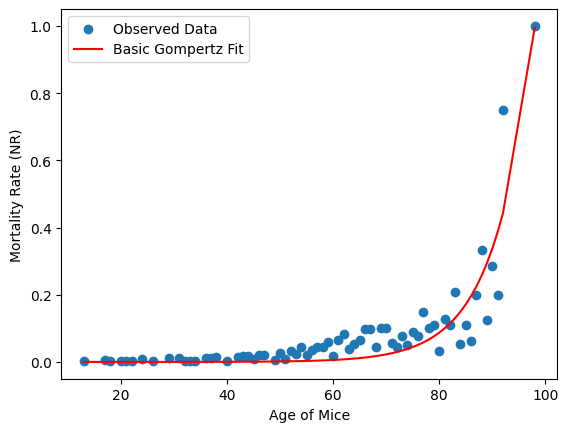

Fitted Parameters:
Alpha: 1.736181638986132e-06
Beta: 1.736181638986132e-06


Statistics:
R-squared: 0.8259807423489678
Mean Squared Error: 0.004142657556676409




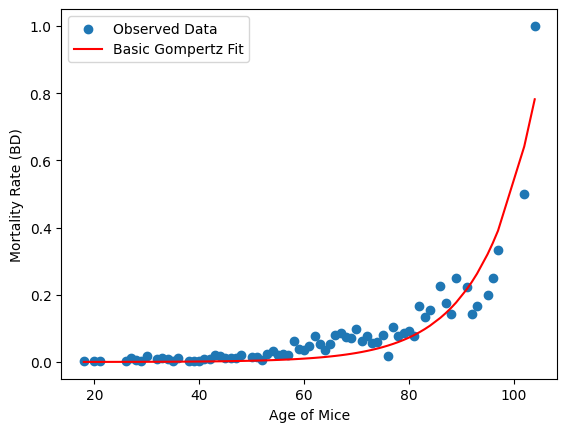

Fitted Parameters:
Alpha: 2.617625225085216e-05
Beta: 2.617625225085216e-05


Statistics:
R-squared: 0.8678607828595909
Mean Squared Error: 0.0026160248187148973




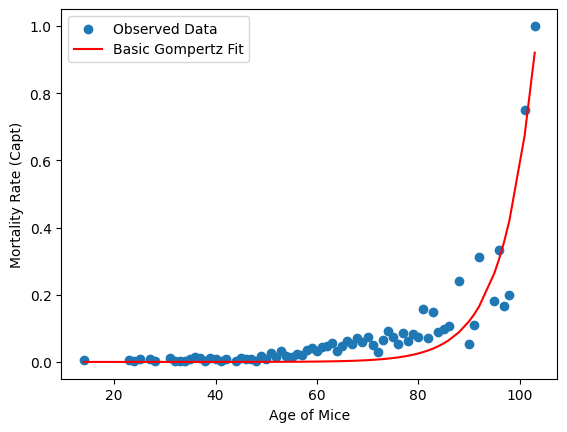

Fitted Parameters:
Alpha: 9.099368957589508e-08
Beta: 9.099368957589508e-08


Statistics:
R-squared: 0.8443523361369109
Mean Squared Error: 0.003638113148844921




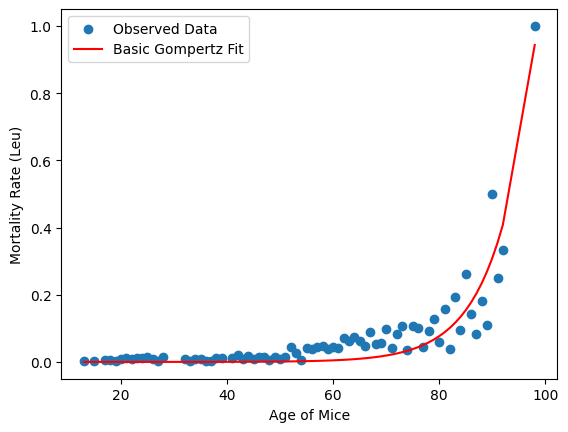

Fitted Parameters:
Alpha: 1.09922452184988e-06
Beta: 1.09922452184988e-06


Statistics:
R-squared: 0.8560416996738229
Mean Squared Error: 0.0026455095304003056




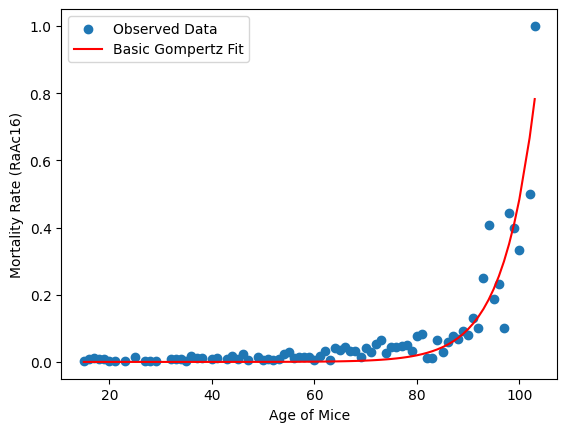

Fitted Parameters:
Alpha: 5.396422533524219e-08
Beta: 5.396422533524219e-08


Statistics:
R-squared: 0.859789652492828
Mean Squared Error: 0.0030333487033649396




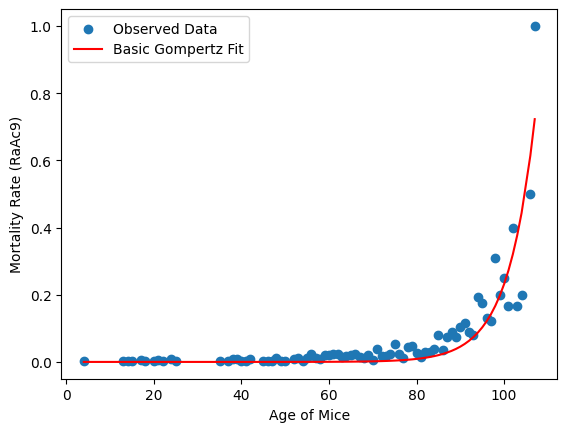

Fitted Parameters:
Alpha: 1.997307682896066e-08
Beta: 1.997307682896066e-08


Statistics:
R-squared: 0.8148041566182862
Mean Squared Error: 0.0035696123811291792




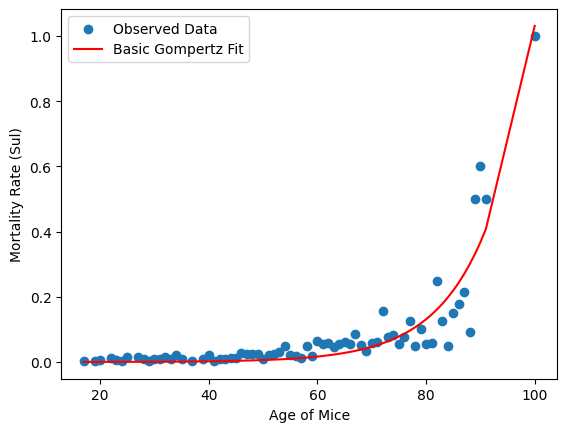

Fitted Parameters:
Alpha: 3.4126606629921214e-05
Beta: 3.4126606629921214e-05


Statistics:
R-squared: 0.8668480795361575
Mean Squared Error: 0.003219455276023093




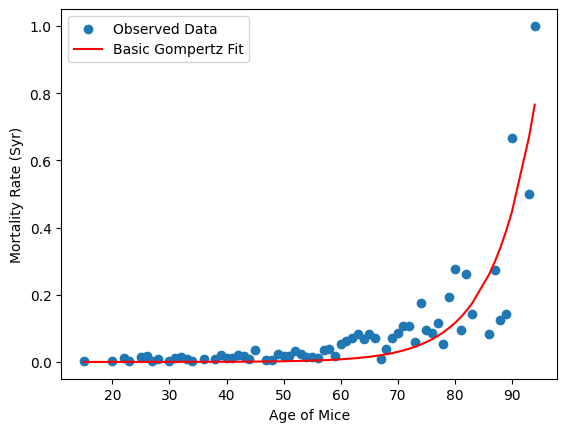

Fitted Parameters:
Alpha: 2.3737625437560783e-06
Beta: 2.3737625437560783e-06


Statistics:
R-squared: 0.767511222174879
Mean Squared Error: 0.005886335927660227




In [326]:
@dataclass
class ExperimentSample:
    ages: pd.DataFrame
    mortality_rate: pd.DataFrame

def compute_experiment_sample(experiment_group: pd.DataFrame, bin_period_in_days: int) -> None:
    dead_counts = remove_days_without_deaths(group_ages(experiment_group, bin_period_in_days))
    population_data = population_at_daystart(dead_counts)

    ages = dead_counts.index
    mortality_rate = calculate_mortality_rates(dead_counts, population_data)

    return ExperimentSample(ages=ages, mortality_rate=mortality_rate)

def fit_gompertz_from_experiment(experiment_sample: ExperimentSample, intitial_parameters: GompertzParameters) -> None:
    ages = experiment_sample.ages
    mortality_rate = experiment_sample.mortality_rate

    predicted_parameters = fit_gompertz_model(initial_parameters, ages, mortality_rate)
    predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)

    return predicted_parameters, predicted_mortality

def plot_fitted_gompertz_curve(experiment_sample: ExperimentSample, predicted_mortality: pd.DataFrame, title: str) -> None:
    ages = experiment_sample.ages
    mortality_rate = experiment_sample.mortality_rate

    # Plot the results
    plt.scatter(ages, mortality_rate, label='Observed Data')
    plt.plot(ages, predicted_mortality, label='Basic Gompertz Fit', color='red')
    plt.xlabel('Age of Mice')
    plt.ylabel(f'Mortality Rate ({title})')
    plt.legend()
    plt.show()


for experiment_name, experiment_group in experiment_groups.items():
    initial_parameters = GompertzParameters(alpha=0.1, beta=0.085)

    experiment_sample = compute_experiment_sample(experiment_group, mouse_bin_period_in_days)
    parameters, predicted_mortality = fit_gompertz_from_experiment(experiment_sample, initial_parameters)
    plot_fitted_gompertz_curve(experiment_sample, predicted_mortality, experiment_name)

    print('Fitted Parameters:')
    print("Alpha:", parameters.alpha)
    print("Beta:", parameters.alpha)

    print('\n')

    mortality_rate = experiment_sample.mortality_rate
    r_squared = r2_score(mortality_rate, predicted_mortality)
    mse = mean_squared_error(mortality_rate, predicted_mortality)

    print('Statistics:')
    print(f'R-squared: {r_squared}')
    print(f'Mean Squared Error: {mse}')
    print('\n')

# Human Data

Here we do some basic preprocessing to compute interesting statistics and also create the columns that are used in the mouse dataset. One small, but important fact worth mentioning is that the dataset is already binned by year which we multiply by 365 to get the number of days in which the data in binned.

#### Potential Future Improvements
We are currently ignoring leap years as we expect them to have little effect on the outcome, however including them as a fact could be considered a future improvement.

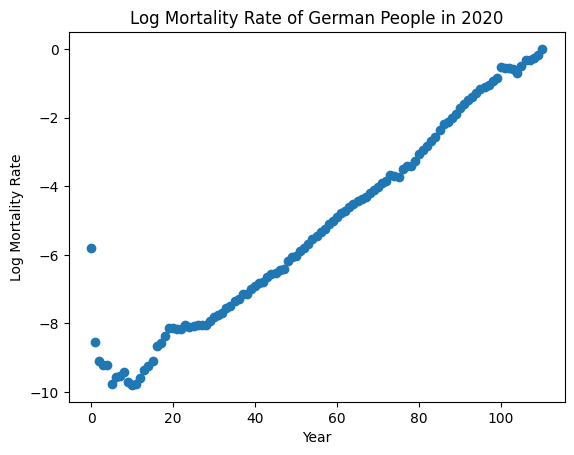

In [327]:
## Import  Human Data
human_mortality_df = pd.read_excel(HUMAN_LIFESPAN_DATASET_PATH)
human_mortality_df

human_mortality_df['MortalityRate'] = human_mortality_df['Total'] / human_mortality_df['Population']
human_mortality_df['LogMortalityRate'] = human_mortality_df['MortalityRate'].apply(lambda x: np.log(x))

# Add columns expected by bootstrap methods
human_mortality_df[[AGE_IN_DAYS_COLUMN]] = human_mortality_df[[HUMAN_AGE_IN_YEARS_COLUMN]] * days_per_years
human_mortality_df[[DEATH_COLUMN]] = human_mortality_df[[HUMAN_DEATHS_PER_YEAR_COLUMN]]

plt.scatter(human_mortality_df['Age'], human_mortality_df['LogMortalityRate'])
plt.xlabel('Year')
plt.ylabel('Log Mortality Rate')
plt.title('Log Mortality Rate of German People in 2020')
plt.show()

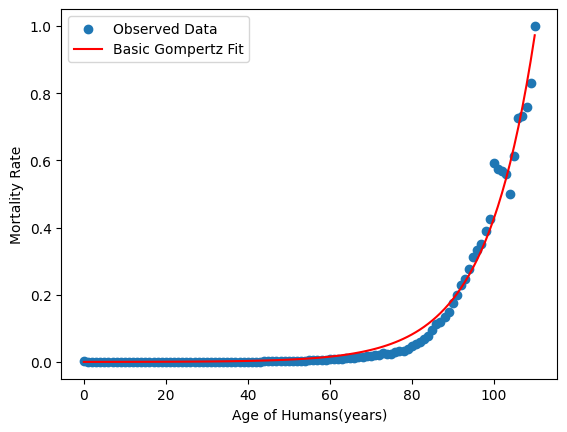

Fitted Parameters:
Alpha: 0.00011028263827521653
Beta: 0.0825845130129748


In [328]:
# Fit Human Data to Gompertz
ages = human_mortality_df['Age']
mortality_rates = human_mortality_df['MortalityRate']
human_samples = ExperimentSample(ages=ages, mortality_rate=mortality_rates)

human_initial_gompertz_parameters = GompertzParameters(alpha=0.1, beta=0.085)
predicted_parameters, predicted_mortality = fit_gompertz_from_experiment(human_samples, human_initial_gompertz_parameters)

predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)

# Plot the results
plt.scatter(ages, mortality_rates, label='Observed Data')
plt.plot(ages, predicted_mortality, label='Basic Gompertz Fit', color='red')
plt.xlabel('Age of Humans(years)')
plt.ylabel('Mortality Rate')
plt.legend()
plt.show()

print("Fitted Parameters:")
print("Alpha:", predicted_parameters.alpha)
print("Beta:", predicted_parameters.beta)


In [329]:
r_squared = r2_score(mortality_rates, predicted_mortality)
mse = mean_squared_error(mortality_rates, predicted_mortality)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')


R-squared: 0.9825271293807057
Mean Squared Error: 0.0007951298970120731


In [330]:
@dataclass
class BootstrapSetup:
    dataset: pd.DataFrame
    dataset_bin_period: int
    initial_parameters: GompertzParameters
    sample_percentage: float

def create_bootstrap_sample(df: pd.DataFrame, sample_percentage: int) -> pd.DataFrame:
    n_samples = int(len(df) * sample_percentage)
    indices = np.random.randint(low=0, high=len(df), size=n_samples)
    return df.iloc[indices]

def bootstrap_gompertz_parameters_once(setup: BootstrapSetup) -> GompertzParameters:
    bootstrap_sample = create_bootstrap_sample(setup.dataset, setup.sample_percentage)
    bootstrap_experiment_sample = compute_experiment_sample(bootstrap_sample, setup.dataset_bin_period)
    parameters, _ = fit_gompertz_from_experiment(bootstrap_experiment_sample, setup.initial_parameters)
    return parameters

def bootstrap_gompertz_parameters(setup: BootstrapSetup, n_trials: int):
    parameters_list = []
    for _ in range(n_trials):
        parameters = bootstrap_gompertz_parameters_once(setup)
        parameters_list.append(parameters)
    return parameters_list

def calculate_parameter_statistics(gompertz_parameters: [GompertzParameters]) -> GompertzParameters:
    alphas = np.array([p.alpha for p in gompertz_parameters])
    betas = np.array([p.beta for p in gompertz_parameters])

    parameter_mean = GompertzParameters(alpha=alphas.mean(), beta=betas.mean())
    parameter_variance = GompertzParameters(alpha=alphas.var(), beta=betas.var())

    return parameter_mean, parameter_variance

# Measuring Parameter Variance
Here we select randomly with replacement (bootstrap) death occurrances from each dataset and then predict a gompertz curve for each sample subset. This is followed with measuring the mean and the variance of the fitted parameters of the Gompertz curve. The latter statistic is especially useful in measuring in rough terms how "Gompertz-like" the data is. In other words, with a large variance this implies that model is not robust or generalize well therefore the data is not gompertz like. On the other hand, if it has low variance this means that the Gompertz curve is likely a model for fitting the data.

In [331]:
sample_percentage = 0.1

In [332]:
for experiment_name, experiment_group in experiment_groups.items():
    initial_parameters = GompertzParameters(alpha=0.1, beta=0.085)
    n_trials_mice = int(sqrt(len(experiment_group)))

    n_samples = int(len(experiment_group) * sample_percentage)
    mouse_bootstrap_setup = BootstrapSetup(experiment_group, dataset_bin_period=30, initial_parameters=initial_parameters,
                                            sample_percentage=sample_percentage)

    mouse_bootstrapped_parameters = bootstrap_gompertz_parameters(mouse_bootstrap_setup, n_trials=n_trials_mice)
    mouse_parameter_mean, mouse_parameter_variance = calculate_parameter_statistics(mouse_bootstrapped_parameters)

    print(f'Mouse Parameter Statistics ({experiment_name}):')
    print(f'mu = {mouse_parameter_mean}')
    print(f's^2 =  {mouse_parameter_variance}')
    print('\n')

Mouse Parameter Statistics (4-OH-PBN):
mu = (alpha=0.0012, beta=0.1995)
s^2 =  (alpha=0.0000, beta=0.0039)


Mouse Parameter Statistics (Asp):
mu = (alpha=0.0008, beta=0.2302)
s^2 =  (alpha=0.0000, beta=0.0081)


Mouse Parameter Statistics (Control):
mu = (alpha=0.0027, beta=0.1338)
s^2 =  (alpha=0.0000, beta=0.0004)


Mouse Parameter Statistics (NDGA):
mu = (alpha=0.0008, beta=0.2159)
s^2 =  (alpha=0.0000, beta=0.0028)


Mouse Parameter Statistics (NFP):
mu = (alpha=0.0013, beta=0.2050)
s^2 =  (alpha=0.0000, beta=0.0032)


Mouse Parameter Statistics (CAPE_hi):
mu = (alpha=0.0012, beta=0.2693)
s^2 =  (alpha=0.0000, beta=0.0152)


Mouse Parameter Statistics (CAPE_lo):
mu = (alpha=0.0014, beta=0.1978)
s^2 =  (alpha=0.0000, beta=0.0041)


Mouse Parameter Statistics (Enal):
mu = (alpha=0.0005, beta=0.2563)
s^2 =  (alpha=0.0000, beta=0.0119)


Mouse Parameter Statistics (Rapa):
mu = (alpha=0.0001, beta=0.2368)
s^2 =  (alpha=0.0000, beta=0.0036)


Mouse Parameter Statistics (Res_hi):
mu = (a

In [333]:
n_trials_humans = int(sqrt(len(human_mortality_df)))

# we set dataset_bin_period to 365 because the data has already been binned by the number of days in a years (365).
# Note: this ignore leap years, as it is assumed to be insigificant, but can be considered as a potential improvment.
human_bootstrap_setup = BootstrapSetup(human_mortality_df, dataset_bin_period=365, initial_parameters=initial_parameters,
                                       sample_percentage=sample_percentage)

human_bootstrapped_parameters = bootstrap_gompertz_parameters(human_bootstrap_setup, n_trials=n_trials_humans)
human_parameter_mean, human_parameter_variance = calculate_parameter_statistics(human_bootstrapped_parameters)

print(f'Human Parameter Statistics:')
print(f'mu = {human_parameter_mean}')
print(f's^2 =  {human_parameter_variance}')

Human Parameter Statistics:
mu = (alpha=0.0232, beta=0.0562)
s^2 =  (alpha=0.0005, beta=0.0019)


# Mortality Analysis for Treatment Data

In [334]:
def load_data_into_dicts(data_path,group_by_days=None):
    """
    Load CSV files from the specified path into male and female dictionaries.

    Parameters:
    - data_path (str): Path to the directory containing CSV files.

    Returns:
    - male_data (dict): Dictionary containing male data.
    - female_data (dict): Dictionary containing female data.
    """
    # Create empty dictionaries for male and female data
    male_data = {}
    female_data = {}

    # Iterate through all CSV files in the specified path
    for file_name in os.listdir(data_path):
        if file_name.endswith(".csv"):
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(os.path.join(data_path, file_name))

            # Extract the gender and treatment information from the file name
            gender, treatment = file_name.split("_")[0], "_".join(file_name.split("_")[1:])

            # Combine gender and treatment to form the dictionary key
            key = f"{gender}_{treatment[:-4]}"  # Removing the ".csv" extension from treatment
            
            # Round Ages
            df['x'] = df['x'].apply(lambda x: floor(x))
            
            # Round Survival Rate
            df['y'] = df['y'].apply(lambda x: round(x,2))

            # Calculate the "Population" at each day
            df['Population'] = df['y'].apply(lambda x: floor(50 * x))
            df = df.drop_duplicates(subset=['Population'])
            
            # Calculate the "Deaths" at each day
            df['Death'] = 50 - df['Population']
            df['Death'] = df['Death'] - df['Death'].shift(1)
            
            #remove "negative deaths" -> mistake in data gathering
            df = df[df['Death'] >= 0]

            if group_by_days:
                df['Age'] = (df['x'] // group_by_days) 
                df = df.groupby('Age').agg({'Death': 'sum', 'Population': 'min'}).reset_index()
            else:
                df['Age'] = df['x']
                
            # Calculate the Mortality Rates
            df['Mortality'] = df['Death'] / df['Population']
                
            # Check gender and store the DataFrame in the appropriate dictionary
            if gender.lower() == "male":
                male_data[key] = df
            elif gender.lower() == "female":
                female_data[key] = df
    return male_data, female_data

def plot_gender_mortality(data_dict, gender_label, plot_log_mortality = False, plot_linear_regression = False):
    if plot_log_mortality:
        for key, df in data_dict.items():
            log_mortality = np.log(df['Mortality'])
            scatter_plot = plt.scatter(df['Age'], log_mortality, label=f'{key.split("male_")[1]}')
            
            if plot_linear_regression:
                # Extract color from scatter plot
                line_color = scatter_plot.get_facecolor()[0]
                # Calculate linear regression for log mortality
                slope, intercept, _, _, _ = linregress(df['Age'], log_mortality)
                linear_regression_line = slope * df['Age'] + intercept
                plt.plot(df['Age'], linear_regression_line, color=line_color,
                         linestyle='dashed', linewidth=1,alpha=0.5)
            
        plt.title(str("Treatment Data - " + gender_label + " Log Mortality"))
        
    else:
        for key, df in data_dict.items():
            plt.scatter(df['Age'], df['Mortality'], label=f'{key.split("male_")[1]}')
        plt.title(str("Treatment Data - " + gender_label + " Mortality"))
            
    plt.xlabel('Age')
    plt.ylabel('Mortality Rate')
    
    # Move the legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

def fit_and_plot_gompertz(data_dict):
    for key, df in data_dict.items():
        ages = df['Age']
        mortality_rates = df['Mortality']

        # Fit Treatment Data to Gompertz
        treatment_samples = ExperimentSample(ages=ages, mortality_rate=mortality_rates)

        initial_gompertz_parameters = GompertzParameters(alpha=0.1, beta=0.085)
        predicted_parameters, predicted_mortality = fit_gompertz_from_experiment(treatment_samples, initial_gompertz_parameters)

        # Predict mortality using the fitted parameters
        predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)

        # Plot the results
        plt.scatter(ages, mortality_rates, label=f'{key} - Observed Data')
        plt.plot(ages, predicted_mortality, label=f'{key} - Gompertz Fit', color='red')
        plt.xlabel('Age of Mice (Days)')
        plt.ylabel('Mortality Rate')
        plt.legend()
        plt.show()

        # Display fitted parameters
        print(f"\nFitted Parameters for {key}:")
        print("Alpha:", predicted_parameters.alpha)
        print("Beta:", predicted_parameters.beta)

In [335]:
data_path = "../dat/RMR_data/"
male_dict, female_dict = load_data_into_dicts(data_path, mouse_bin_period_in_days)
female_dict["female_None"]

Age  Death  Population  Mortality
0    45    3.0          47   0.063830
1    46    1.0          46   0.021739
2    48    2.0          44   0.045455
3    49    1.0          43   0.023256
4    51    2.0          41   0.048780
5    53    4.0          37   0.108108
6    55    2.0          35   0.057143
7    57    1.0          34   0.029412
8    58    3.0          33   0.090909
9    59    1.0          32   0.031250
10   60    1.0          31   0.032258
11   61    3.0          28   0.107143
12   62    3.0          25   0.120000
13   63    3.0          24   0.125000
14   64    3.0          21   0.142857
15   65    2.0          19   0.105263
16   67    2.0          18   0.111111

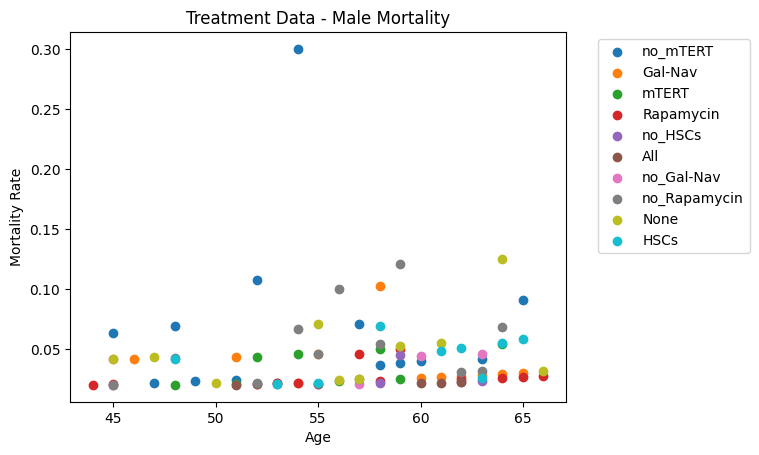

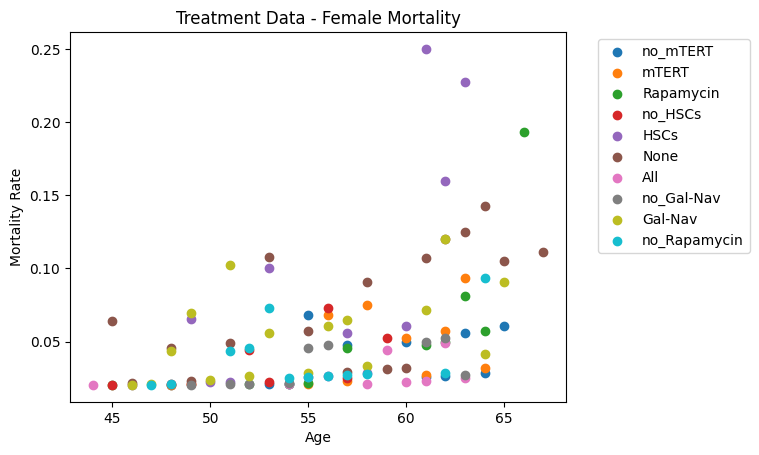

In [336]:
plot_gender_mortality(male_dict, 'Male')
plot_gender_mortality(female_dict, 'Female')

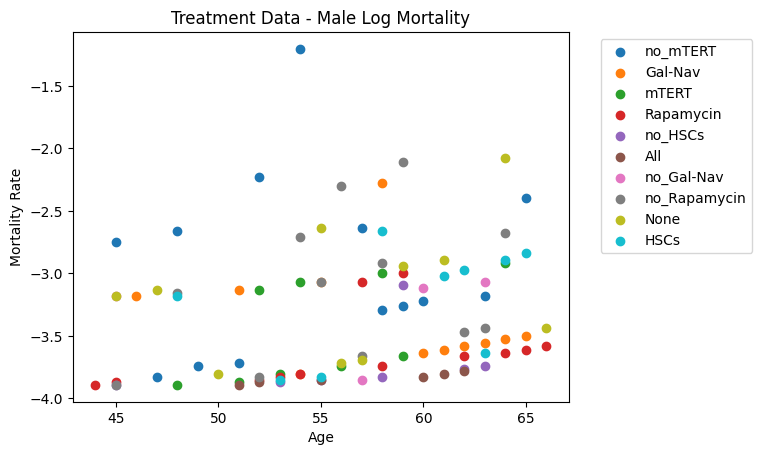

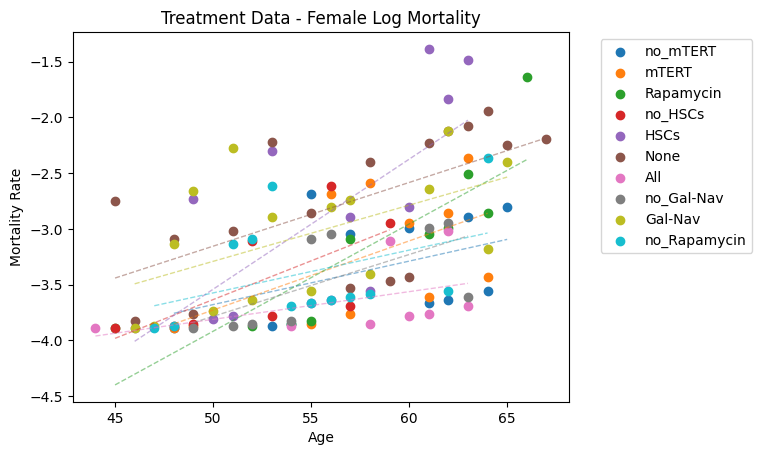

In [337]:
plot_gender_mortality(male_dict, 'Male',plot_log_mortality=True)
plot_gender_mortality(female_dict, 'Female',plot_log_mortality=True, plot_linear_regression = True)

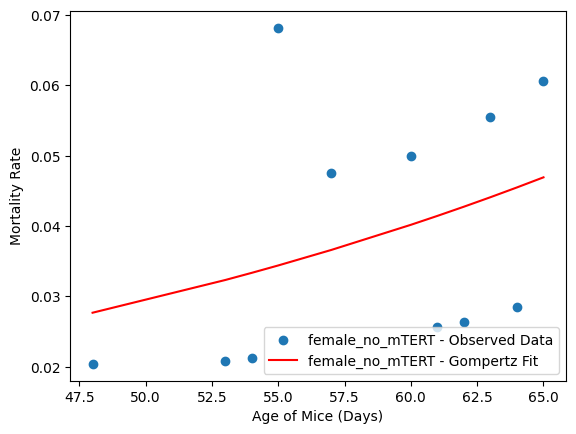


Fitted Parameters for female_no_mTERT:
Alpha: 0.006238115759381813
Beta: 0.031048087676143917


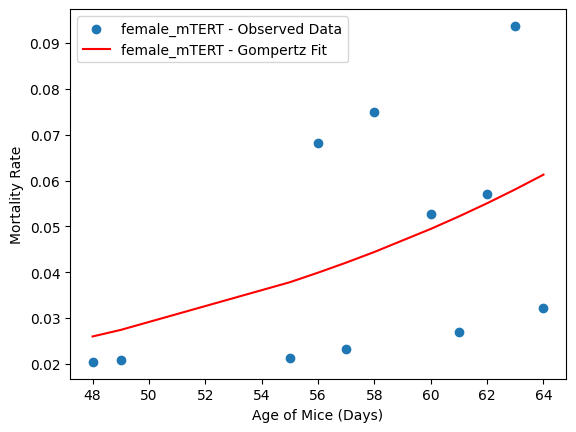


Fitted Parameters for female_mTERT:
Alpha: 0.001974764393902163
Beta: 0.05367264510254884


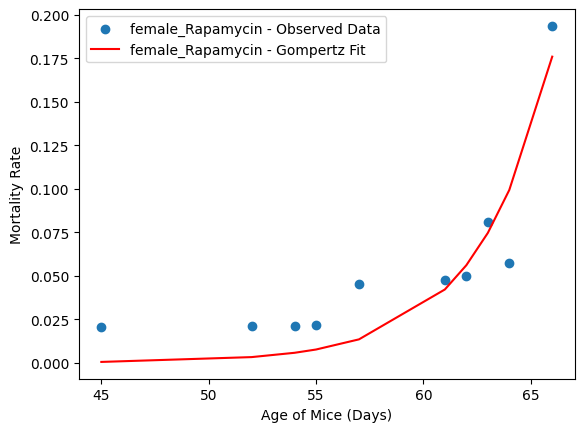


Fitted Parameters for female_Rapamycin:
Alpha: 1.1100826805258665e-09
Beta: 0.28607442164635377


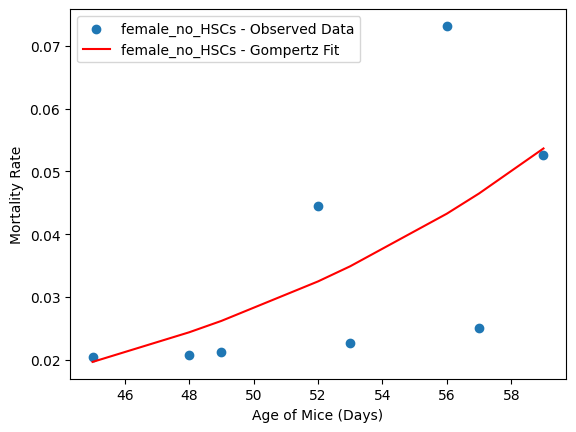


Fitted Parameters for female_no_HSCs:
Alpha: 0.0007826830558936298
Beta: 0.07165629183571774


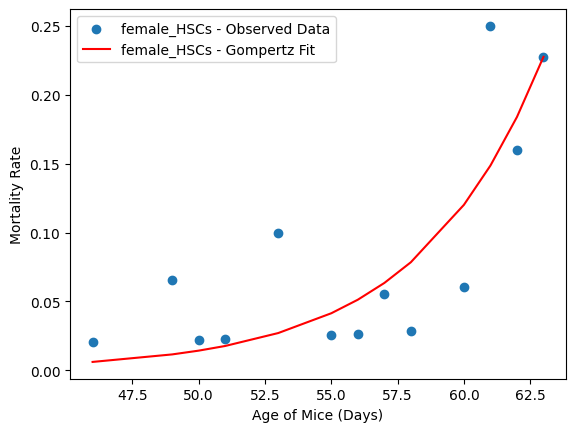


Fitted Parameters for female_HSCs:
Alpha: 3.392066001725172e-07
Beta: 0.2129564467178377


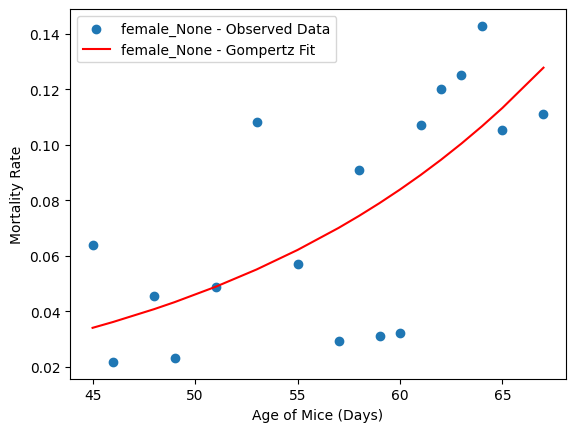


Fitted Parameters for female_None:
Alpha: 0.002271074529551118
Beta: 0.06015309222926334


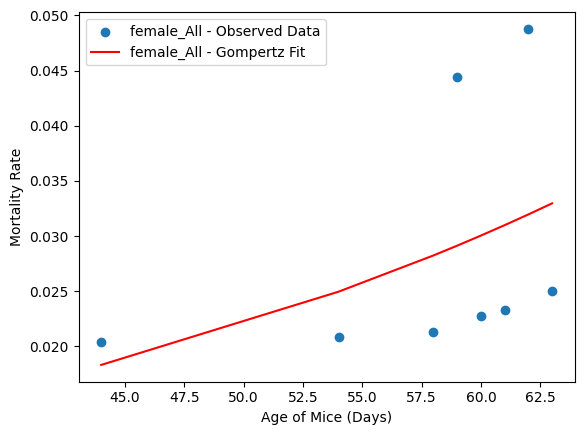


Fitted Parameters for female_All:
Alpha: 0.004698090182430821
Beta: 0.030926175276812403


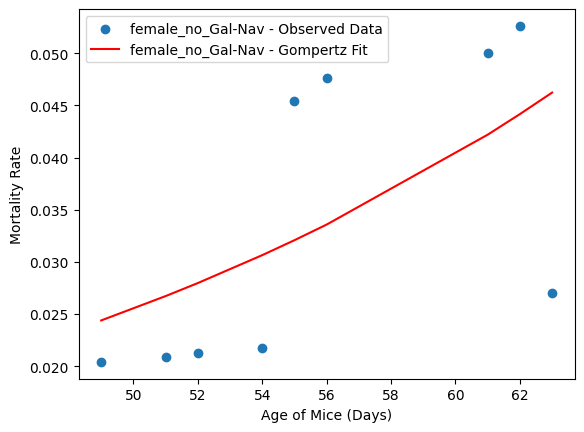


Fitted Parameters for female_no_Gal-Nav:
Alpha: 0.002598116706933605
Beta: 0.04569957500556518


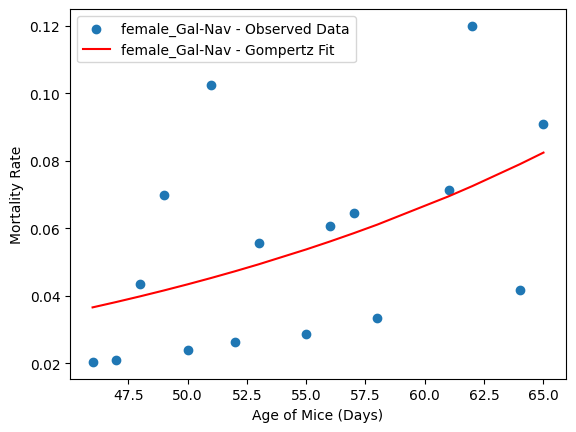


Fitted Parameters for female_Gal-Nav:
Alpha: 0.005109479560270304
Beta: 0.042786884644677864


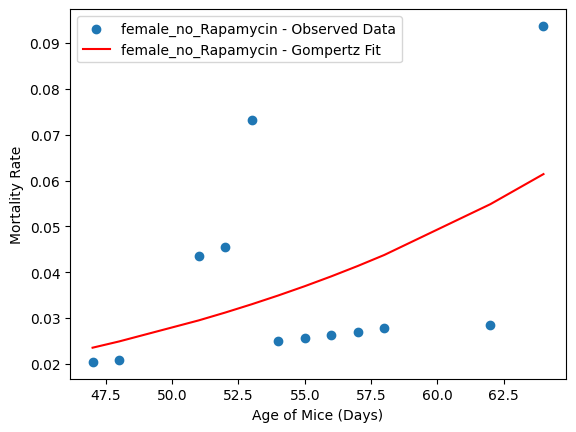


Fitted Parameters for female_no_Rapamycin:
Alpha: 0.0016543188485365343
Beta: 0.05647100743724999


In [338]:
fit_and_plot_gompertz(female_dict)

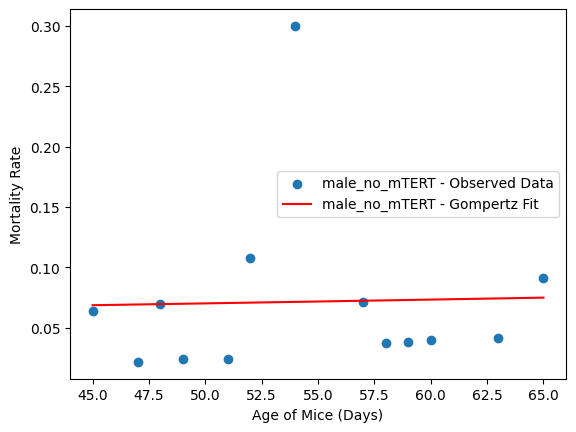


Fitted Parameters for male_no_mTERT:
Alpha: 0.05643437423985459
Beta: 0.004372009807582023


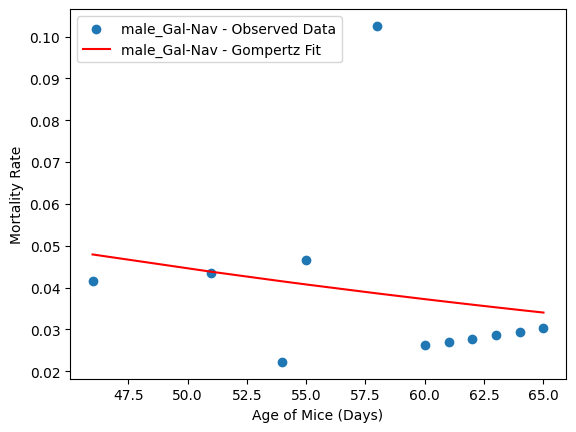


Fitted Parameters for male_Gal-Nav:
Alpha: 0.10981247065213973
Beta: -0.018026763594694472


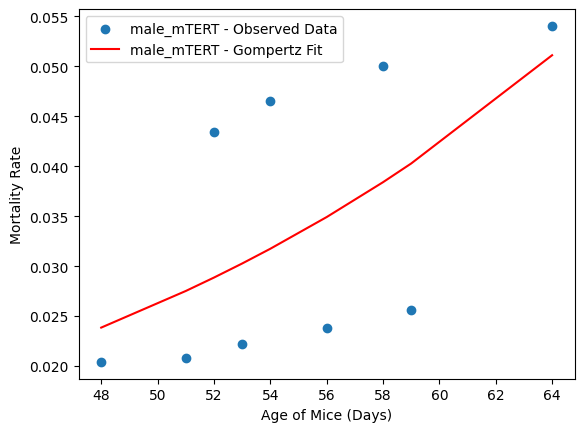


Fitted Parameters for male_mTERT:
Alpha: 0.0024200088408228917
Beta: 0.04766231351985765


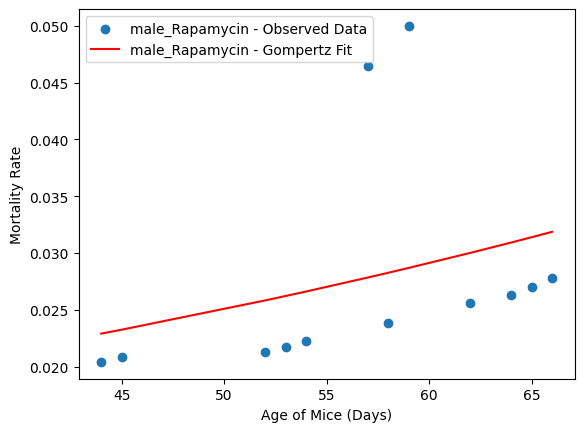


Fitted Parameters for male_Rapamycin:
Alpha: 0.01183004919982492
Beta: 0.015013079883566314


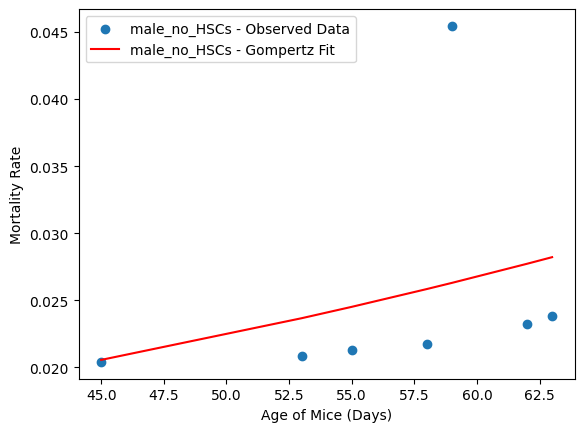


Fitted Parameters for male_no_HSCs:
Alpha: 0.009317170844720508
Beta: 0.01758825500764167


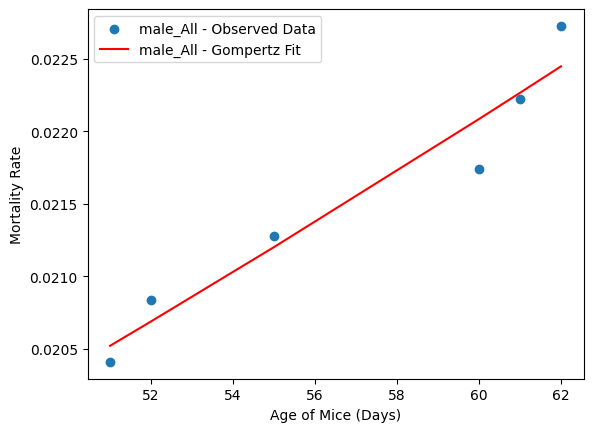


Fitted Parameters for male_All:
Alpha: 0.013529249768205857
Beta: 0.008167077693830564


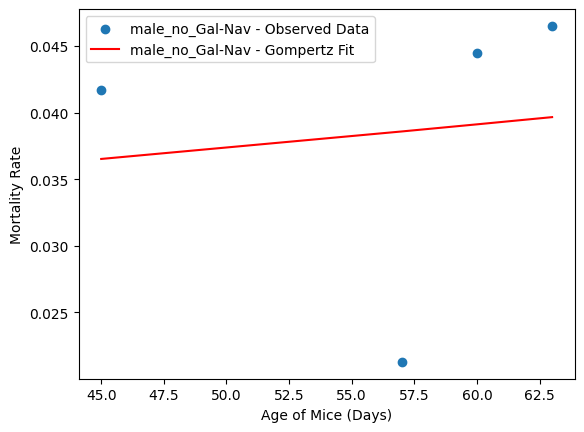


Fitted Parameters for male_no_Gal-Nav:
Alpha: 0.029715436433463097
Beta: 0.00458280015151497


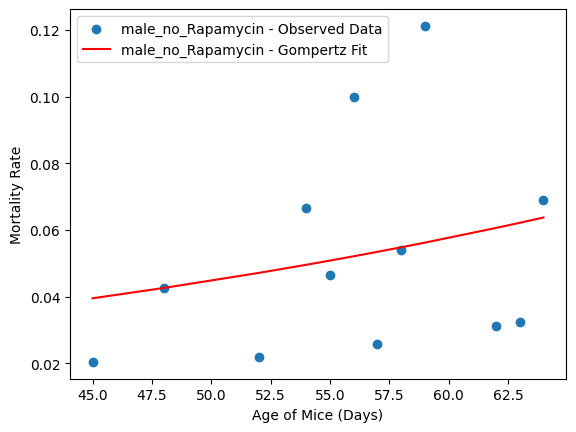


Fitted Parameters for male_no_Rapamycin:
Alpha: 0.012719534503379315
Beta: 0.025180190046377487


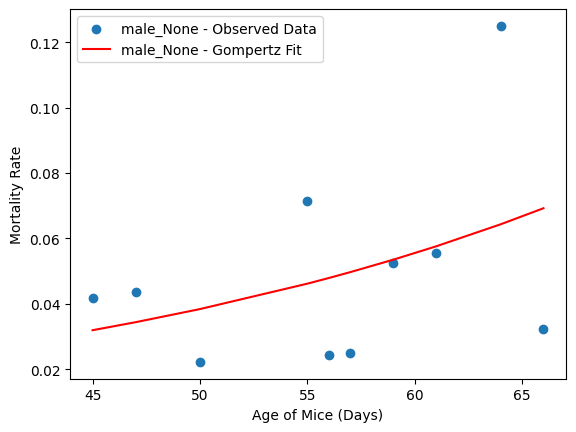


Fitted Parameters for male_None:
Alpha: 0.006078244363037673
Beta: 0.036859260813918104


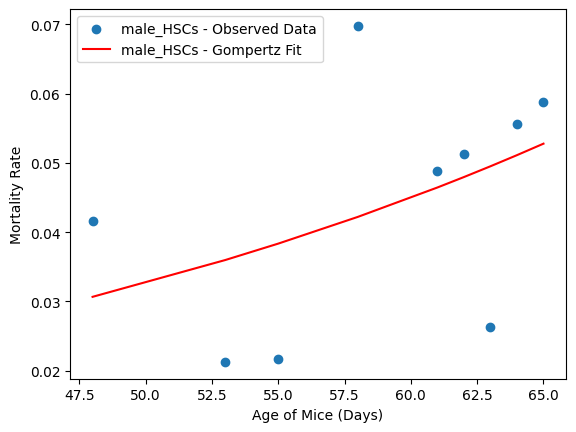


Fitted Parameters for male_HSCs:
Alpha: 0.006624657286439086
Beta: 0.03192691176419036


In [339]:
fit_and_plot_gompertz(male_dict)